In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 

In [2]:
# timesteps from 1h to 24h 
df = pd.read_csv("cleaned_data\\24timestep1h.csv", parse_dates=['tstp'])
df = df.drop(['date'], axis=1) # date column when joined with the holiday

In [3]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

def create_fourier(date_index):
    fourier = CalendarFourier(
        freq='D',
        order=1
    )
    dp = DeterministicProcess(
        index=date_index,
        constant=True,
        order=1,
        seasonal=True,
        additional_terms=[fourier],
        drop=True
    )

    return dp

In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# label encoding
precip_encoder = OneHotEncoder(sparse_output=False)
holiday_encoder = OneHotEncoder(sparse_output=False)
summary_encoder = OneHotEncoder(sparse_output=False)
household_encoder = LabelEncoder()
stdor_encoder = OneHotEncoder(sparse_output=False)
acorn_encoder = LabelEncoder()

precip_labels = precip_encoder.fit_transform(df[['precipType']])
holiday_labels = holiday_encoder.fit_transform(df[['Type']])
summary_labels = summary_encoder.fit_transform(df[['summary']])
household_labels = household_encoder.fit_transform(df[['LCLid']])
stdor_labels = stdor_encoder.fit_transform(df[['stdorToU']])
acorn_labels = acorn_encoder.fit_transform(df[['Acorn']])

precip_labels = pd.DataFrame(precip_labels, columns=precip_encoder.get_feature_names_out()).astype('int8')
holiday_labels = pd.DataFrame(holiday_labels, columns=holiday_encoder.get_feature_names_out()).astype('int8')
summary_labels = pd.DataFrame(summary_labels, columns=summary_encoder.get_feature_names_out()).astype('int8')
household_labels = pd.DataFrame(household_labels, columns=['household_label']).astype('int8')
stdor_labels = pd.DataFrame(stdor_labels, columns=stdor_encoder.get_feature_names_out()).astype('int8')
acorn_labels = pd.DataFrame(acorn_labels, columns=['acorn_label']).astype('int8')

encoded_df = pd.concat([df, precip_labels, holiday_labels, summary_labels, household_labels, stdor_labels, acorn_labels], axis=1)
encoded_df = encoded_df.drop(['precipType', 'Type', 'summary', 'LCLid', 'stdorToU', 'Acorn'], axis=1)

c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\Usrer\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [5]:
# process fourier features for each group and saved each group's deterministic process
import math

dps = {}

all_household_ids = encoded_df['household_label'].unique()
households_grp = encoded_df.groupby('household_label')
training_df = []
testing_df = []

for household_id in all_household_ids:
    # get the household from the entire df
    print("Household id:", household_id)
    singlehousehold_df = households_grp.get_group(household_id).sort_values(by='tstp', ascending=True)

    # split into train, test
    cutoff_point = math.floor(singlehousehold_df.shape[0] * 0.9)
    training_singlehousehold_df = singlehousehold_df.iloc[:cutoff_point].reset_index()
    testing_singlehousehold_df = singlehousehold_df.iloc[cutoff_point:].reset_index()

    # create fourier features
    fourier_obj = create_fourier(training_singlehousehold_df.set_index('tstp').asfreq('h').index)
    fourier_train_features = fourier_obj.in_sample().reset_index().drop(['tstp'], axis=1)
    training_singlehousehold_df = pd.concat([training_singlehousehold_df, fourier_train_features], axis=1)
    fourier_test_features = fourier_obj.out_of_sample(testing_singlehousehold_df.shape[0]).reset_index().drop(['index'], axis=1)
    testing_singlehousehold_df = pd.concat([testing_singlehousehold_df.reset_index().drop(['index'], axis=1), fourier_test_features], axis=1)
    
    # save the dp object
    dps[household_id] = fourier_obj

    # append to the household_dfs list
    training_df.append(training_singlehousehold_df)
    testing_df.append(testing_singlehousehold_df)

training_df = pd.concat(training_df, axis=0)
testing_df = pd.concat(testing_df, axis=0)

Household id: 35
Household id: 30
Household id: 14
Household id: 46
Household id: 41
Household id: 24
Household id: 26
Household id: 37
Household id: 6
Household id: 45
Household id: 19
Household id: 3
Household id: 39
Household id: 32
Household id: 8
Household id: 22
Household id: 11
Household id: 38
Household id: 42
Household id: 10
Household id: 15
Household id: 16
Household id: 29
Household id: 36
Household id: 1
Household id: 23
Household id: 31
Household id: 28
Household id: 21
Household id: 7
Household id: 49
Household id: 17
Household id: 27
Household id: 0
Household id: 44
Household id: 5
Household id: 40
Household id: 12
Household id: 48
Household id: 33
Household id: 13
Household id: 2
Household id: 50
Household id: 43
Household id: 25
Household id: 34
Household id: 20
Household id: 18
Household id: 4
Household id: 9
Household id: 47


In [6]:
print("Training shape:", training_df.shape)
print("Testing shape:", testing_df.shape)

Training shape: (686587, 137)
Testing shape: (76315, 137)


In [7]:
# scale the values
from sklearn.preprocessing import MinMaxScaler

# drop unnecessary columns
training_df = training_df.drop(['index', 'tstp'], axis=1)
testing_df = testing_df.drop(['level_0', 'tstp'], axis=1)

# separate into features and target
X_train = training_df.drop(['energy(kWh/hh)'], axis=1)
X_test = testing_df.drop(['energy(kWh/hh)'], axis=1)
y_train = training_df['energy(kWh/hh)']
y_test = testing_df['energy(kWh/hh)']

# store the household ids for future evaluation
test_household_ids = X_test['household_label']
train_household_ids = X_train['household_label']

# Scale with MinMax Normalization
scaler = MinMaxScaler(feature_range=(0, 1)) # scale to 0 and 1
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# reshape for LSTM, CNN-LSTM models
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

print(X_train.shape)
print(X_test.shape)

(686587, 1, 134)
(76315, 1, 134)


## Understanding on the Evaluation Set

In [8]:
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score

def adjusted_r2(y_pred, y_test):
   p = X_train.shape[2]
   r2 = r2_score(y_pred, y_test)
   n = y_test.shape[0]
   
   adjusted_coefficient = 1 - (1 - r2) * (n - 1) / (n - p - 1)

   return adjusted_coefficient

def evaluate_model(y_pred, y_test, deep_learning):
  """
    Evaluate the model predictions with all the regression metrics
  """
  if deep_learning:
    prediction = y_pred.ravel()

  else:
    prediction = y_pred

  print("RMSE:", mean_squared_error(prediction, y_test, squared=False))
  print("MSE:", mean_squared_error(prediction, y_test, squared=True))
  print("MAE:", mean_absolute_error(prediction, y_test))
  print("MAPE:", mean_absolute_percentage_error(prediction, y_test))
  print("R2 Score:", r2_score(prediction, y_test))
  print("Adjusted R2 Score:", adjusted_r2(prediction, y_test))

def plot_forecast(y_pred, y_test, number_of_slices=3, steps=168, skip=0):
    """
      Plot the forecasted values against the truth values for LSTM and CNN-LSTM
    """
    fig, axes = plt.subplots(number_of_slices, 1, sharey=True, figsize=(14, 10))
    timesteps = np.arange(0, steps)
    
    for i in range(number_of_slices):
        start_idx = 0 + (steps * i) + (skip)
        end_idx = steps * (1 + i) + (skip)
        sampled_test = y_test.iloc[start_idx:end_idx]
        sampled_pred = y_pred.iloc[start_idx:end_idx]

        mse = round(mean_squared_error(sampled_test, sampled_pred), 4)
        rmse = round(mean_squared_error(sampled_test, sampled_pred, squared=False), 4)
        mae = round(mean_absolute_error(sampled_test, sampled_pred), 4)
        mape = round(mean_absolute_percentage_error(sampled_test, sampled_pred), 2)
        r2 = round(r2_score(sampled_test, sampled_pred), 4)
        
        sns.lineplot(x=timesteps, y=sampled_test, label="truth-value", marker='o', alpha=0.3, ax=axes[i])
        sns.lineplot(x=timesteps, y=sampled_pred, label="pred-value", marker='o', ax=axes[i])
        axes[i].set_title(f'MSE: {mse}; RMSE: {rmse}; MAE: {mae}; MAPE: {mape}; R2: {r2}')
        axes[i].set_ylabel('Energy (kWh/hh)')

    plt.tight_layout()
    plt.show()
    

In [9]:
# preprare dataset for evaluation
y_test_with_ids = np.hstack((y_test.values.reshape(-1, 1), test_household_ids.values.reshape(-1, 1)))
y_test_with_ids = pd.DataFrame(y_test_with_ids, columns=['y_test', 'household_ids'])
y_test_with_ids

y_test  household_ids
0       0.751           35.0
1       0.758           35.0
2       0.750           35.0
3       0.856           35.0
4       0.886           35.0
...       ...            ...
76310   0.076           47.0
76311   0.037           47.0
76312   0.039           47.0
76313   0.041           47.0
76314   0.021           47.0

[76315 rows x 2 columns]

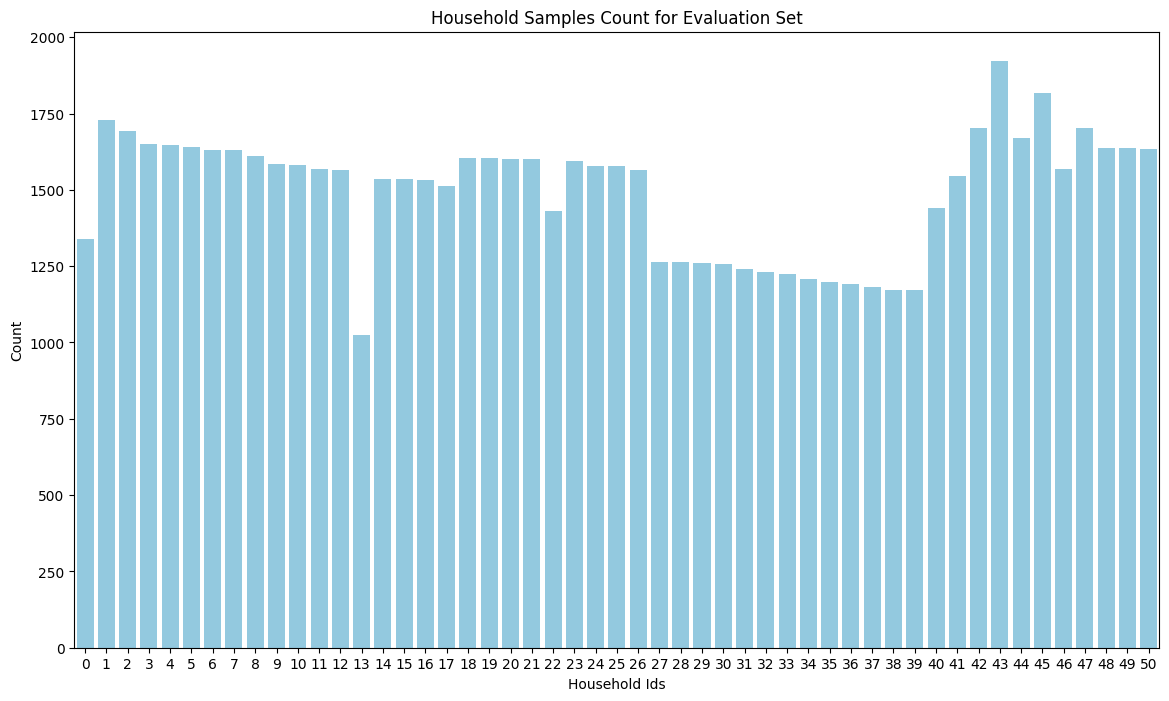

In [36]:
plt.figure(figsize=(14, 8))
household_counts = y_test_with_ids['household_ids'].value_counts().reset_index()
household_counts['index'] = household_counts['index'].astype('int8')
plt.title(f'Household Samples Count for Evaluation Set')
sns.barplot(data=household_counts.sort_values(by='index', ascending=True), x='index', y='household_ids', color='skyblue')
plt.xlabel('Household Ids')
plt.ylabel('Count')
plt.show()

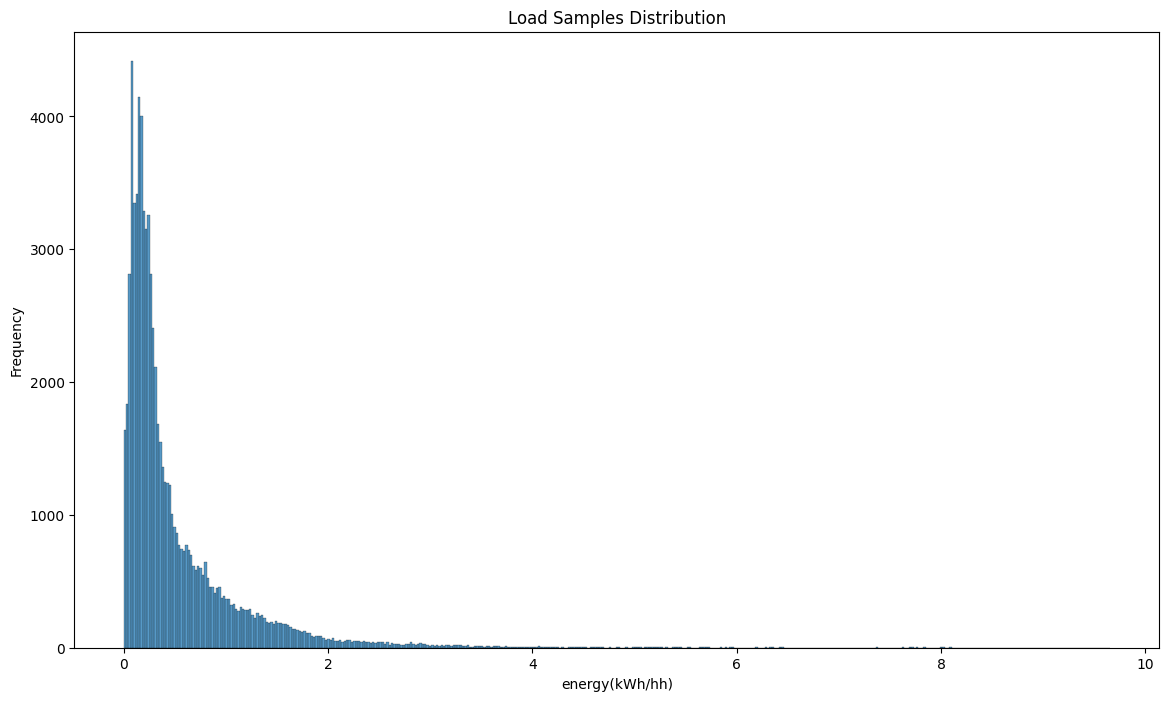

In [41]:
plt.figure(figsize=(14, 8))
plt.title("Load Samples Distribution")
plt.xlabel("energy(kWh/hh)")
plt.ylabel("Frequency")
sns.histplot(x=y_test_with_ids['y_test'])
plt.show()

In [42]:
y_test_with_ids['y_test'].describe()

count    76315.000000
mean         0.513967
std          0.644126
min          0.000000
25%          0.148000
50%          0.278000
75%          0.640000
max          9.655001
Name: y_test, dtype: float64

# Evaluation

## Deterministic Approach

In [20]:
def calculate_error(y_pred, y_test):
  return y_pred - y_test

def plot_error_distribution(residuals):
    plt.figure(figsize=(14, 8))
    plt.title("Residuals Distribution")
    plt.xlabel("Residuals")
    plt.ylabel("Frequency")
    sns.histplot(x=residuals, kde=True)
    plt.show()

def plot_metrics_bar(top5, bottom5, metric_name):
    if metric_name not in ['r2', 'adjusted_r2']:
      plt.figure(figsize=(14, 8))
      _, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
      ax = sns.barplot(data=top5.round(4), x='household_id', y=metric_name, color='tomato', ax=axes[0])
      axes[0].set_title(f'{metric_name.upper()} by Household')
      axes[0].set_ylabel(metric_name.upper())
      axes[0].set_xlabel('Household Ids')
      for i in ax.containers:
        ax.bar_label(i,)

      ax = sns.barplot(data=bottom5.round(4), x='household_id', y=metric_name, color='mediumseagreen', ax=axes[1])
      axes[1].set_title(f'{metric_name.upper()} by Household')
      axes[1].set_ylabel(metric_name.upper())
      axes[1].set_xlabel('Household Ids')
      for i in ax.containers:
        ax.bar_label(i,)

      plt.show()

    else:
      plt.figure(figsize=(14, 8))
      _, axes = plt.subplots(1, 2, figsize=(14, 8), sharey=True)
      axes[0].set_title(f'{metric_name.upper()} by Household')
      axes[0].set_ylabel(metric_name.upper())
      axes[0].set_xlabel('Household Ids')
      ax = sns.barplot(data=top5.round(4), x='household_id', y=metric_name, color='mediumseagreen', ax=axes[0])
      for i in ax.containers:
        ax.bar_label(i,)

      ax = sns.barplot(data=bottom5.round(4), x='household_id', y=metric_name, color='tomato', ax=axes[1])
      axes[1].set_title(f'{metric_name.upper()} by Household')
      axes[1].set_ylabel(metric_name.upper())
      axes[1].set_xlabel('Household Ids')
      for i in ax.containers:
        ax.bar_label(i,)

      plt.tight_layout()
      plt.show()

def plot_training_metrics(history):
  training_metrics = history.history
  loss = training_metrics['loss']
  val_loss = training_metrics['val_loss']
  mae = training_metrics['mae']
  val_mae = training_metrics['val_mae']


  timesteps = np.arange(len(loss))
  plt.figure(figsize=(14, 8))
  plt.subplot(1, 2, 1)
  sns.lineplot(x=timesteps, y=loss, label='loss', marker='o')
  sns.lineplot(x=timesteps, y=val_loss, label='val_loss', marker='o')
  plt.title("Loss vs Validation Loss")
  plt.xlabel("Epochs")  
  plt.ylabel("Loss")

  plt.subplot(1, 2, 2) 
  sns.lineplot(x=timesteps, y=mae, label='mae', marker='o')
  sns.lineplot(x=timesteps, y=val_mae, label='val_mae', marker='o')
  plt.title("Mean Absolute Error vs Validation Mean Absolute Error")
  plt.xlabel("Epochs")
  plt.ylabel("Mean Absolute Error")

  plt.tight_layout()
  plt.show()
    

### XGBoost

In [12]:
from xgboost import XGBRegressor

# reshape back to the original shape for XGBoost
ml_train = X_train.reshape(X_train.shape[0], X_train.shape[2]) 
ml_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

hyperparams = {'learning_rate': 0.003, 'max_depth': 9, 'n_estimators': 1000, 'reg_alpha': 0.5}
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=5, **hyperparams) # uses 5 CPU cores
xgb_model.fit(ml_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.003, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=5,
             num_parallel_tree=None, random_state=42, ...)

In [14]:
y_pred = xgb_model.predict(ml_test)
evaluate_model(y_pred, y_test, deep_learning=False)

RMSE: 0.19255268237741674
MSE: 0.03707653549073833
MAE: 0.09899055202323351
MAPE: 0.23080641875113853
R2 Score: 0.8794274402674932
Adjusted R2 Score: 0.8792153541162179


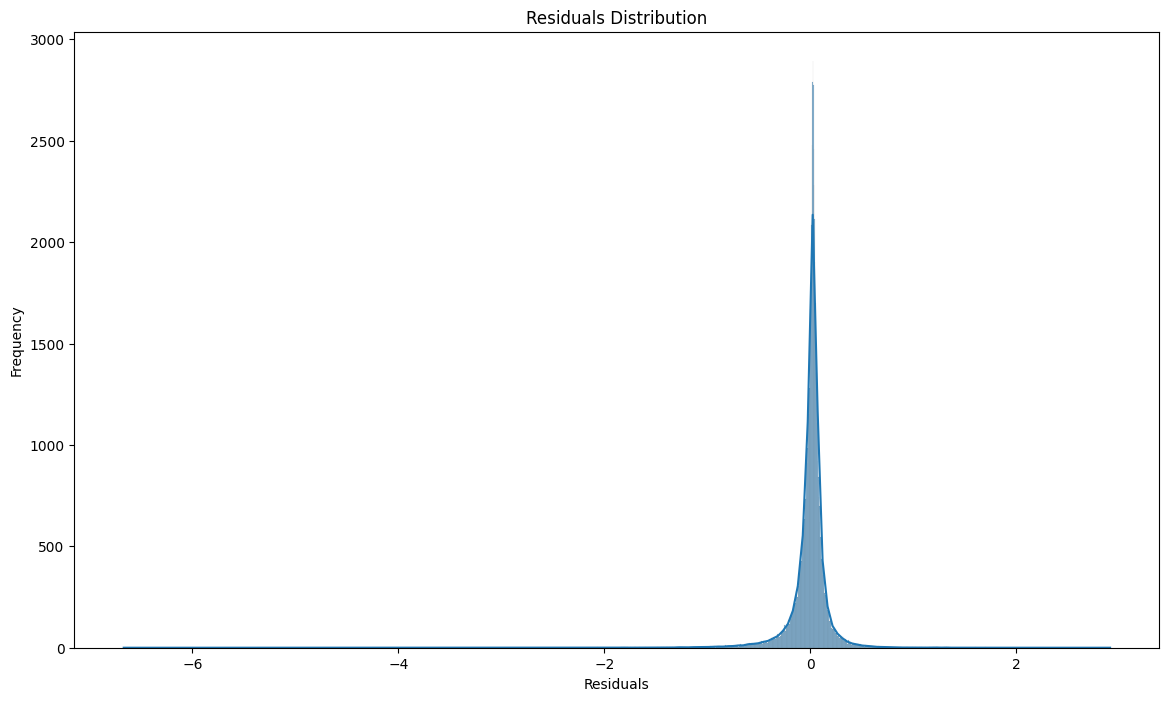

In [48]:
xgb_residuals = calculate_error(y_pred, y_test)
plot_error_distribution(xgb_residuals)

In [17]:
# prepare the prediction dataframe with household and testing data
xgb_pred_by_household = pd.DataFrame(np.hstack([y_pred.reshape(-1, 1), y_test_with_ids[['household_ids', 'y_test']].to_numpy().reshape(-1, 2)]), columns=['y_pred', 'household_id', 'y_test'])
xgb_pred_by_household['household_id'] = xgb_pred_by_household['household_id'].astype('int8')

# prepare the household grp
xgb_hhgrp = xgb_pred_by_household.groupby('household_id')

# calculate the metrics for each individual group
xgb_metrics = xgb_hhgrp.apply(lambda x: mean_squared_error(x['y_test'], x['y_pred'])).reset_index()
xgb_metrics['rmse'] = xgb_hhgrp.apply(lambda x: mean_squared_error(x['y_test'], x['y_pred'], squared=False)).values
xgb_metrics['mae'] = xgb_hhgrp.apply(lambda x: mean_absolute_error(x['y_test'], x['y_pred'])).values
xgb_metrics['mape'] = xgb_hhgrp.apply(lambda x: mean_absolute_percentage_error(x['y_test'], x['y_pred'])).values
xgb_metrics['r2'] = xgb_hhgrp.apply(lambda x: r2_score(x['y_test'], x['y_pred'])).values
xgb_metrics['adjusted_r2'] = xgb_hhgrp.apply(lambda x: adjusted_r2(x['y_test'], x['y_pred'])).values
xgb_metrics = xgb_metrics.rename(columns={ 0: 'mse'})


<Figure size 1400x800 with 0 Axes>

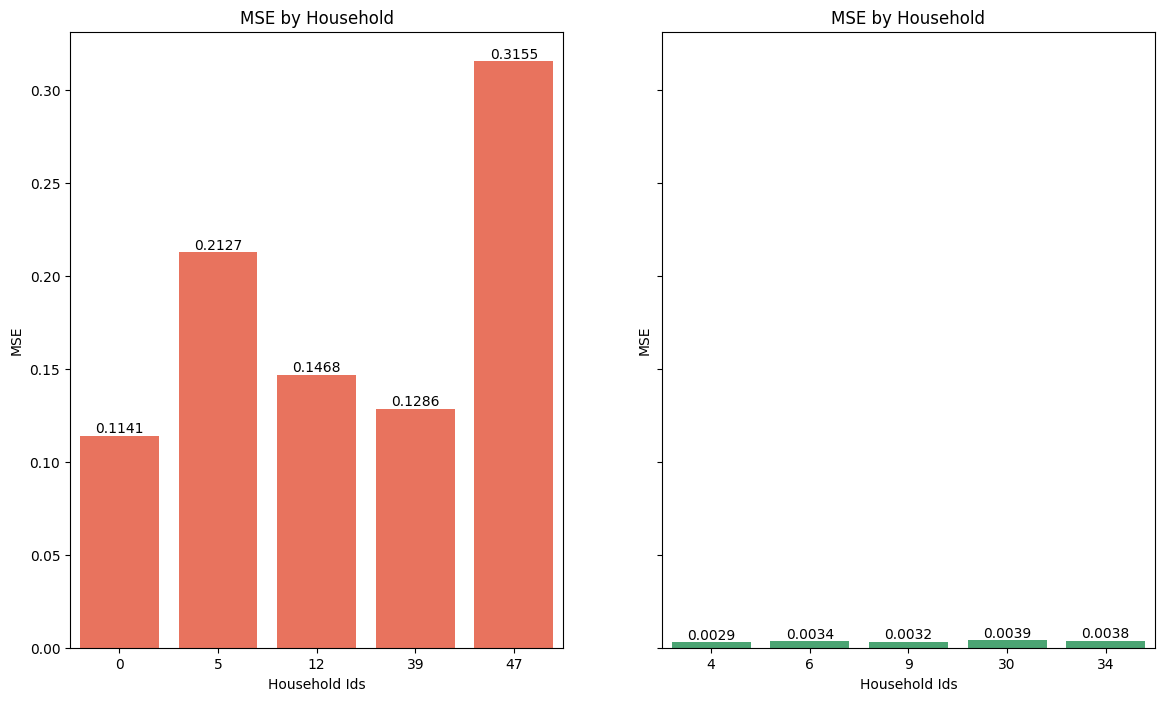

In [154]:
top5_metric = xgb_metrics.sort_values(by='mse', ascending=False).head(5)
bottom5_metric = xgb_metrics.sort_values(by='mse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mse')

<Figure size 1400x800 with 0 Axes>

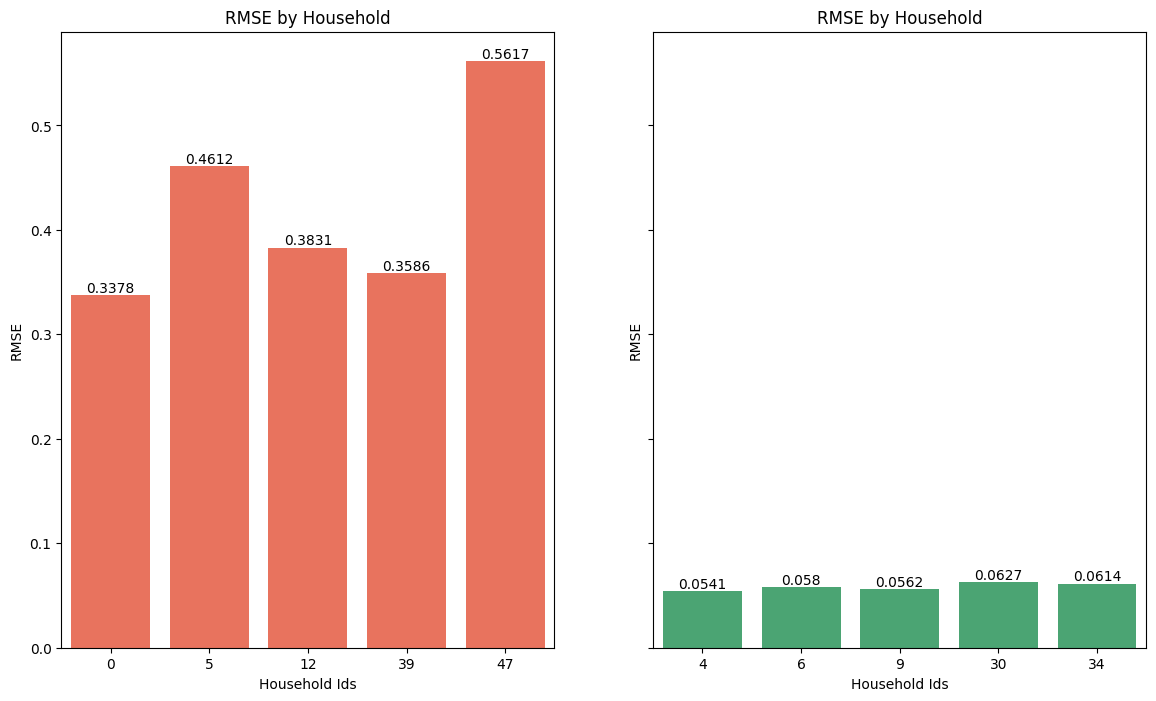

In [155]:
top5_metric = xgb_metrics.sort_values(by='rmse', ascending=False).head(5)
bottom5_metric = xgb_metrics.sort_values(by='rmse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'rmse')

<Figure size 1400x800 with 0 Axes>

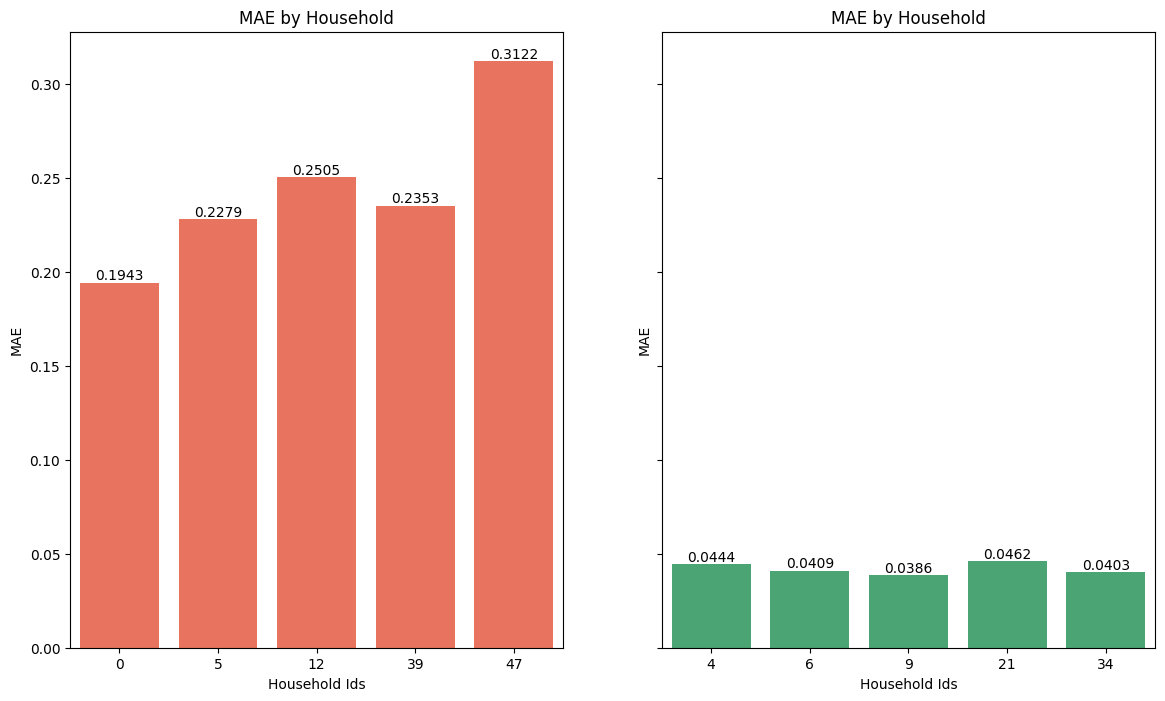

In [156]:
top5_metric = xgb_metrics.sort_values(by='mae', ascending=False).head(5)
bottom5_metric = xgb_metrics.sort_values(by='mae', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mae')

<Figure size 1400x800 with 0 Axes>

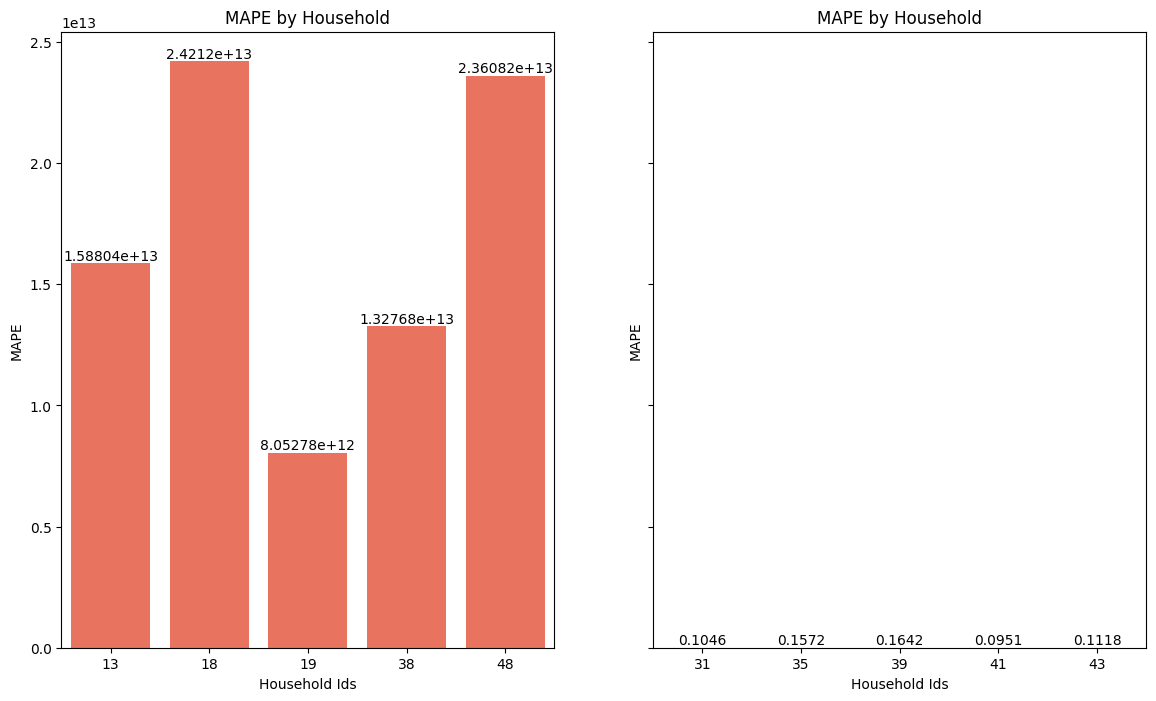

In [157]:
top5_metric = xgb_metrics.sort_values(by='mape', ascending=False).head(5)
bottom5_metric = xgb_metrics.sort_values(by='mape', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mape')

<Figure size 1400x800 with 0 Axes>

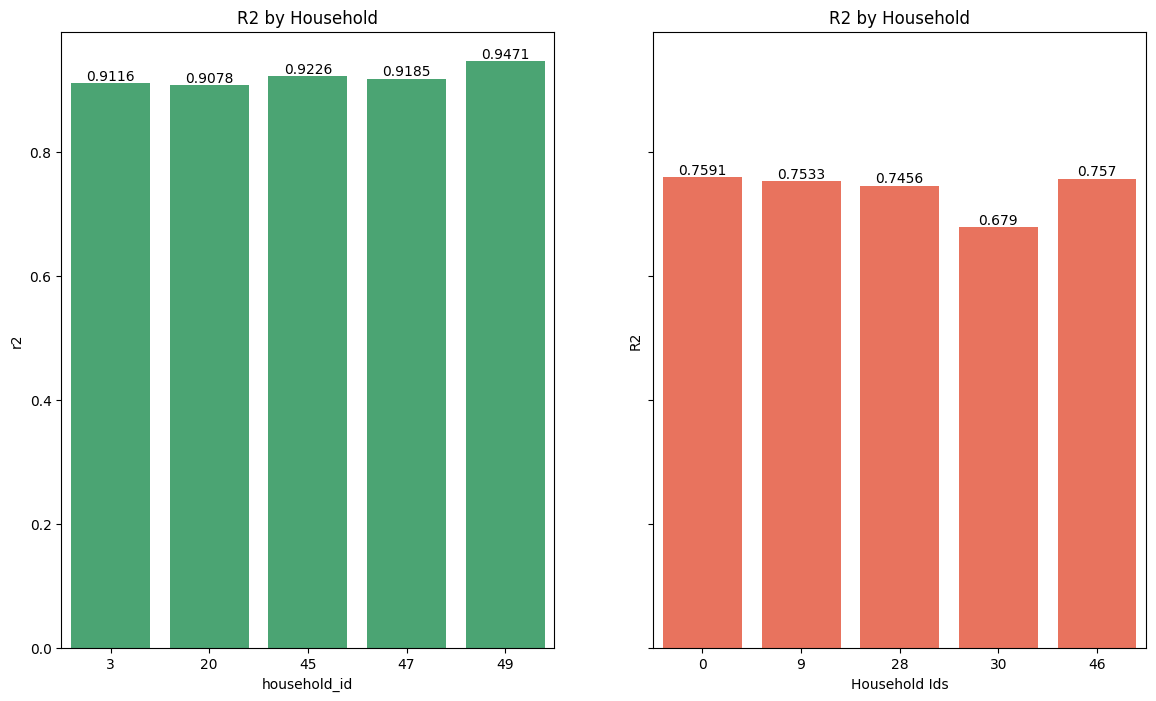

In [158]:
top5_metric = xgb_metrics.sort_values(by='r2', ascending=False).head(5)
bottom5_metric = xgb_metrics.sort_values(by='r2', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'r2')

<Figure size 1400x800 with 0 Axes>

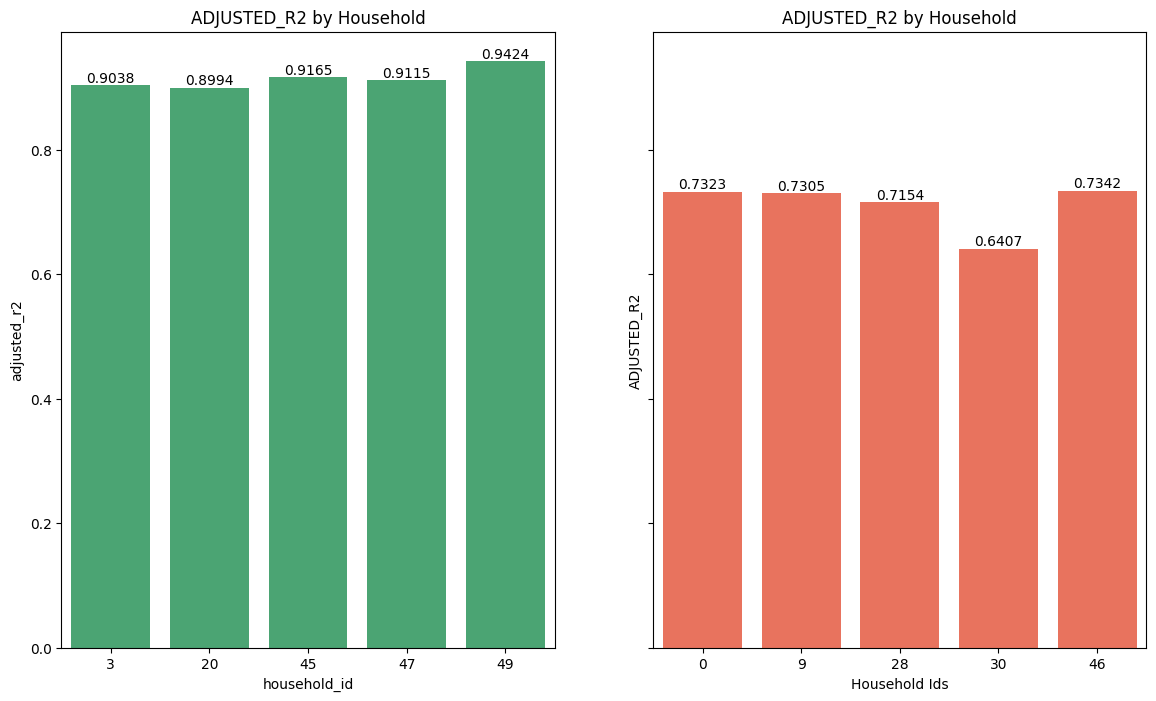

In [159]:
top5_metric = xgb_metrics.sort_values(by='adjusted_r2', ascending=False).head(5)
bottom5_metric = xgb_metrics.sort_values(by='adjusted_r2', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'adjusted_r2')

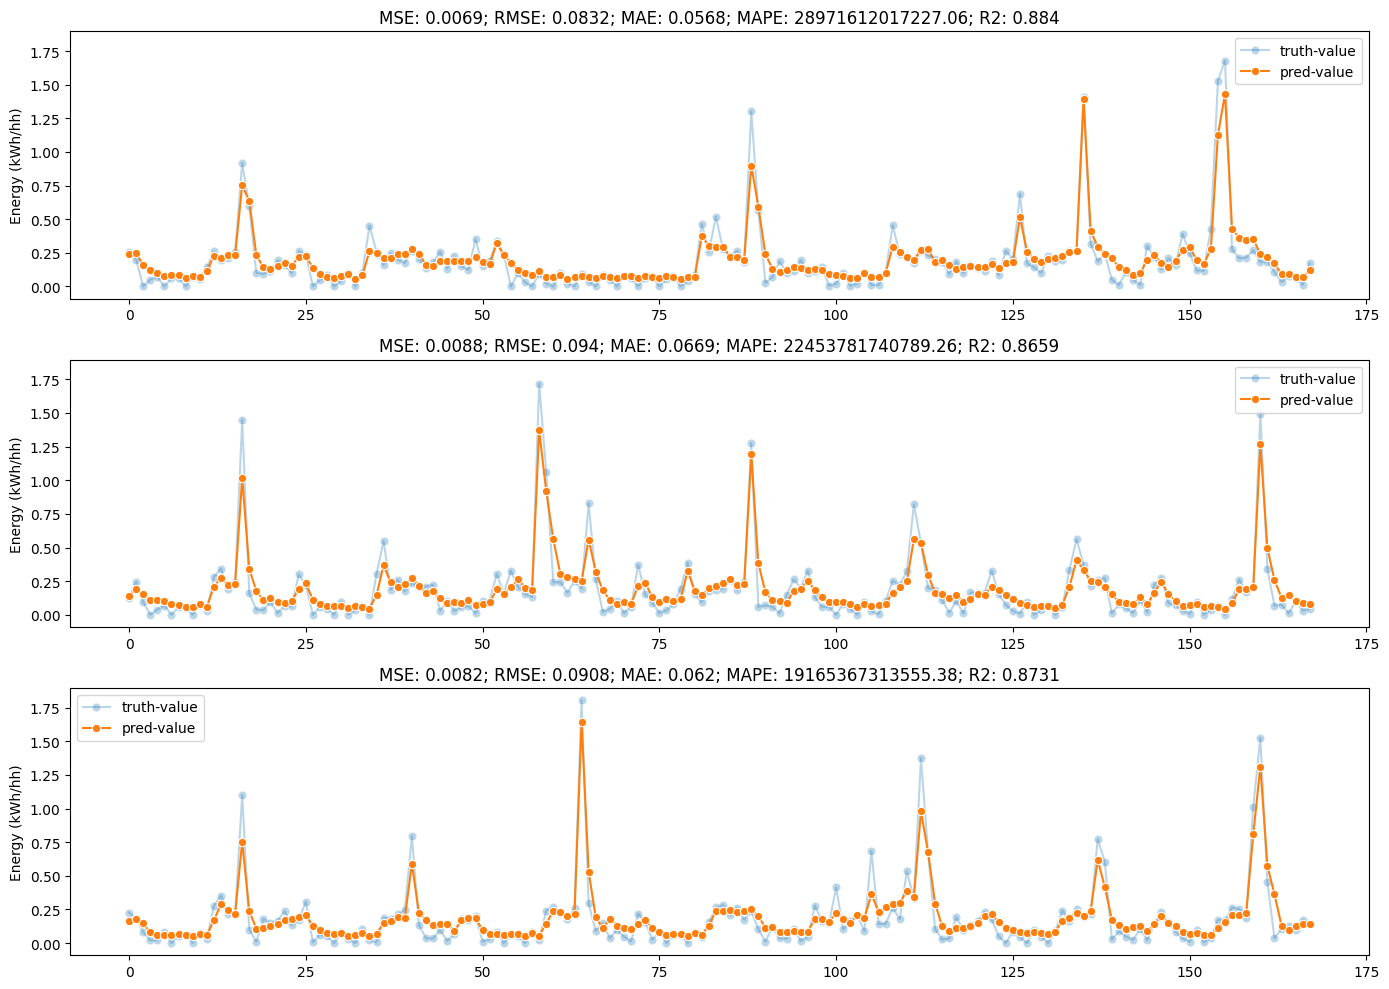

In [18]:
filtered_data = xgb_pred_by_household.loc[xgb_pred_by_household['household_id'] == 18]
plot_forecast(filtered_data['y_pred'], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

### Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor

# reshape back to the original shape for XGBoost
ml_train = X_train.reshape(X_train.shape[0], X_train.shape[2]) 
ml_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

hyperparams = {'max_depth': 9, 'min_samples_split': 3, 'n_estimators': 506}
rf_model = RandomForestRegressor(random_state=42, n_jobs=5, **hyperparams) # uses 5 CPU cores
rf_model.fit(ml_train, y_train)

RandomForestRegressor(max_depth=9, min_samples_split=3, n_estimators=506,
                      n_jobs=5, random_state=42)

In [21]:
y_pred = rf_model.predict(ml_test)

evaluate_model(y_pred, y_test, deep_learning=False)

RMSE: 0.2684231264957902
MSE: 0.07205097483777498
MAE: 0.14189245570807324
MAPE: 0.29791272322125645
R2 Score: 0.7636350716870628
Adjusted R2 Score: 0.7632193077018444


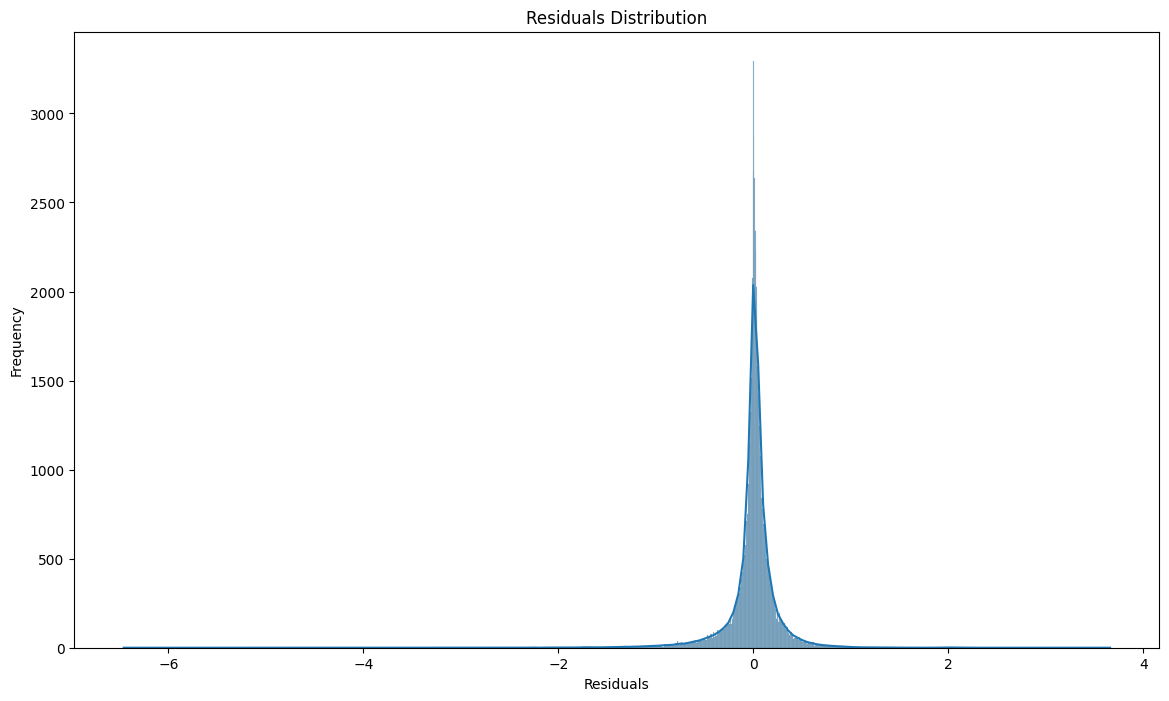

In [22]:
rf_residuals = calculate_error(y_pred, y_test)

plot_error_distribution(rf_residuals)

In [23]:
# prepare the prediction dataframe with household and testing data
rf_pred_by_household = pd.DataFrame(np.hstack([y_pred.reshape(-1, 1), y_test_with_ids[['household_ids', 'y_test']].to_numpy().reshape(-1, 2)]), columns=['y_pred', 'household_id', 'y_test'])
rf_pred_by_household['household_id'] = rf_pred_by_household['household_id'].astype('int8')

# prepare the household grp
rf_hhgroup = rf_pred_by_household.groupby('household_id')

# calculate the metrics for each individual group
rf_metrics = rf_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['y_pred'])).reset_index()
rf_metrics['rmse'] = rf_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['y_pred'], squared=False)).values
rf_metrics['mae'] = rf_hhgroup.apply(lambda x: mean_absolute_error(x['y_test'], x['y_pred'])).values
rf_metrics['mape'] = rf_hhgroup.apply(lambda x: mean_absolute_percentage_error(x['y_test'], x['y_pred'])).values
rf_metrics['r2'] = rf_hhgroup.apply(lambda x: r2_score(x['y_test'], x['y_pred'])).values
rf_metrics['adjusted_r2'] = rf_hhgroup.apply(lambda x: adjusted_r2(x['y_test'], x['y_pred'])).values
rf_metrics = rf_metrics.rename(columns={ 0: 'mse'})


<Figure size 1400x800 with 0 Axes>

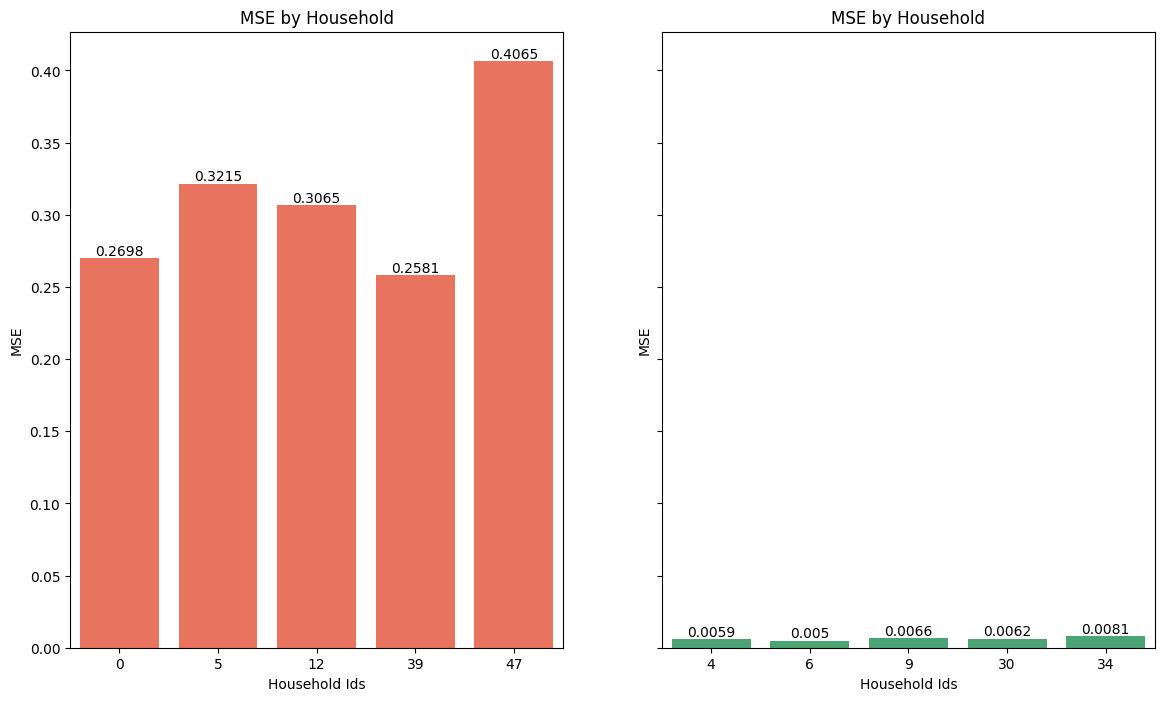

In [25]:
top5_metric = rf_metrics.sort_values(by='mse', ascending=False).head(5)
bottom5_metric = rf_metrics.sort_values(by='mse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mse')

<Figure size 1400x800 with 0 Axes>

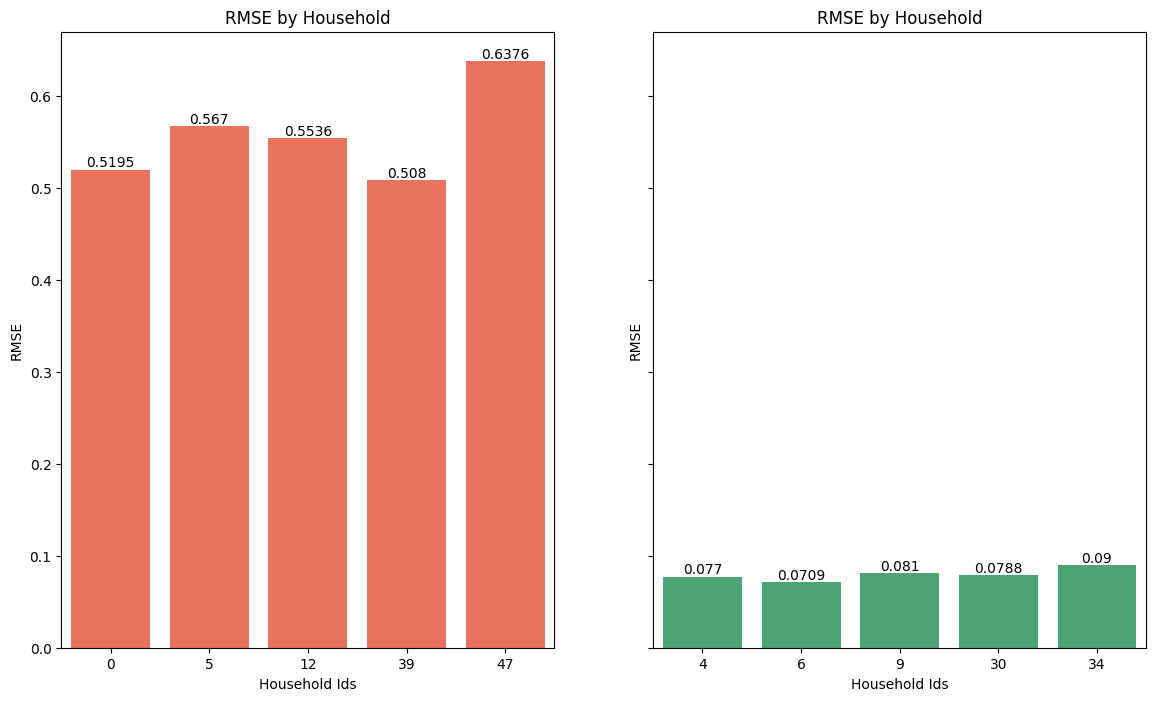

In [26]:
top5_metric = rf_metrics.sort_values(by='rmse', ascending=False).head(5)
bottom5_metric = rf_metrics.sort_values(by='rmse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'rmse')

<Figure size 1400x800 with 0 Axes>

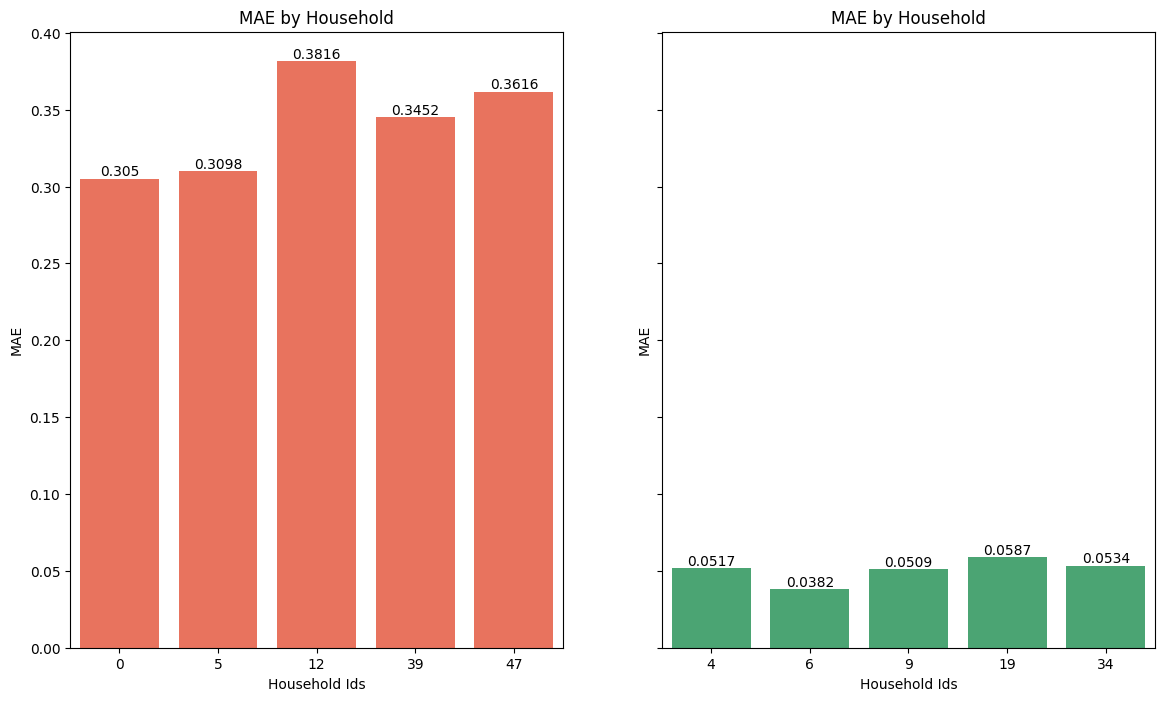

In [27]:
top5_metric = rf_metrics.sort_values(by='mae', ascending=False).head(5)
bottom5_metric = rf_metrics.sort_values(by='mae', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mae')

<Figure size 1400x800 with 0 Axes>

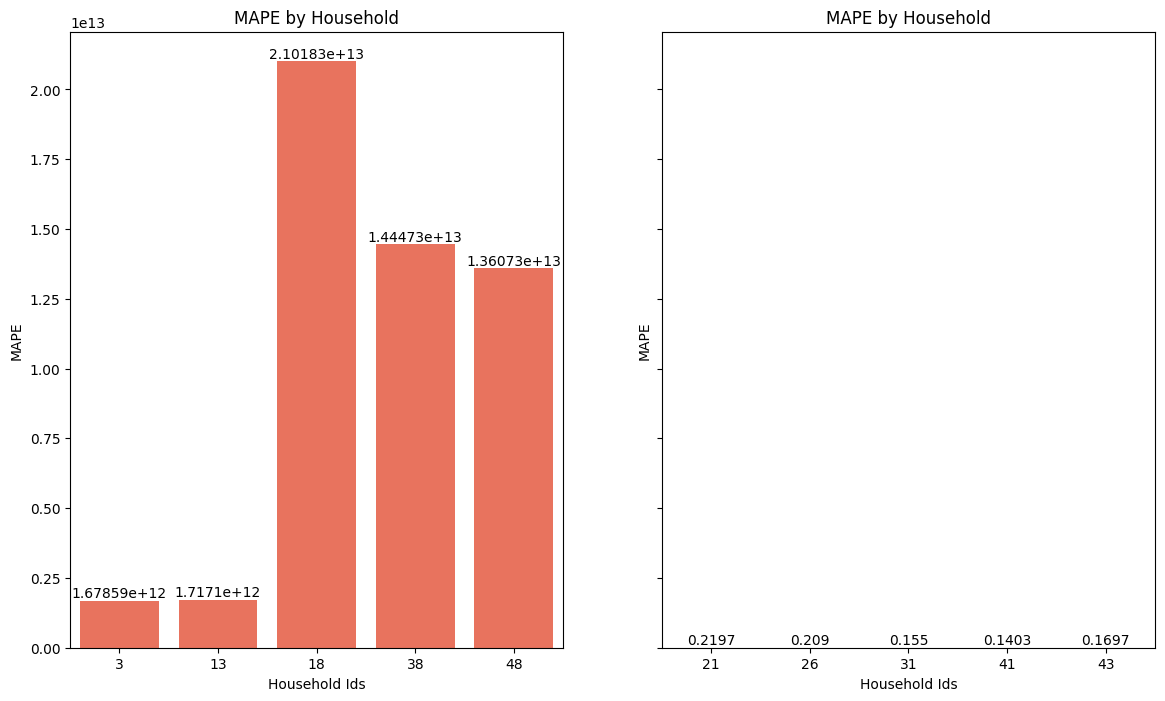

In [28]:
top5_metric = rf_metrics.sort_values(by='mape', ascending=False).head(5)
bottom5_metric = rf_metrics.sort_values(by='mape', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mape')

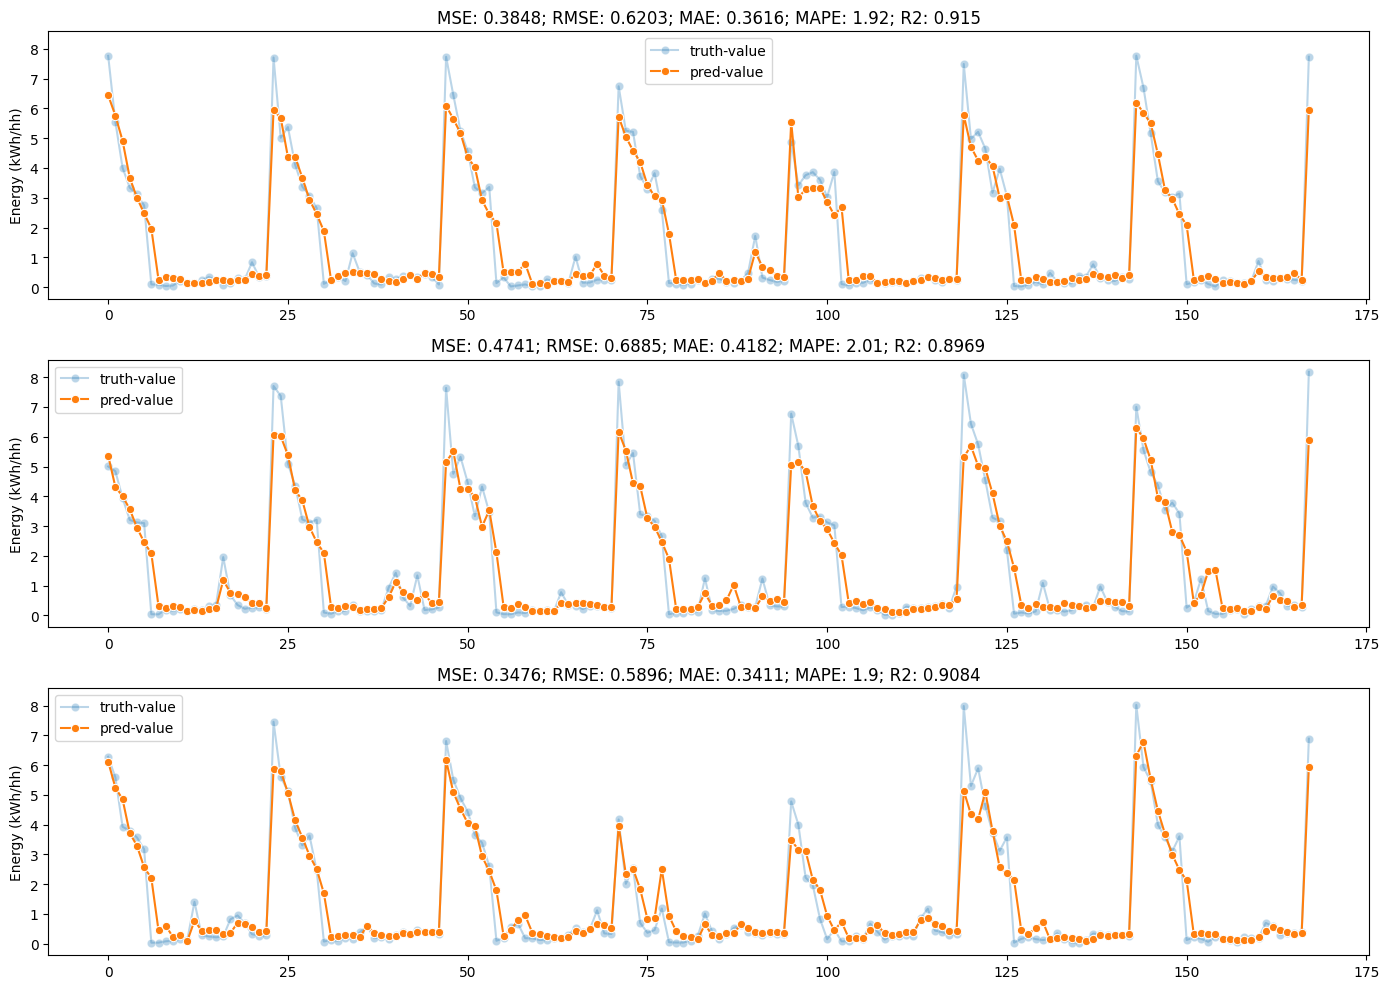

In [32]:
filtered_data = rf_pred_by_household.loc[rf_pred_by_household['household_id'] == 47]
plot_forecast(filtered_data['y_pred'], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

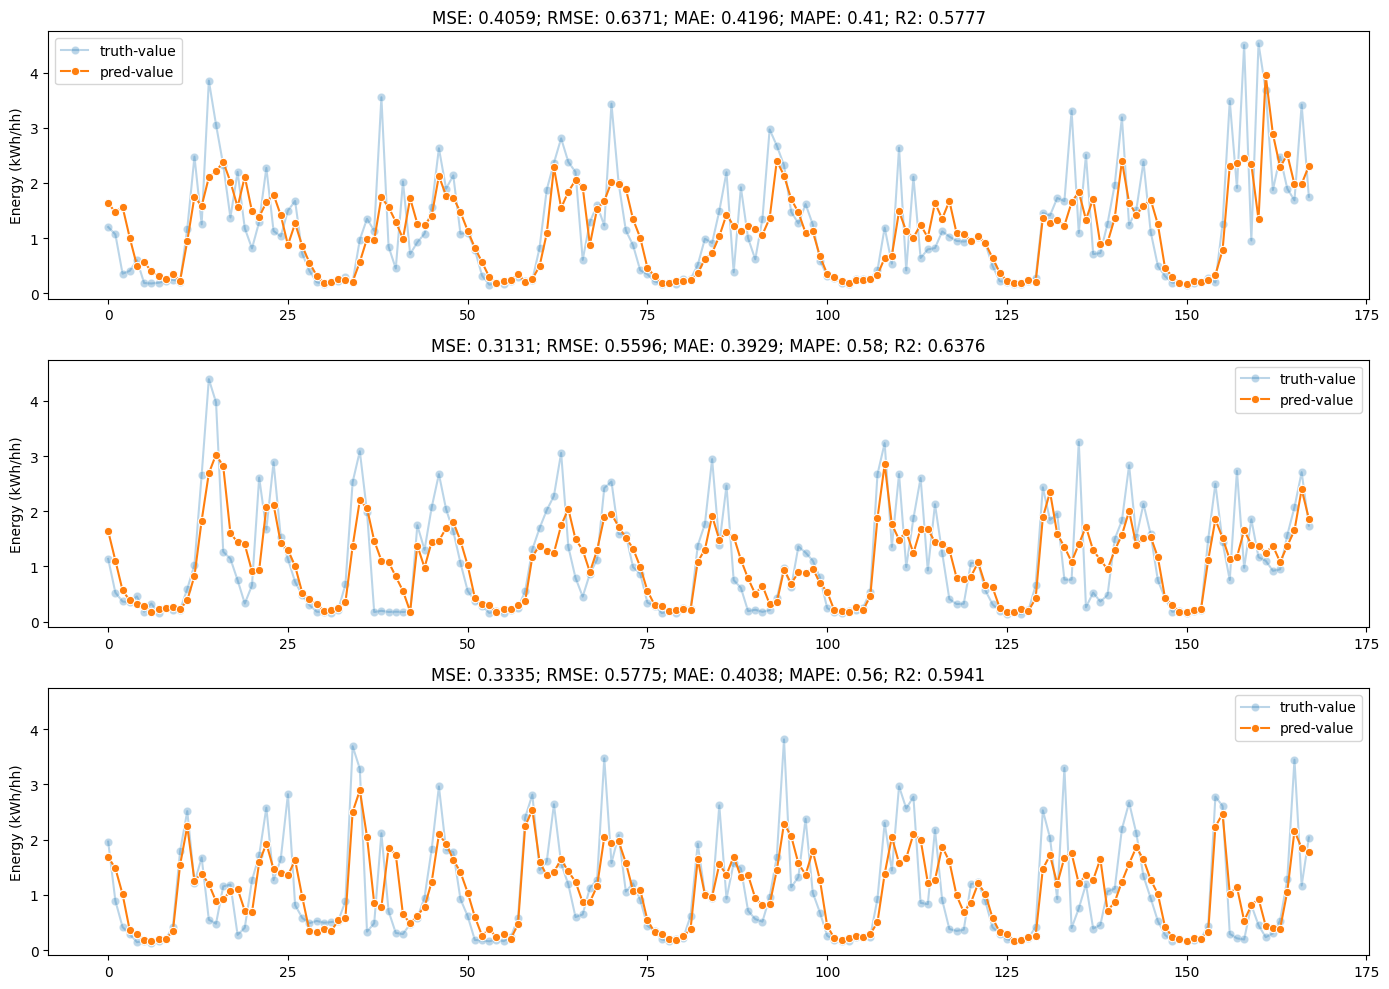

In [33]:
filtered_data = rf_pred_by_household.loc[rf_pred_by_household['household_id'] == 12]
plot_forecast(filtered_data['y_pred'], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

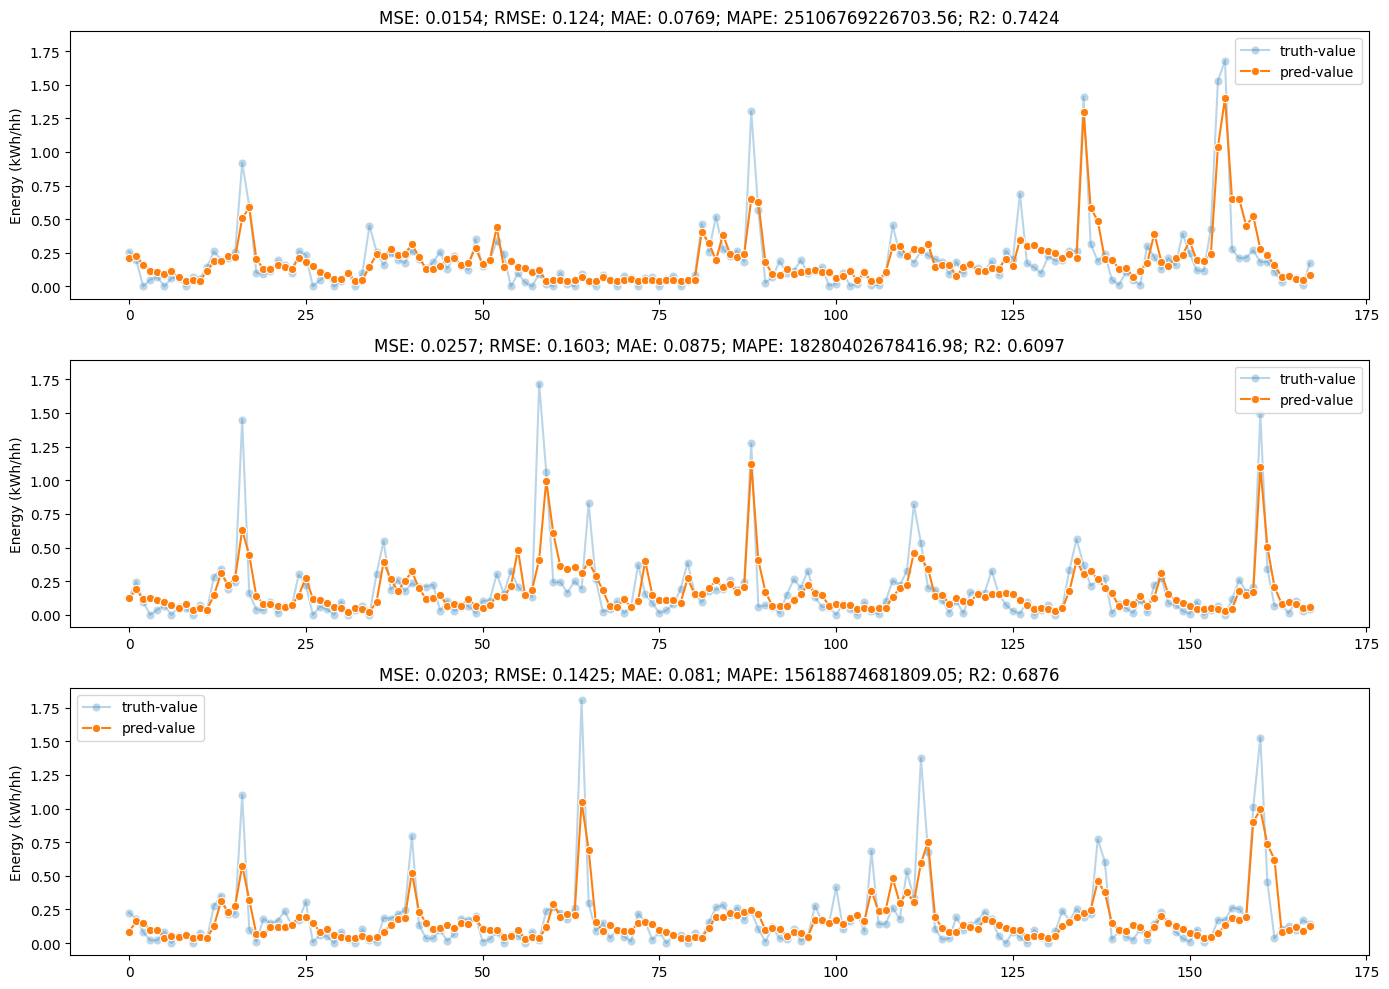

In [30]:
filtered_data = rf_pred_by_household.loc[rf_pred_by_household['household_id'] == 18]
plot_forecast(filtered_data['y_pred'], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

### LSTM

In [31]:
# Train with the best hyperparameter set
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, LSTM,
    TimeDistributed, Dropout, Input
)

# for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=5, restore_best_weights=True)

# input 
input_layer = Input(shape=(1, X_train.shape[2]))

# stacked lstm
lstm1 = LSTM(200, return_sequences=True)(input_layer)
lstm2 = LSTM(200, return_sequences=True)(lstm1)
dropout1 = Dropout(0.2)(lstm2)

# full connected layer
fc1 = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(dropout1)
fc2 = TimeDistributed(Dense(64, activation='relu'))(fc1)

# output
output_layer = TimeDistributed(Dense(1))(fc2)  
model = Model(inputs=input_layer, outputs=output_layer)


model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['mae', 'mse', 'mape']
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=168,
    callbacks=[earlystop]
)

Epoch 1/50
4087/4087 [==============================] - 32s 7ms/step - loss: 2.4158 - mae: 0.2067 - mse: 0.1395 - mape: 1375725.0000 - val_loss: 0.1523 - val_mae: 0.1827 - val_mse: 0.1256 - val_mape: 559695.2500
Epoch 2/50
4087/4087 [==============================] - 29s 7ms/step - loss: 0.0965 - mae: 0.1441 - mse: 0.0741 - mape: 785554.0625 - val_loss: 0.0598 - val_mae: 0.1053 - val_mse: 0.0310 - val_mape: 337159.8750
Epoch 3/50
4087/4087 [==============================] - 29s 7ms/step - loss: 0.0295 - mae: 0.0494 - mse: 0.0068 - mape: 516746.5312 - val_loss: 0.0214 - val_mae: 0.0383 - val_mse: 0.0043 - val_mape: 366523.4688
Epoch 4/50
4087/4087 [==============================] - 30s 7ms/step - loss: 0.0184 - mae: 0.0363 - mse: 0.0037 - mape: 421660.7500 - val_loss: 0.0162 - val_mae: 0.0277 - val_mse: 0.0038 - val_mape: 310152.8750
Epoch 5/50
4087/4087 [==============================] - 30s 7ms/step - loss: 0.0158 - mae: 0.0347 - mse: 0.0036 - mape: 390530.6250 - val_loss: 0.0186 - va

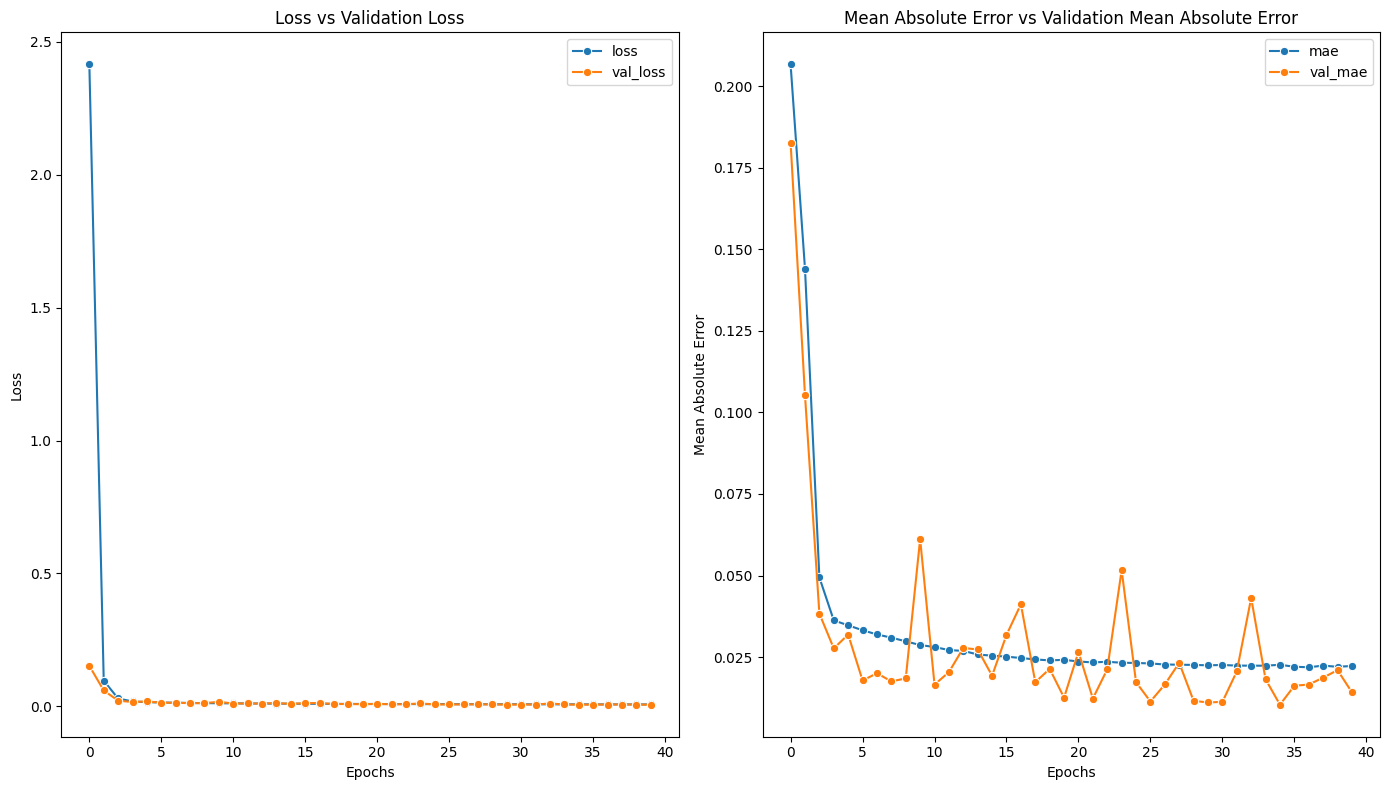

In [34]:
plot_training_metrics(history)

In [38]:
y_pred = model.predict(X_test)
residuals = calculate_error(y_pred.ravel(), y_test)

evaluate_model(y_pred, y_test, deep_learning=True)

2385/2385 [==============================] - 5s 2ms/step
RMSE: 0.01775156469606885
MSE: 0.000315118049158718
MAE: 0.01041872888666575
MAPE: 0.06058173309548854
R2 Score: 0.9992346351034682
Adjusted R2 Score: 0.9992332888328442


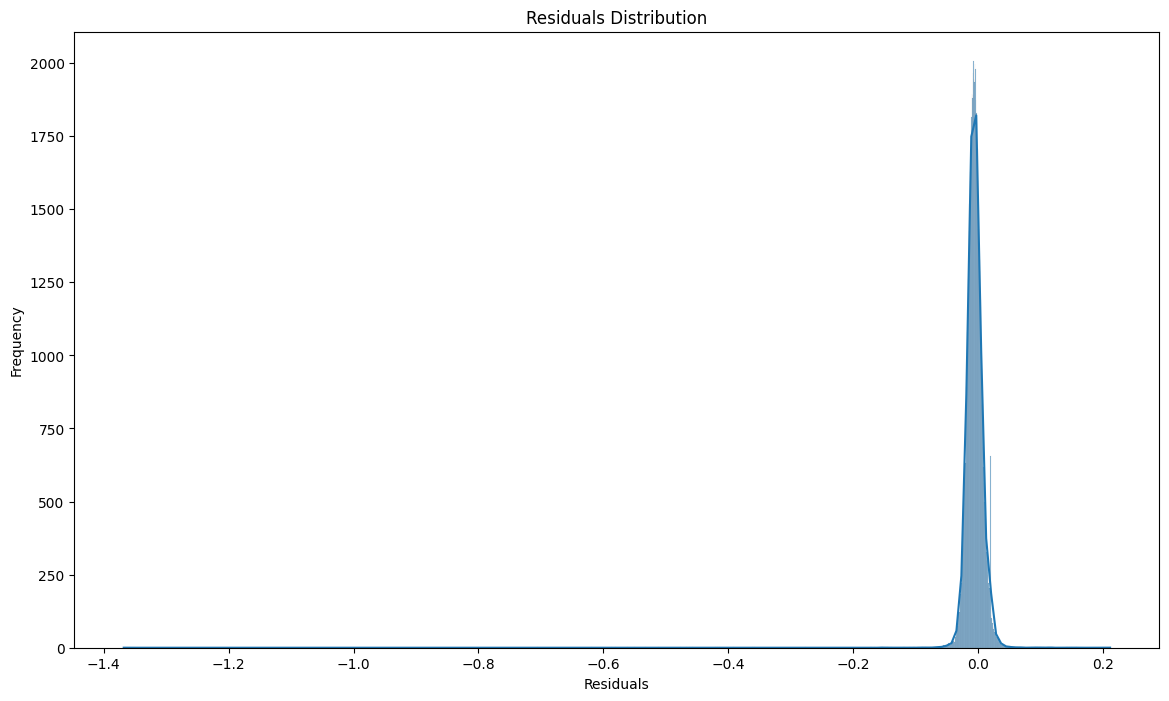

In [36]:
plot_error_distribution(residuals)

In [44]:
# prepare the prediction dataframe with household and testing data
lstm_pred_by_household = pd.DataFrame(np.hstack([y_pred.reshape(y_pred.shape[0], 1), y_test_with_ids[['household_ids', 'y_test']].to_numpy().reshape(-1, 2)]), columns=['y_pred', 'household_id', 'y_test'])
lstm_pred_by_household['household_id'] = lstm_pred_by_household['household_id'].astype('int8')

# prepare the household grp
lstm_hhgroup = lstm_pred_by_household.groupby('household_id')

# calculate the metrics for each individual group
lstm_metrics = lstm_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['y_pred'])).reset_index()
lstm_metrics['rmse'] = lstm_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['y_pred'], squared=False)).values
lstm_metrics['mae'] = lstm_hhgroup.apply(lambda x: mean_absolute_error(x['y_test'], x['y_pred'])).values
lstm_metrics['mape'] = lstm_hhgroup.apply(lambda x: mean_absolute_percentage_error(x['y_test'], x['y_pred'])).values
lstm_metrics['r2'] = lstm_hhgroup.apply(lambda x: r2_score(x['y_test'], x['y_pred'])).values
lstm_metrics['adjusted_r2'] = lstm_hhgroup.apply(lambda x: adjusted_r2(x['y_test'], x['y_pred'])).values
lstm_metrics = lstm_metrics.rename(columns={ 0: 'mse'})


<Figure size 1400x800 with 0 Axes>

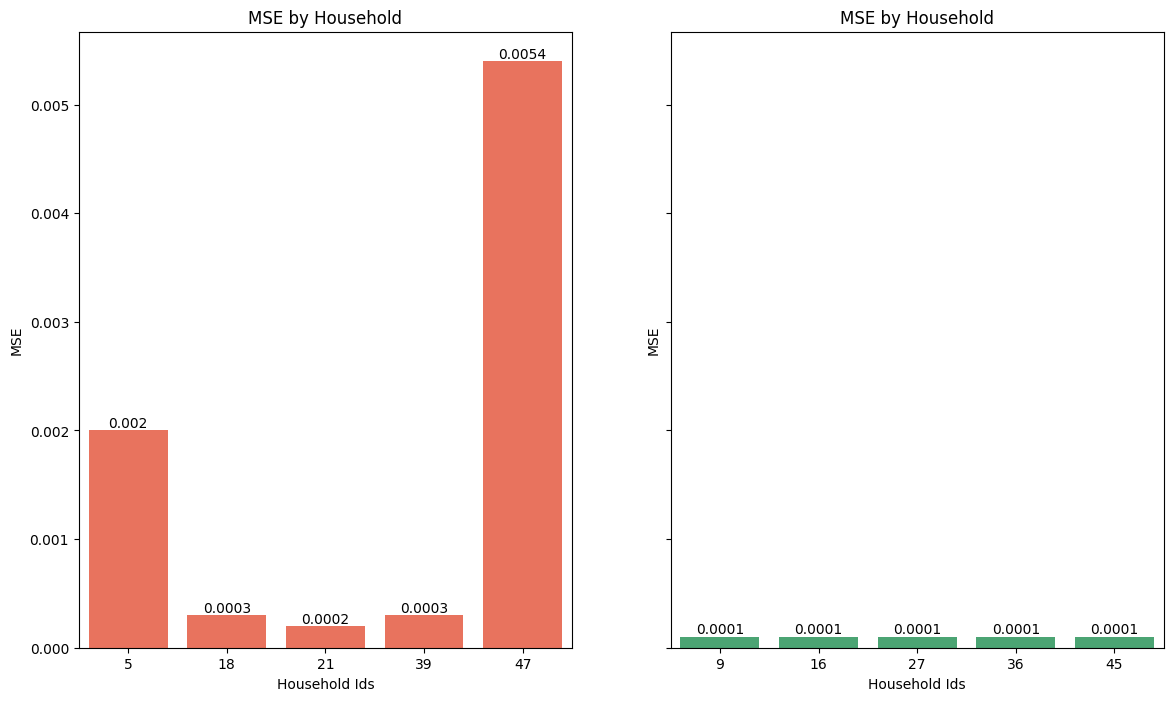

In [46]:
top5_metric = lstm_metrics.sort_values(by='mse', ascending=False).head(5)
bottom5_metric = lstm_metrics.sort_values(by='mse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mse')

<Figure size 1400x800 with 0 Axes>

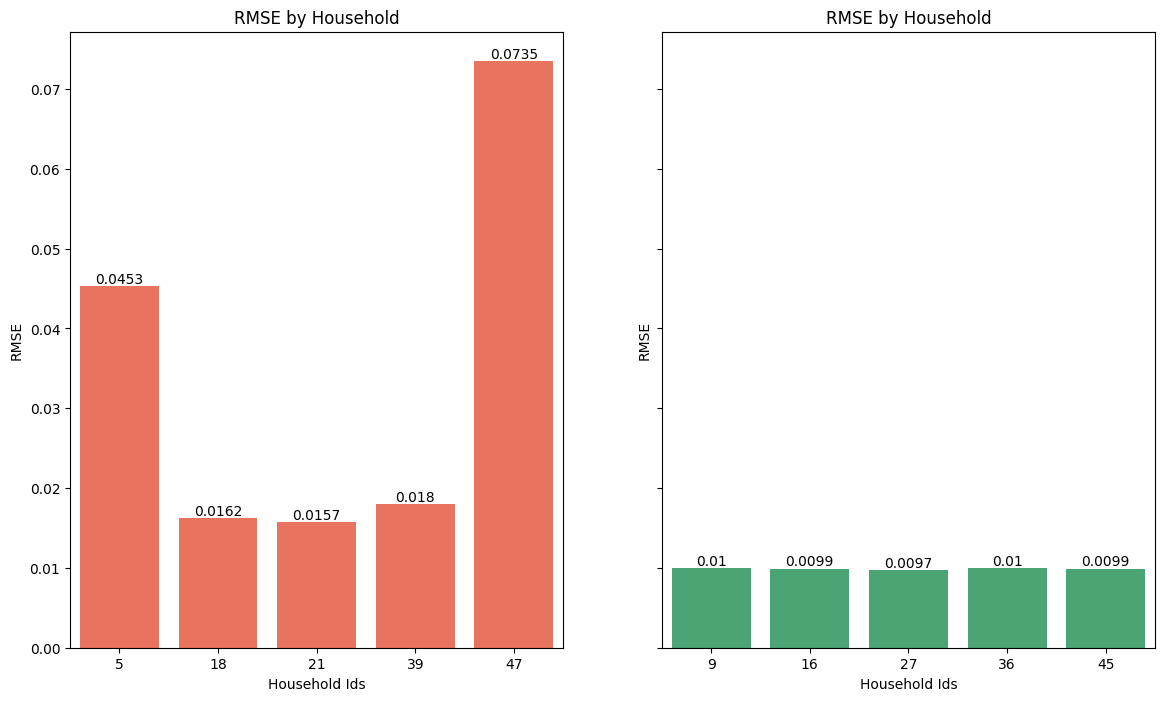

In [47]:
top5_metric = lstm_metrics.sort_values(by='rmse', ascending=False).head(5)
bottom5_metric = lstm_metrics.sort_values(by='rmse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'rmse')

<Figure size 1400x800 with 0 Axes>

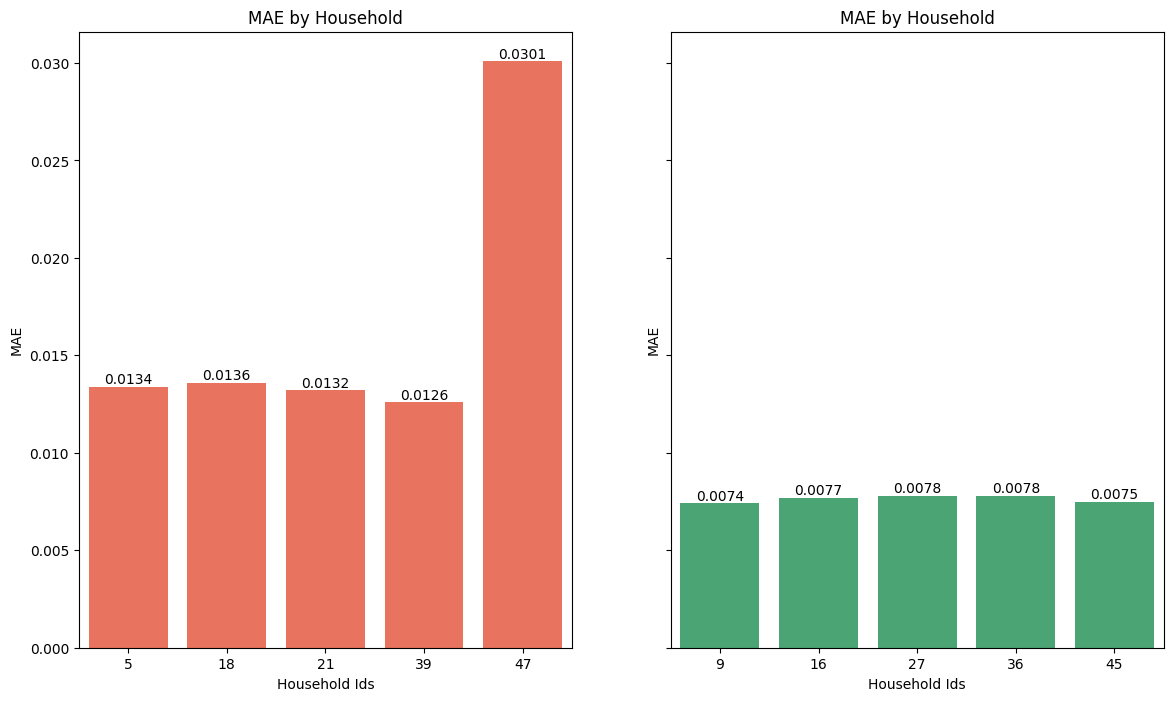

In [48]:
top5_metric = lstm_metrics.sort_values(by='mae', ascending=False).head(5)
bottom5_metric = lstm_metrics.sort_values(by='mae', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mae')

<Figure size 1400x800 with 0 Axes>

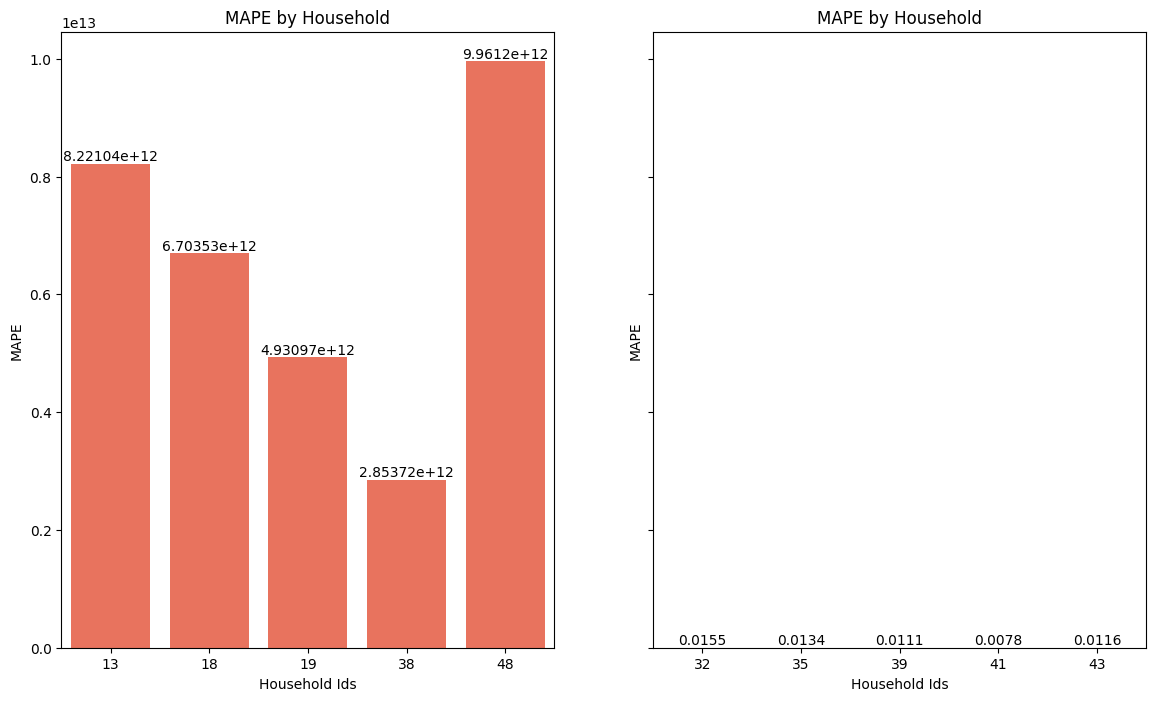

In [49]:
top5_metric = lstm_metrics.sort_values(by='mape', ascending=False).head(5)
bottom5_metric = lstm_metrics.sort_values(by='mape', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mape')

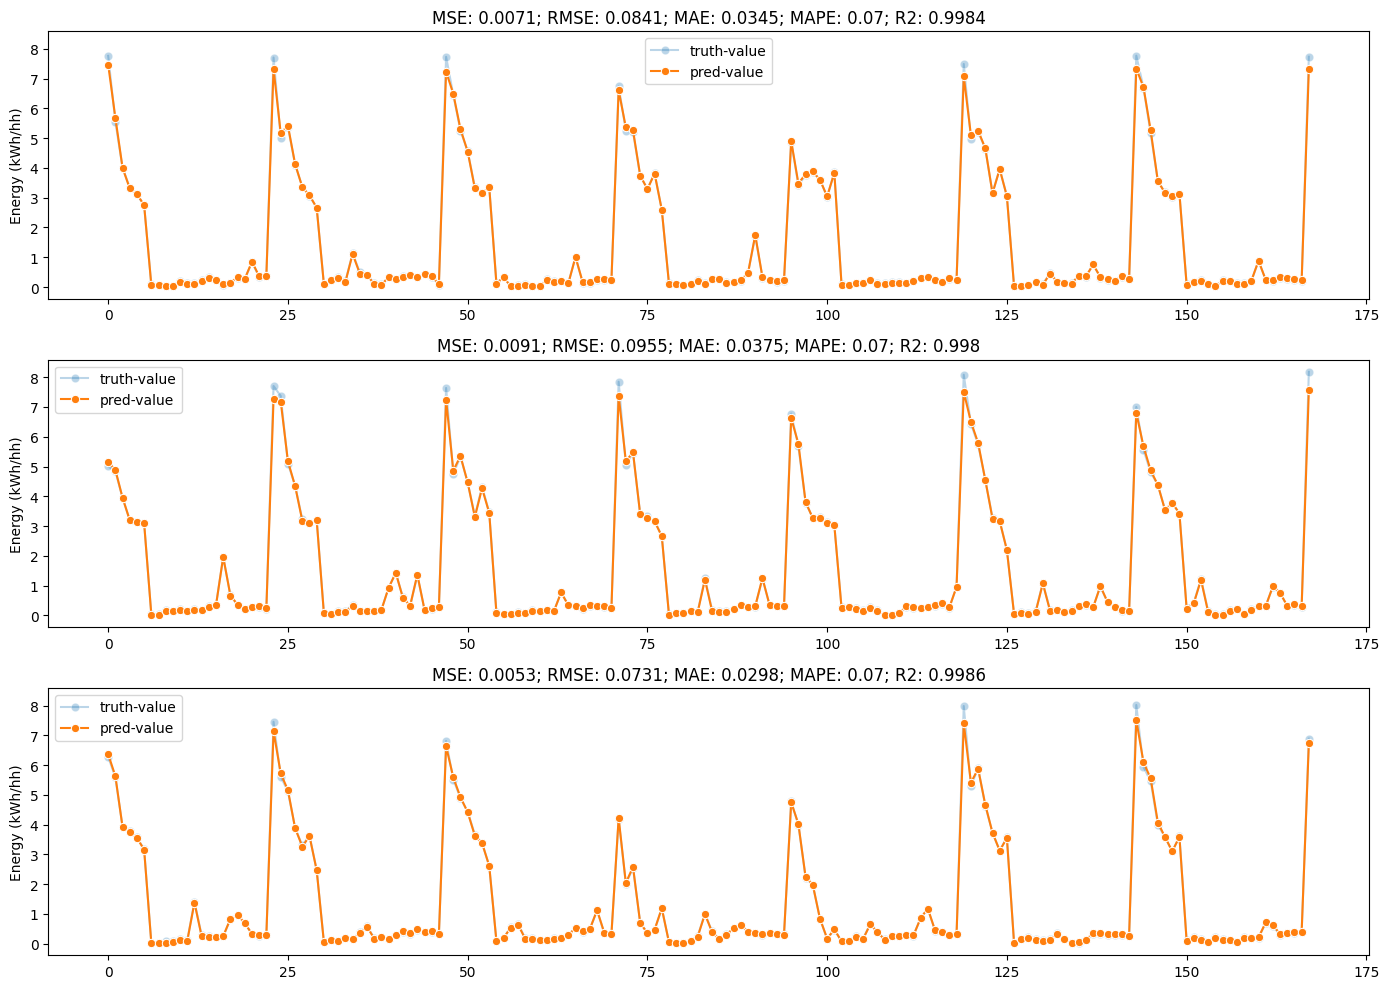

In [50]:
filtered_data = lstm_pred_by_household.loc[lstm_pred_by_household['household_id'] == 47]
plot_forecast(filtered_data['y_pred'], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

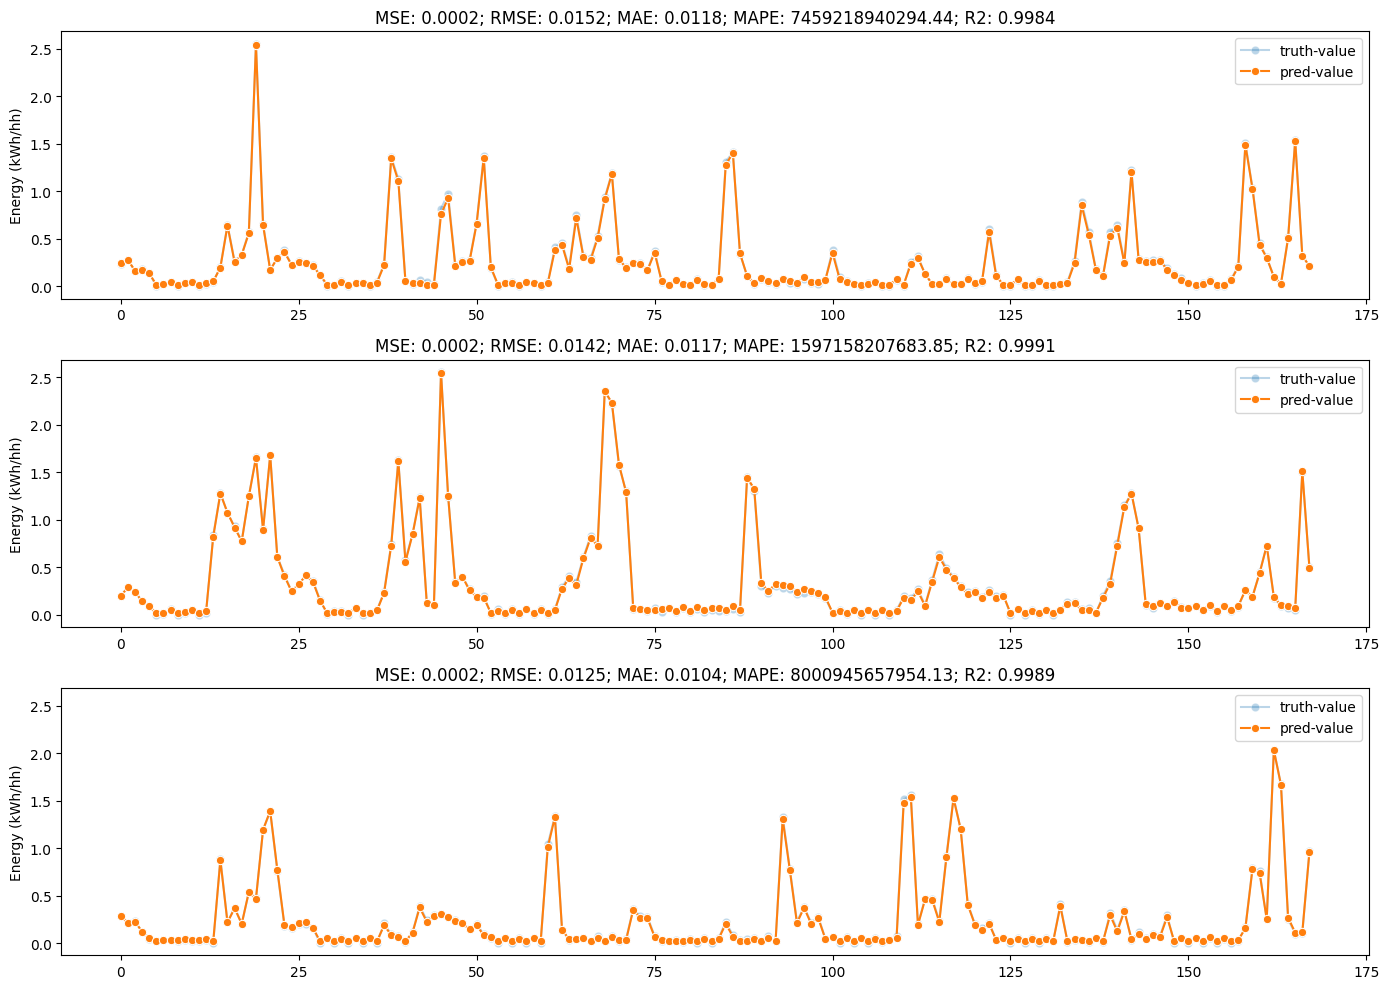

In [57]:
filtered_data = lstm_pred_by_household.loc[lstm_pred_by_household['household_id'] == 48]
plot_forecast(filtered_data['y_pred'], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

### CNN-LSTM

In [58]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Dense, LSTM, TimeDistributed, Conv1D, Dropout, Input
)

# for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_mse', patience=5, restore_best_weights=True)

input_layer = Input(shape=(1, X_train.shape[2]))
cnn1 = Conv1D(200, kernel_size=1)(input_layer)
lstm1 = LSTM(300, return_sequences=True)(cnn1)
dropout1 = Dropout(0.4)(lstm1)
fc1 = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(dropout1)
fc2 = TimeDistributed(Dense(64, activation='relu'))(fc1)
output_layer = TimeDistributed(Dense(1))(fc2)

model = Model(inputs=input_layer, outputs=output_layer)

model.compile(
    loss=tf.keras.losses.MSE,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics=['mae', 'mse', 'mape']
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=168,
    callbacks=[earlystop]
)

Epoch 1/50
4087/4087 [==============================] - 27s 6ms/step - loss: 2.8210 - mae: 0.2052 - mse: 0.1361 - mape: 1351935.0000 - val_loss: 0.1563 - val_mae: 0.1840 - val_mse: 0.1251 - val_mape: 557473.5000
Epoch 2/50
4087/4087 [==============================] - 25s 6ms/step - loss: 0.1052 - mae: 0.1536 - mse: 0.0801 - mape: 844080.6250 - val_loss: 0.0721 - val_mae: 0.1123 - val_mse: 0.0428 - val_mape: 564332.2500
Epoch 3/50
4087/4087 [==============================] - 26s 6ms/step - loss: 0.0386 - mae: 0.0699 - mse: 0.0125 - mape: 680875.8750 - val_loss: 0.0258 - val_mae: 0.0448 - val_mse: 0.0048 - val_mape: 456927.1562
Epoch 4/50
4087/4087 [==============================] - 25s 6ms/step - loss: 0.0236 - mae: 0.0471 - mse: 0.0051 - mape: 555442.3125 - val_loss: 0.0196 - val_mae: 0.0393 - val_mse: 0.0040 - val_mape: 501743.4375
Epoch 5/50
4087/4087 [==============================] - 25s 6ms/step - loss: 0.0198 - mae: 0.0411 - mse: 0.0043 - mape: 480996.8750 - val_loss: 0.0268 - va

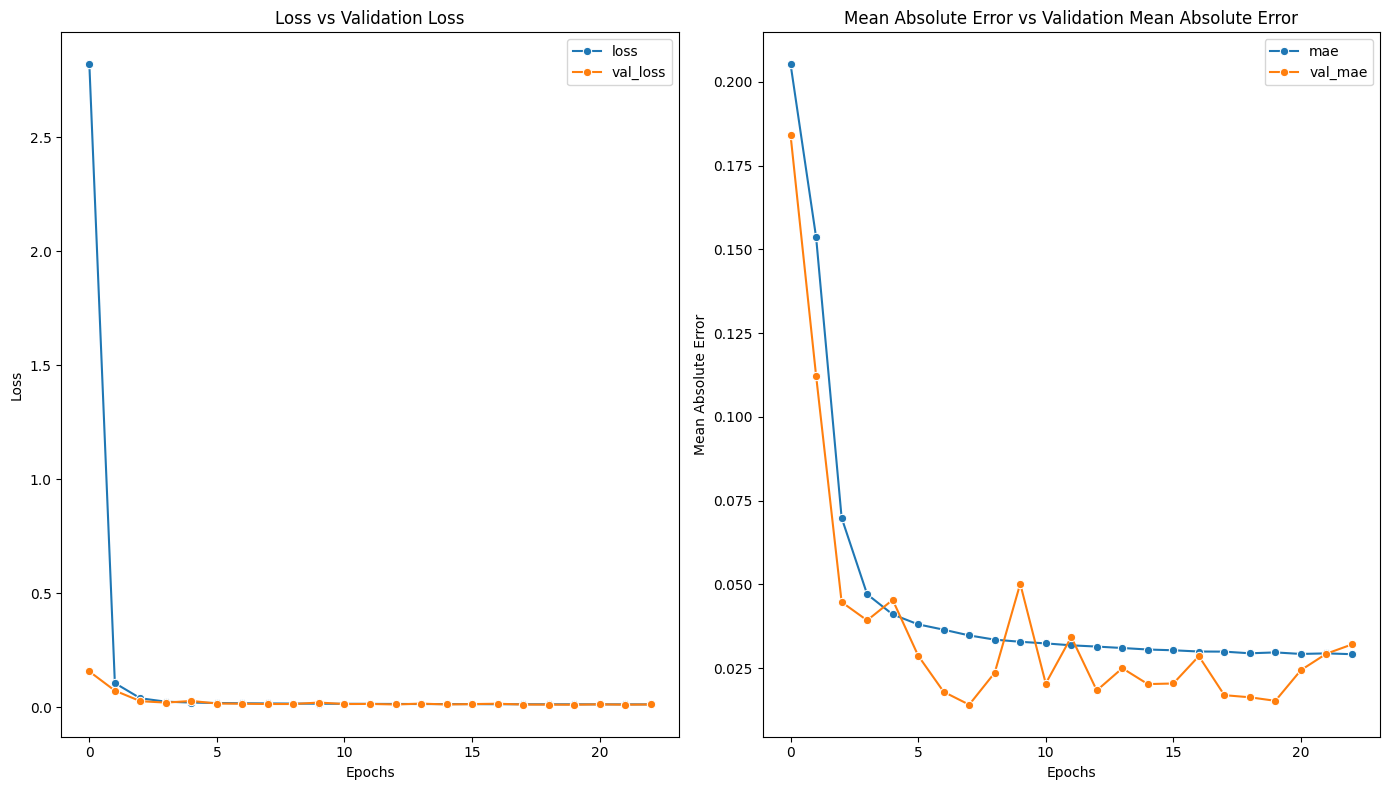

In [59]:
plot_training_metrics(history)

In [61]:
y_pred = model.predict(X_test)
residuals = calculate_error(y_pred.ravel(), y_test)

evaluate_model(y_pred, y_test, deep_learning=True)

2385/2385 [==============================] - 5s 2ms/step
RMSE: 0.033700207788475996
MSE: 0.0011357040049864583
MAE: 0.016969895387108105
MAPE: 0.07952613727916608
R2 Score: 0.9972551650663907
Adjusted R2 Score: 0.9972503369240816


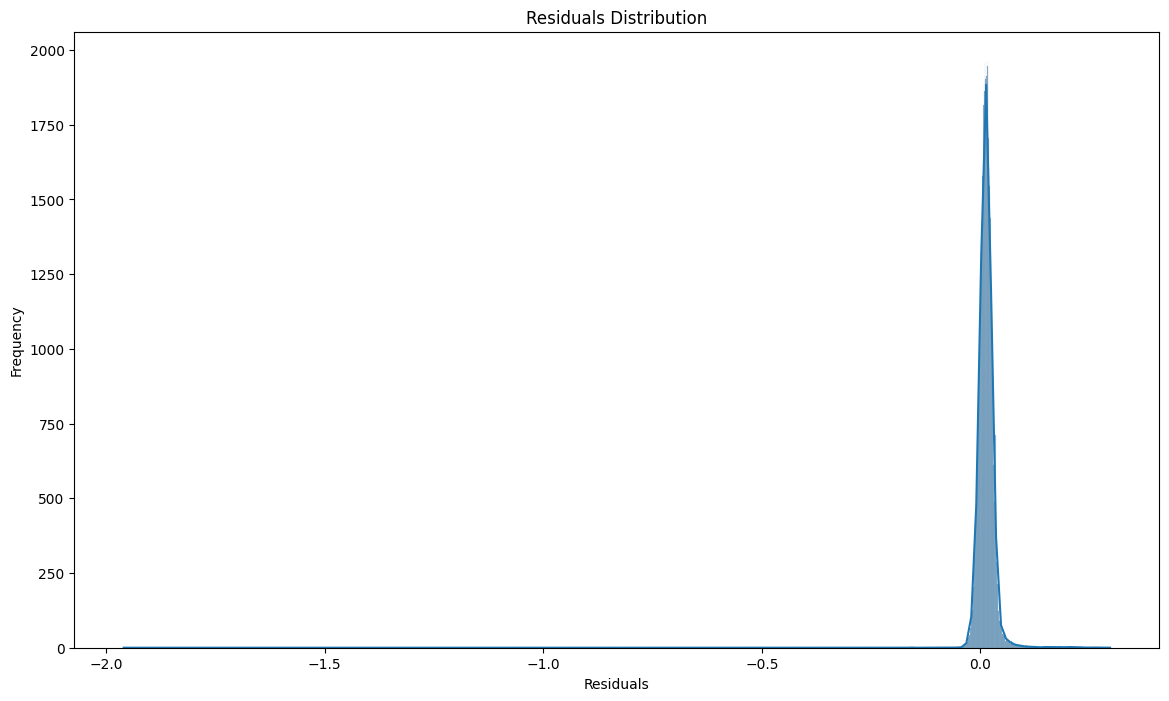

In [62]:
plot_error_distribution(residuals)

In [63]:
# prepare the prediction dataframe with household and testing data
cnnlstm_pred_by_household = pd.DataFrame(np.hstack([y_pred.reshape(y_pred.shape[0], 1), y_test_with_ids[['household_ids', 'y_test']].to_numpy().reshape(-1, 2)]), columns=['y_pred', 'household_id', 'y_test'])
cnnlstm_pred_by_household['household_id'] = cnnlstm_pred_by_household['household_id'].astype('int8')

# prepare the household grp
cnnlstm_hhgroup = cnnlstm_pred_by_household.groupby('household_id')

# calculate the metrics for each individual group
cnnlstm_metrics = cnnlstm_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['y_pred'])).reset_index()
cnnlstm_metrics['rmse'] = cnnlstm_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['y_pred'], squared=False)).values
cnnlstm_metrics['mae'] = cnnlstm_hhgroup.apply(lambda x: mean_absolute_error(x['y_test'], x['y_pred'])).values
cnnlstm_metrics['mape'] = cnnlstm_hhgroup.apply(lambda x: mean_absolute_percentage_error(x['y_test'], x['y_pred'])).values
cnnlstm_metrics['r2'] = cnnlstm_hhgroup.apply(lambda x: r2_score(x['y_test'], x['y_pred'])).values
cnnlstm_metrics['adjusted_r2'] = cnnlstm_hhgroup.apply(lambda x: adjusted_r2(x['y_test'], x['y_pred'])).values
cnnlstm_metrics = cnnlstm_metrics.rename(columns={ 0: 'mse'})


<Figure size 1400x800 with 0 Axes>

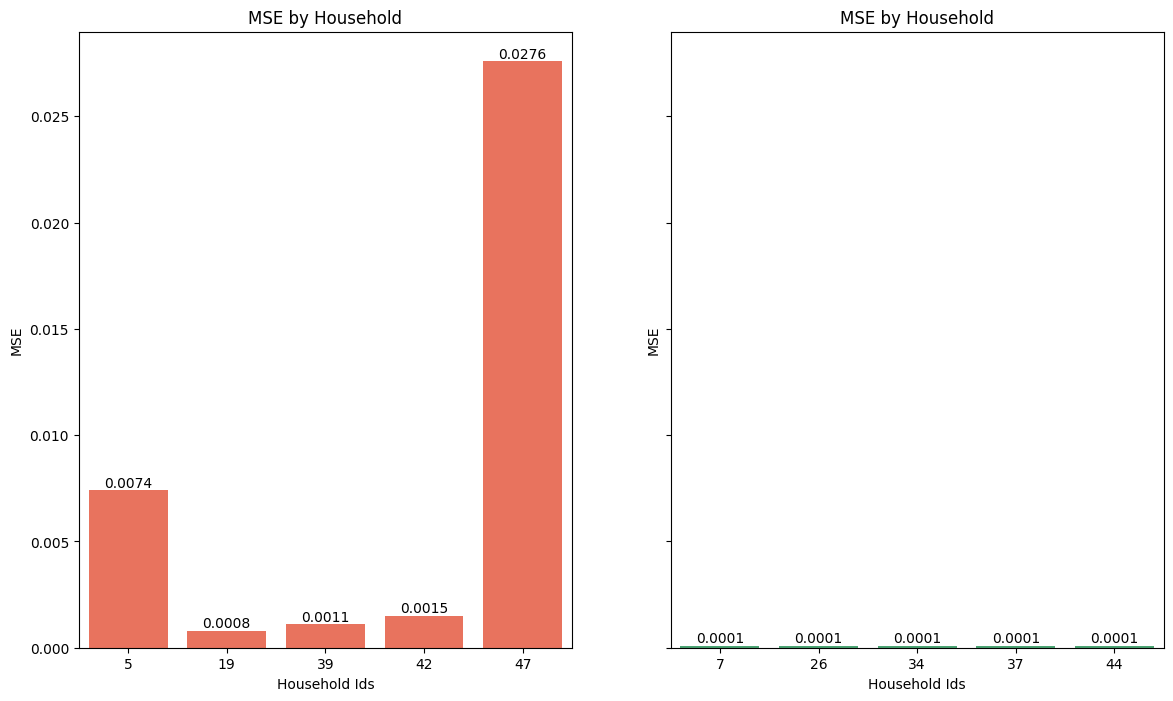

In [64]:
top5_metric = cnnlstm_metrics.sort_values(by='mse', ascending=False).head(5)
bottom5_metric = cnnlstm_metrics.sort_values(by='mse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mse')

<Figure size 1400x800 with 0 Axes>

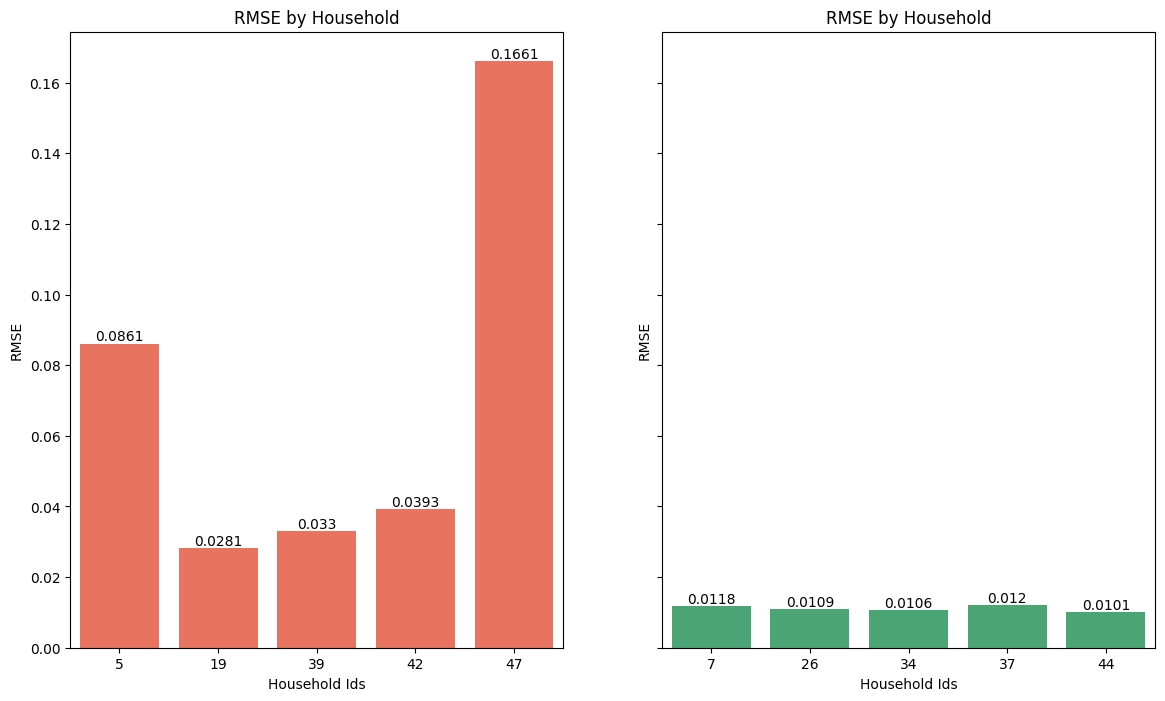

In [65]:
top5_metric = cnnlstm_metrics.sort_values(by='rmse', ascending=False).head(5)
bottom5_metric = cnnlstm_metrics.sort_values(by='rmse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'rmse')

<Figure size 1400x800 with 0 Axes>

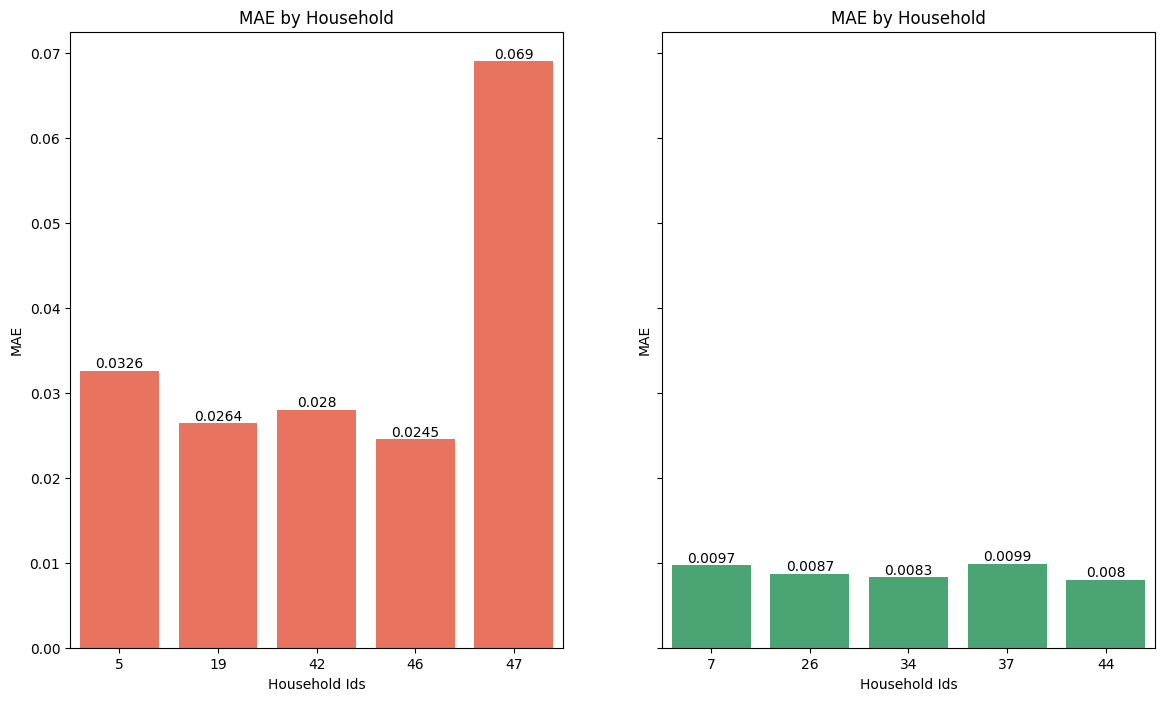

In [66]:
top5_metric = cnnlstm_metrics.sort_values(by='mae', ascending=False).head(5)
bottom5_metric = cnnlstm_metrics.sort_values(by='mae', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mae')

<Figure size 1400x800 with 0 Axes>

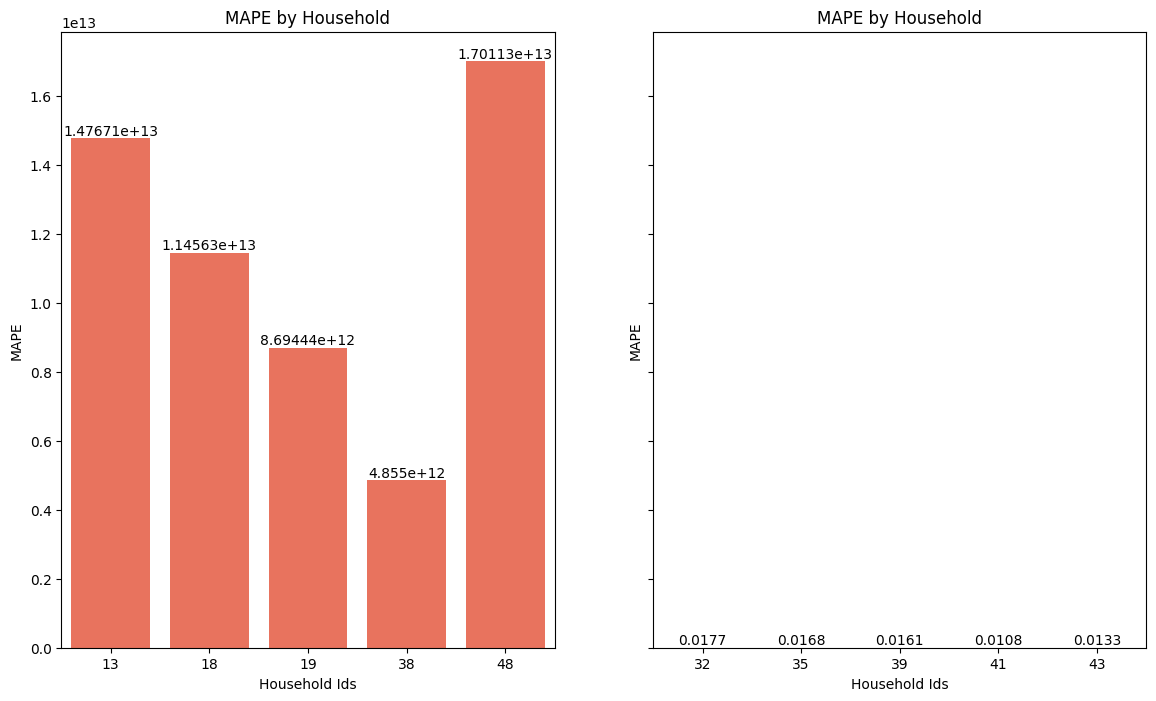

In [67]:
top5_metric = cnnlstm_metrics.sort_values(by='mape', ascending=False).head(5)
bottom5_metric = cnnlstm_metrics.sort_values(by='mape', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mape')

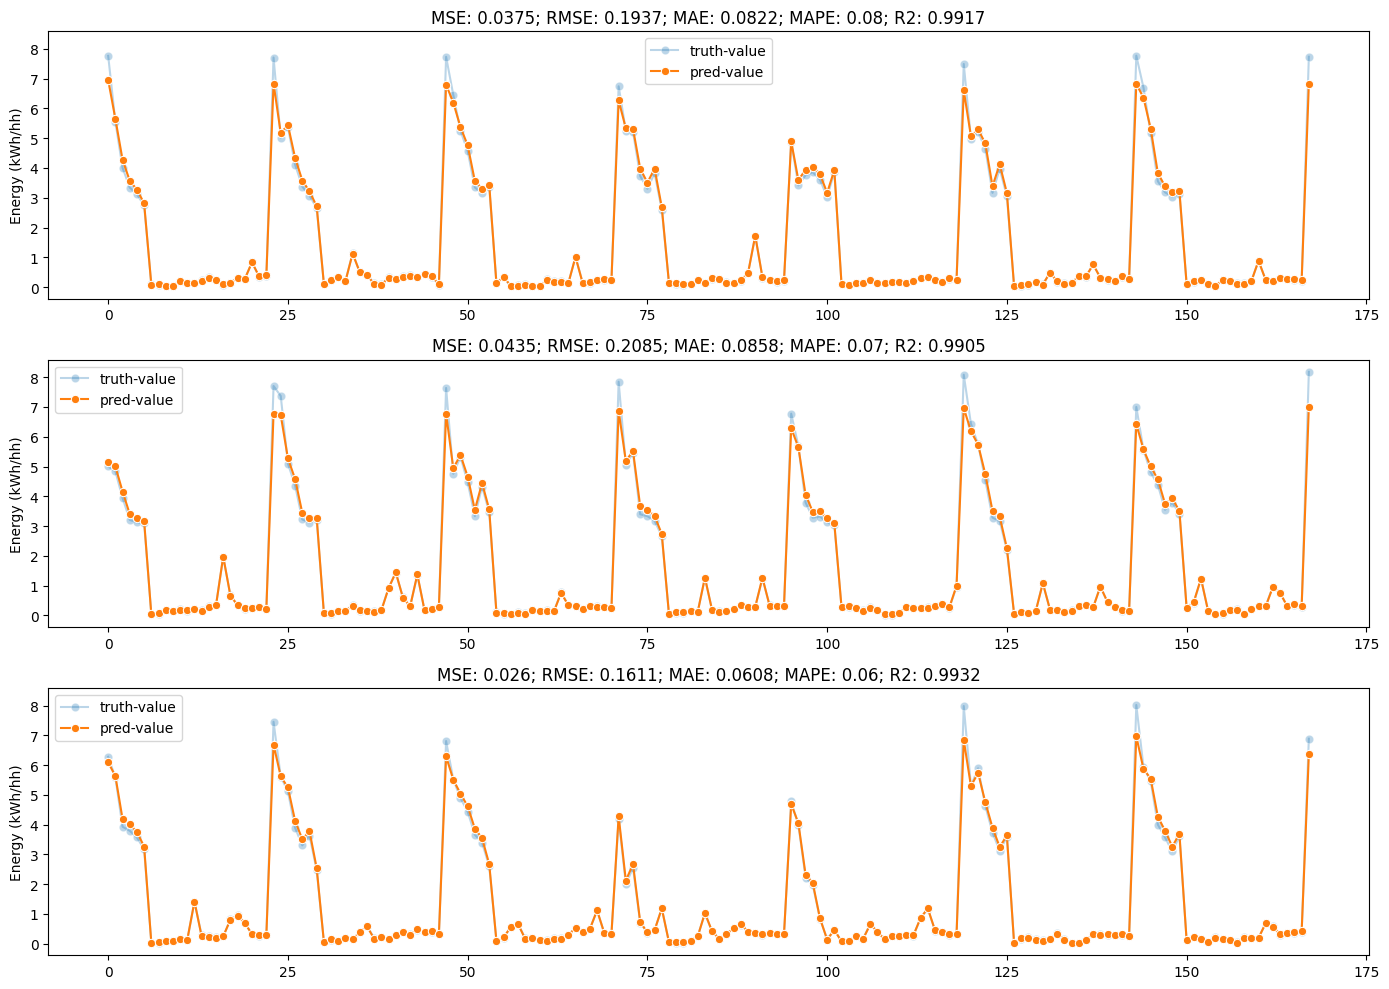

In [69]:
filtered_data = cnnlstm_pred_by_household.loc[cnnlstm_pred_by_household['household_id'] == 47]
plot_forecast(filtered_data['y_pred'], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

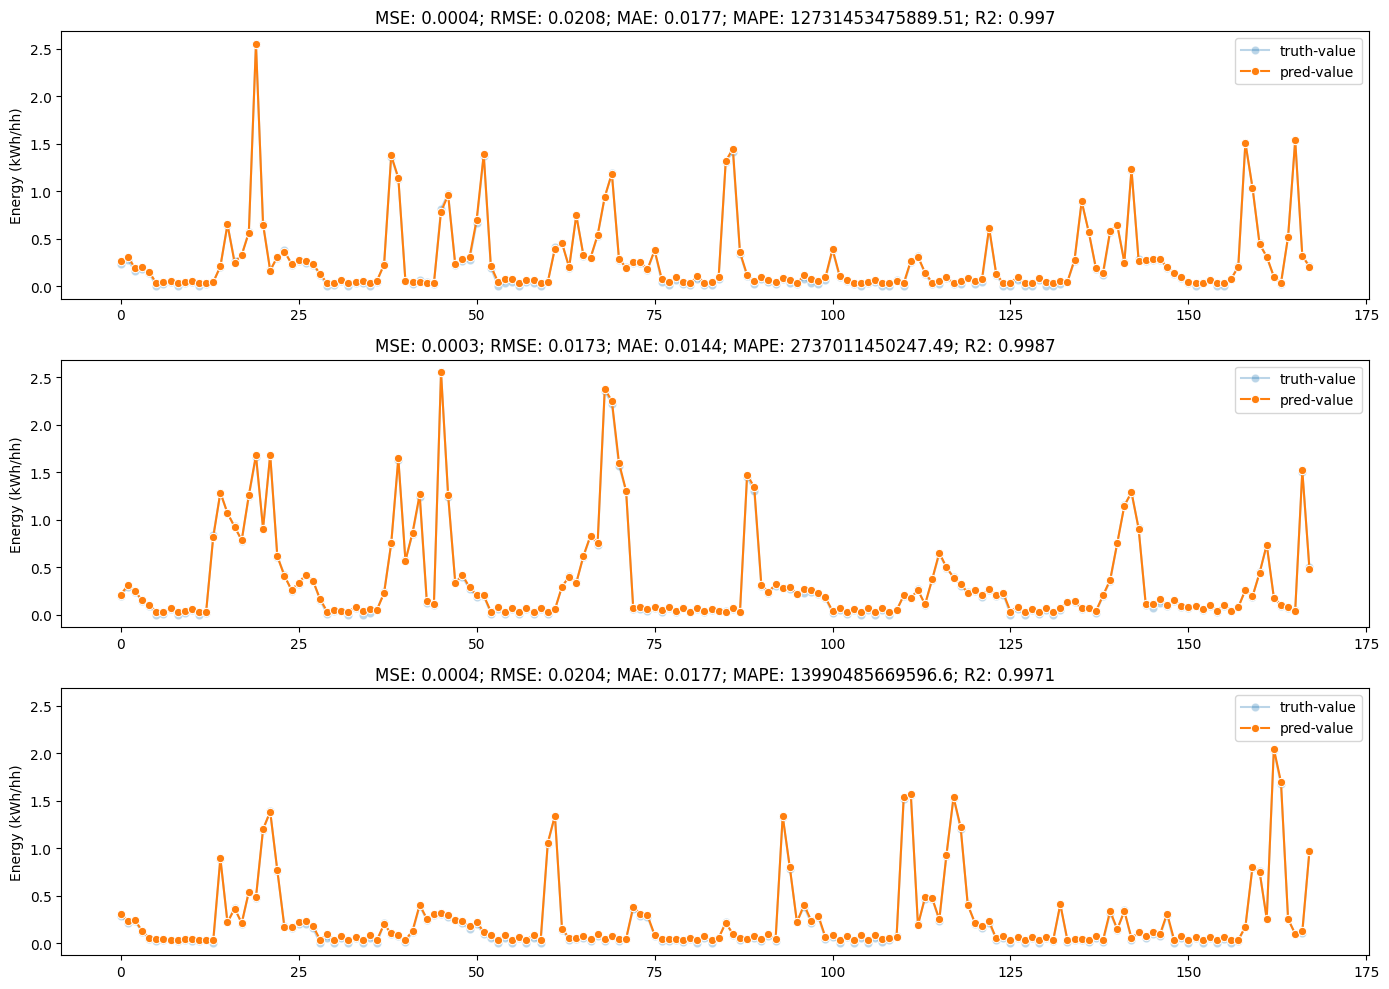

In [70]:
filtered_data = cnnlstm_pred_by_household.loc[cnnlstm_pred_by_household['household_id'] == 48]
plot_forecast(filtered_data['y_pred'], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

## Probabilistic Approach

In [115]:
from sklearn.metrics import (
   mean_absolute_percentage_error, 
   mean_absolute_error, 
   mean_squared_error, 
   r2_score,
   mean_pinball_loss
)

def adjusted_r2(y_pred, y_test):
   p = X_train.shape[1]
   r2 = r2_score(y_pred, y_test)
   n = y_test.shape[0]
   
   adjusted_coefficient = 1 - (1 - r2) * (n - 1) / (n - p - 1)

   return adjusted_coefficient

def evaluate_model(y_pred, y_test):
  """
    Evaluate the model predictions with all the regression metrics
  """

  print("RMSE:", mean_squared_error(y_pred['pred_0.5'], y_test, squared=False))
  print("MSE:", mean_squared_error(y_pred['pred_0.5'], y_test, squared=True))
  print("MAE:", mean_absolute_error(y_pred['pred_0.5'], y_test))
  print("MAPE:", mean_absolute_percentage_error(y_pred['pred_0.5'], y_test))
  print("R2 Score:", r2_score(y_pred['pred_0.5'], y_test))
  print("Adjusted R2 Score:", adjusted_r2(y_pred['pred_0.5'], y_test))

  print("Pinball loss with alpha 0.2:", mean_pinball_loss(y_pred['pred_0.2'], y_test, alpha=0.2))
  print("Pinball loss with alpha 0.5:", mean_pinball_loss(y_pred['pred_0.5'], y_test, alpha=0.5))
  print("Pinball loss with alpha 0.8:", mean_pinball_loss(y_pred['pred_0.8'], y_test, alpha=0.8))

def plot_forecast(y_pred, y_test, number_of_slices=3, steps=168, skip=0):
    """
      Plot the forecasted values against the truth values for LSTM and CNN-LSTM
    """
    fig, axes = plt.subplots(number_of_slices, 1, sharey=True, figsize=(14, 10))
    timesteps = np.arange(0, steps)
    
    for i in range(number_of_slices):
        start_idx = 0 + (steps * i) + (skip)
        end_idx = steps * (1 + i) + (skip)
        sampled_test = y_test.iloc[start_idx:end_idx]
        sampled_pred = y_pred.iloc[start_idx:end_idx]

        mse = round(mean_squared_error(sampled_test, sampled_pred['pred_0.5']), 4)
        rmse = round(mean_squared_error(sampled_test, sampled_pred['pred_0.5'], squared=False), 4)
        mae = round(mean_absolute_error(sampled_test, sampled_pred['pred_0.5']), 4)
        mape = round(mean_absolute_percentage_error(sampled_test, sampled_pred['pred_0.5']), 2)
        r2 = round(r2_score(sampled_test, sampled_pred['pred_0.5']), 4)
        mape = round(mean_absolute_percentage_error(sampled_test, sampled_pred['pred_0.5']), 2)
        
        sns.lineplot(x=timesteps, y=sampled_test, label="truth-value", marker='o', alpha=0.3, ax=axes[i])
        sns.lineplot(x=timesteps, y=sampled_pred['pred_0.5'], label="forecasted-median", marker='o', ax=axes[i])
        axes[i].fill_between(x=timesteps, y1=sampled_pred['pred_0.2'], y2=sampled_pred['pred_0.8'], alpha=0.1, color='blue')
        axes[i].set_title(f'MSE: {mse}; RMSE: {rmse}; MAE: {mae}; MAPE: {mape}; R2: {r2}')

    plt.tight_layout()
    plt.show()
    

### Quantile-XGBoost

In [72]:
from xgboost import XGBRegressor

# reshape back to the original shape for XGBoost
ml_train = X_train.reshape(X_train.shape[0], X_train.shape[2]) 
ml_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

alphas = [0.2, 0.5, 0.8]
hyperparams = {'learning_rate': 0.003, 'max_depth': 9, 'n_estimators': 1000, 'reg_alpha': 0.7}
quantile_xgb = XGBRegressor(objective='reg:quantileerror', random_state=42, n_jobs=5, quantile_alpha=alphas, **hyperparams) # uses 5 CPU cores
quantile_xgb.fit(ml_train, y_train)

y_pred = quantile_xgb.predict(ml_test)
y_pred = pd.DataFrame(y_pred, columns=['pred_0.2', 'pred_0.5', 'pred_0.8'])

evaluate_model(y_pred, y_test)


RMSE: 0.33684408091762613
MSE: 0.11346393484924026
MAE: 0.13381192559620747
MAPE: 0.2756535608531078
R2 Score: 0.42276862419855876
Adjusted R2 Score: 0.42276106020060555
Pinball loss with alpha 0.2: 0.15828588764430016
Pinball loss with alpha 0.5: 0.06690596279810374
Pinball loss with alpha 0.8: 0.0949553740484048


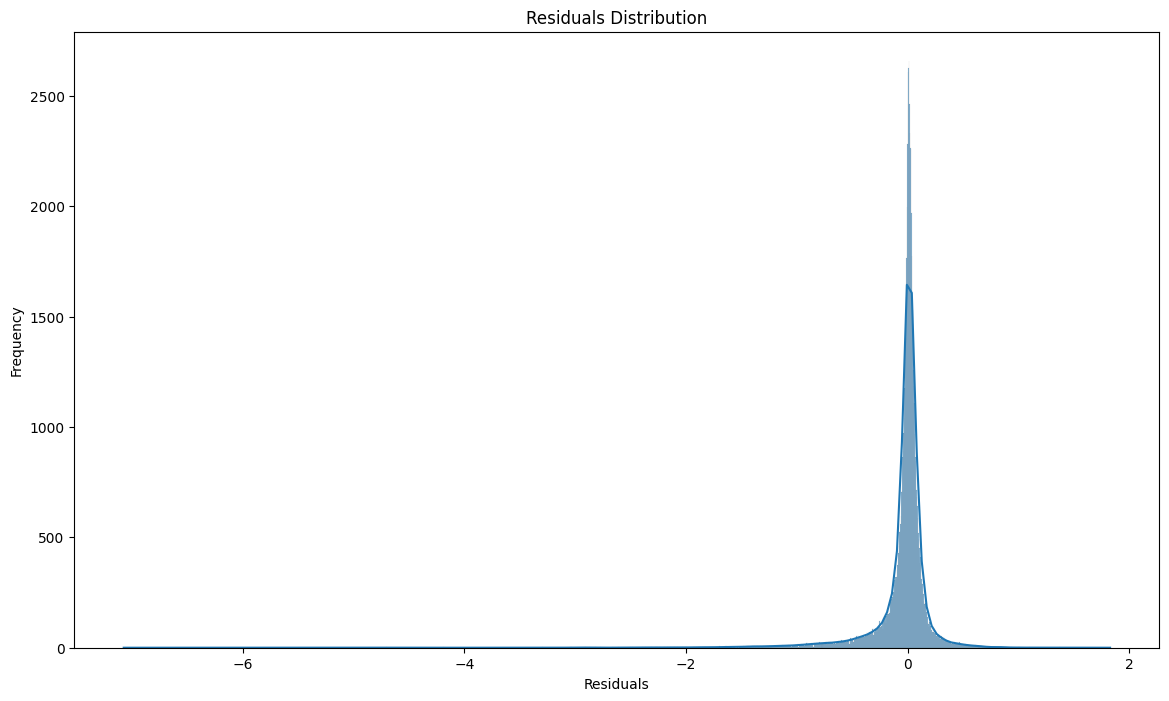

In [81]:
residuals = calculate_error(y_pred['pred_0.5'], y_test.reset_index()['energy(kWh/hh)'])

plot_error_distribution(residuals)

In [90]:
# prepare the prediction dataframe with household and testing data
quantile_xgb_pred_by_household = pd.DataFrame(np.hstack([y_pred.values.reshape(-1, 3), y_test_with_ids[['household_ids', 'y_test']].to_numpy().reshape(-1, 2)]), columns=['pred_0.2', 'pred_0.5', 'pred_0.8', 'household_id', 'y_test'])
quantile_xgb_pred_by_household['household_id'] = quantile_xgb_pred_by_household['household_id'].astype('int8')

# prepare the household grp
quantile_xgb_hhgroup = quantile_xgb_pred_by_household.groupby('household_id')

# calculate the metrics for each individual group
quantile_xgb_metrics = quantile_xgb_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['pred_0.5'])).reset_index()
quantile_xgb_metrics['rmse'] = quantile_xgb_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['pred_0.5'], squared=False)).values
quantile_xgb_metrics['mae'] = quantile_xgb_hhgroup.apply(lambda x: mean_absolute_error(x['y_test'], x['pred_0.5'])).values
quantile_xgb_metrics['mape'] = quantile_xgb_hhgroup.apply(lambda x: mean_absolute_percentage_error(x['y_test'], x['pred_0.5'])).values
quantile_xgb_metrics['r2'] = quantile_xgb_hhgroup.apply(lambda x: r2_score(x['y_test'], x['pred_0.5'])).values
quantile_xgb_metrics['adjusted_r2'] = quantile_xgb_hhgroup.apply(lambda x: adjusted_r2(x['y_test'], x['pred_0.5'])).values
quantile_xgb_metrics = quantile_xgb_metrics.rename(columns={ 0: 'mse'})

# pinball losses
quantile_xgb_metrics['pinball_0.2'] = quantile_xgb_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.2'], x['y_test'], alpha=0.2)).values
quantile_xgb_metrics['pinball_0.5'] = quantile_xgb_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.5'], x['y_test'], alpha=0.5)).values
quantile_xgb_metrics['pinball_0.8'] = quantile_xgb_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.8'], x['y_test'], alpha=0.8)).values


<Figure size 1400x800 with 0 Axes>

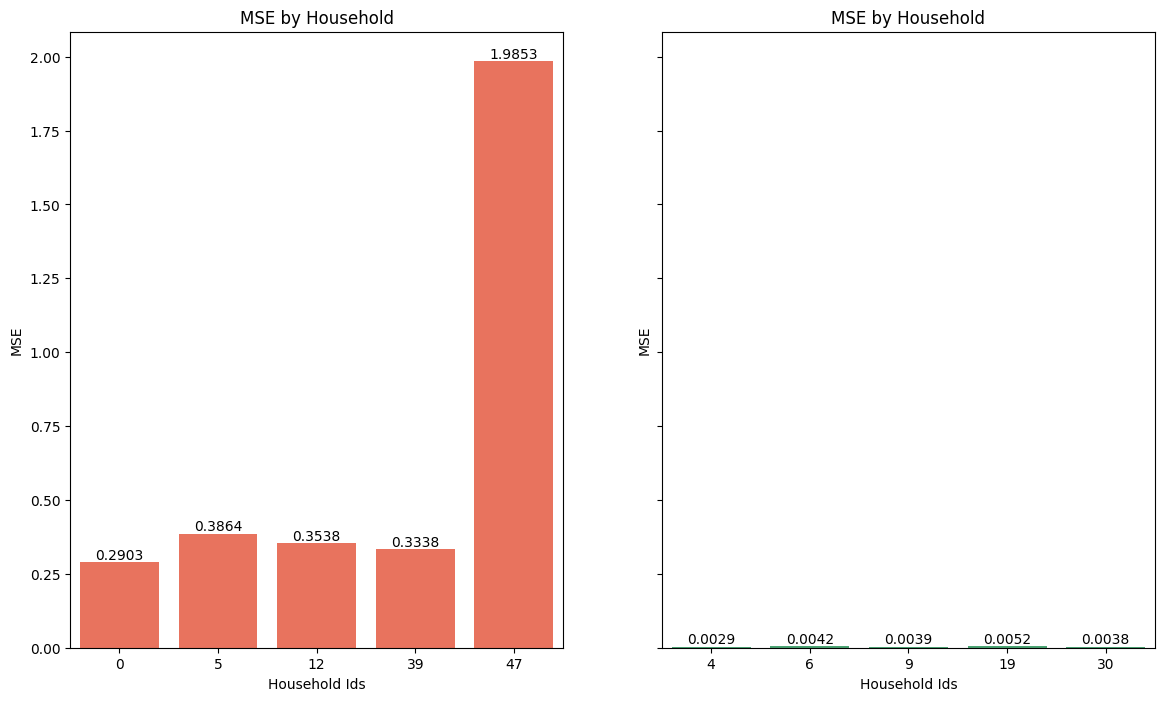

In [92]:
top5_metric = quantile_xgb_metrics.sort_values(by='mse', ascending=False).head(5)
bottom5_metric = quantile_xgb_metrics.sort_values(by='mse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mse')

<Figure size 1400x800 with 0 Axes>

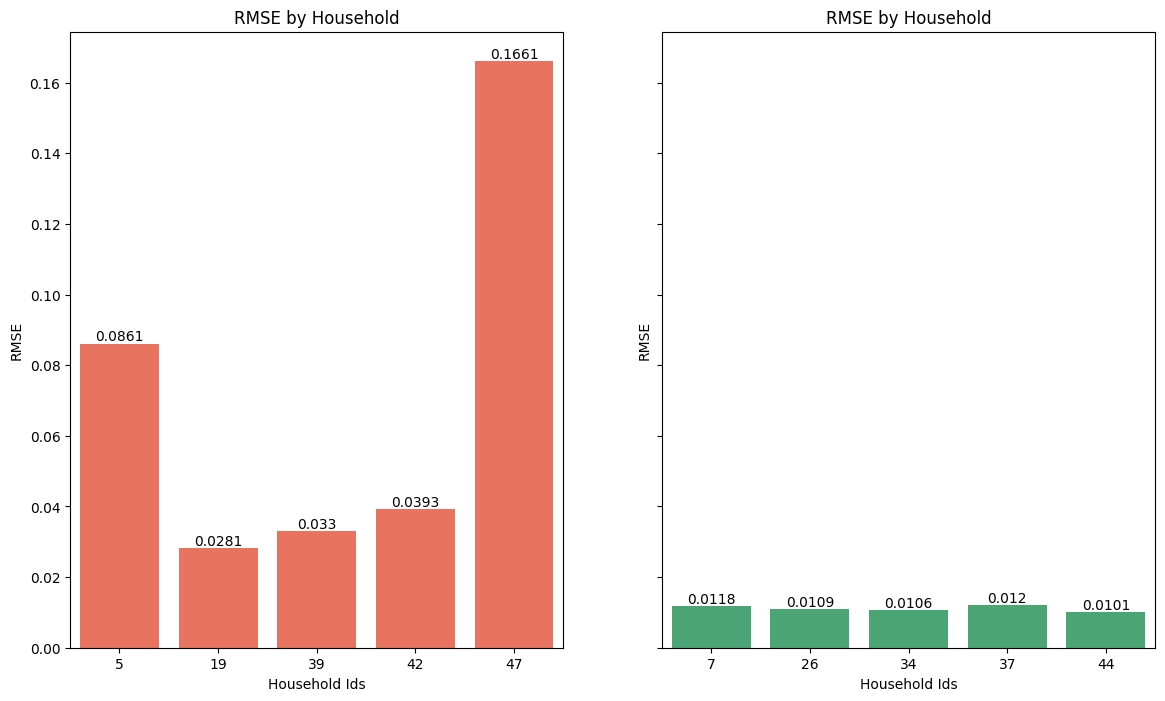

In [93]:
top5_metric = cnnlstm_metrics.sort_values(by='rmse', ascending=False).head(5)
bottom5_metric = cnnlstm_metrics.sort_values(by='rmse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'rmse')

<Figure size 1400x800 with 0 Axes>

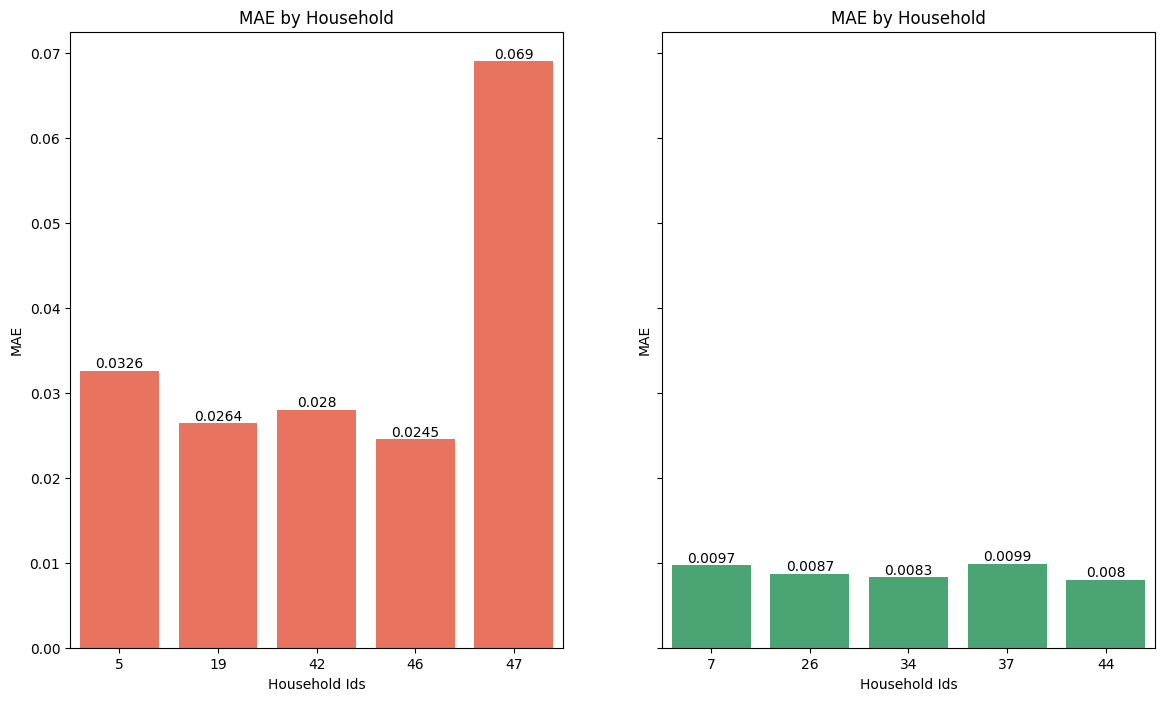

In [94]:
top5_metric = cnnlstm_metrics.sort_values(by='mae', ascending=False).head(5)
bottom5_metric = cnnlstm_metrics.sort_values(by='mae', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mae')

<Figure size 1400x800 with 0 Axes>

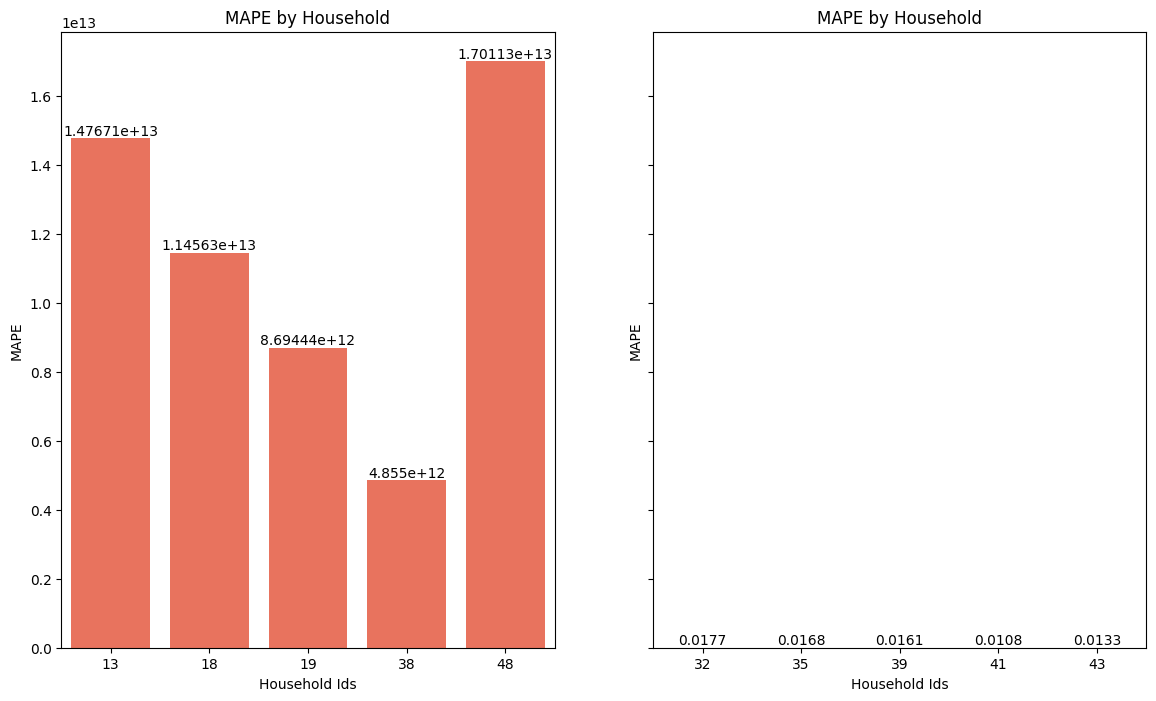

In [95]:
top5_metric = cnnlstm_metrics.sort_values(by='mape', ascending=False).head(5)
bottom5_metric = cnnlstm_metrics.sort_values(by='mape', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mape')

<Figure size 1400x800 with 0 Axes>

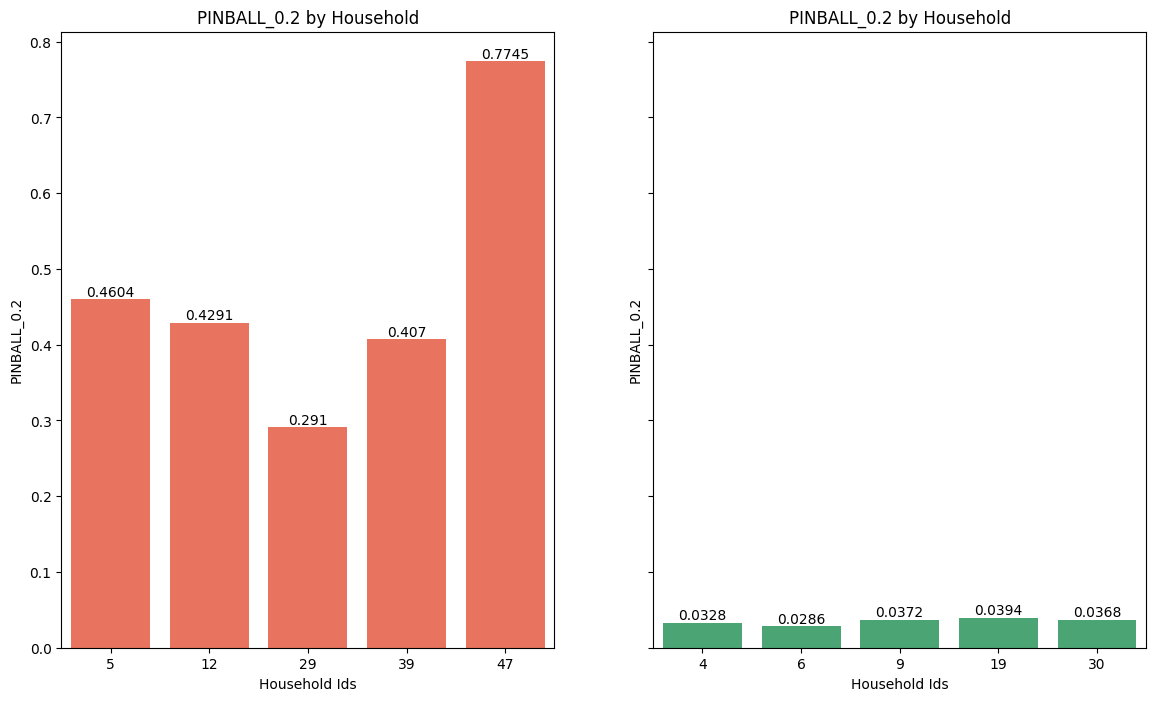

In [97]:
top5_metric = quantile_xgb_metrics.sort_values(by='pinball_0.2', ascending=False).head(5)
bottom5_metric = quantile_xgb_metrics.sort_values(by='pinball_0.2', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.2')

<Figure size 1400x800 with 0 Axes>

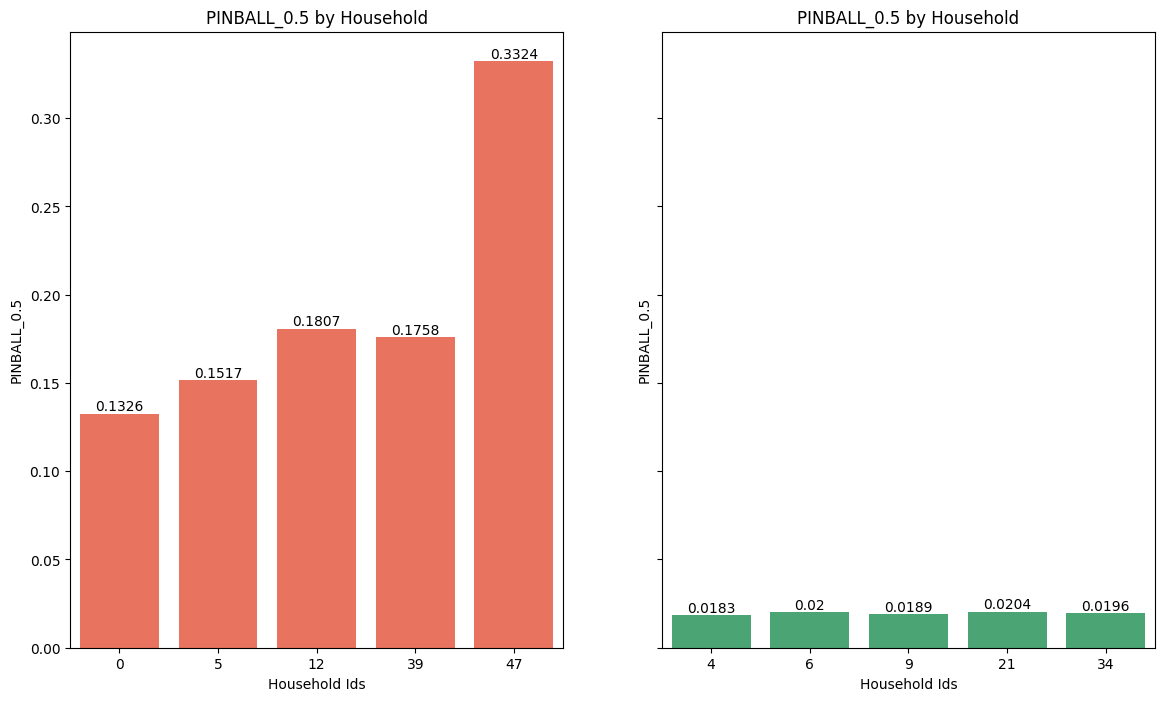

In [98]:
top5_metric = quantile_xgb_metrics.sort_values(by='pinball_0.5', ascending=False).head(5)
bottom5_metric = quantile_xgb_metrics.sort_values(by='pinball_0.5', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.5')

<Figure size 1400x800 with 0 Axes>

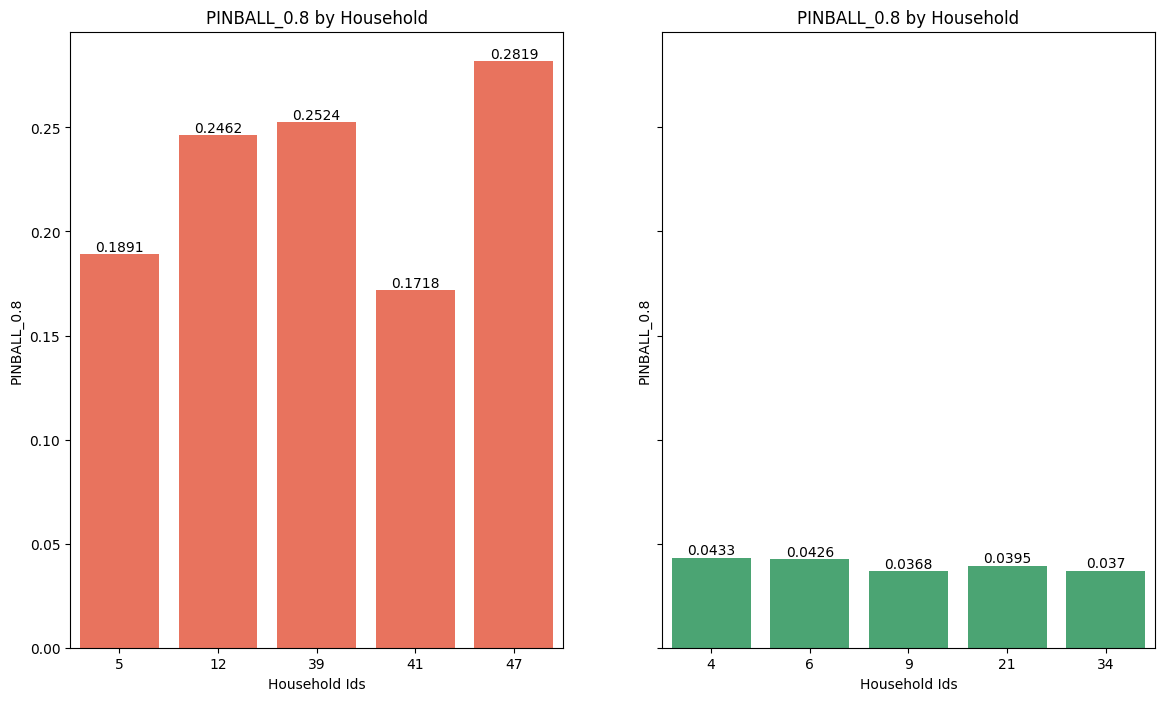

In [99]:
top5_metric = quantile_xgb_metrics.sort_values(by='pinball_0.8', ascending=False).head(5)
bottom5_metric = quantile_xgb_metrics.sort_values(by='pinball_0.8', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.8')

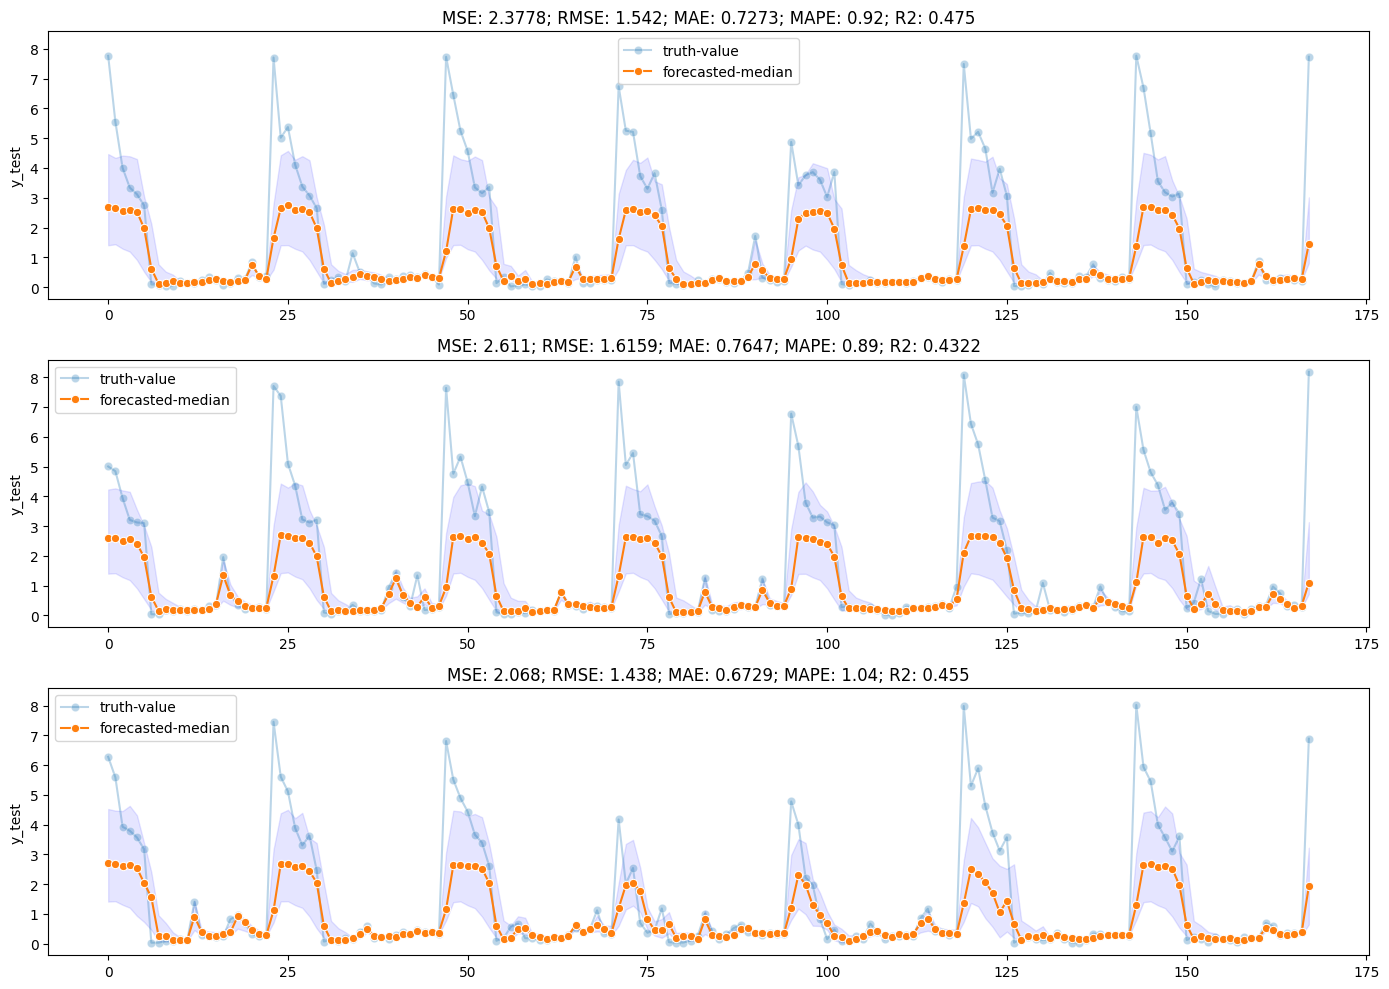

In [117]:
filtered_data = quantile_xgb_pred_by_household.loc[quantile_xgb_pred_by_household['household_id'] == 47]
plot_forecast(filtered_data[['pred_0.2', 'pred_0.5', 'pred_0.8']], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

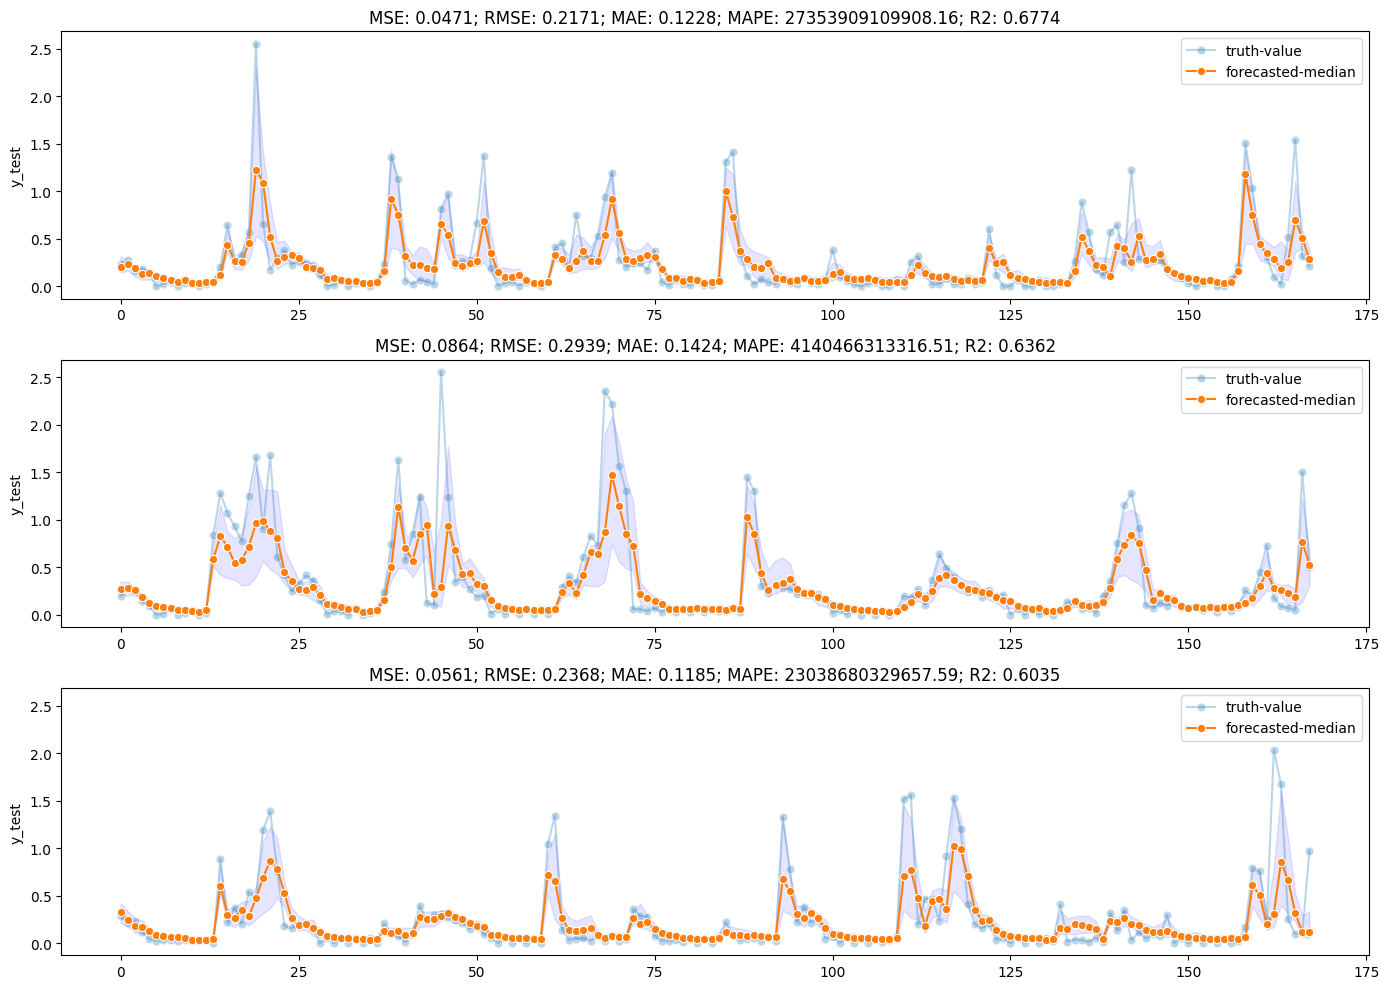

In [116]:
filtered_data = quantile_xgb_pred_by_household.loc[quantile_xgb_pred_by_household['household_id'] == 48]
plot_forecast(filtered_data[['pred_0.2', 'pred_0.5', 'pred_0.8']], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

### Quantile-LightGBM

In [118]:
from lightgbm import LGBMRegressor
from sklearn.metrics import (
  mean_absolute_percentage_error, 
  mean_absolute_error, 
  mean_squared_error, 
  r2_score,
  mean_pinball_loss
)

class QuantileLightGBM:
  def __init__(self, alphas=[0.2, 0.5, 0.8], **keyword_args):
    self.models = {}
    self.alphas = alphas
    self.hyperparams = keyword_args

  def fit(self, X_train, y_train):
    # train respective models for each quantile
    for alpha in self.alphas:
      model = LGBMRegressor(
        random_state=42, 
        objective='quantile', 
        alpha=alpha,
        **self.hyperparams
      )
      
      # fit the model
      model.fit(X_train, y_train)
      self.models[f'model_{str(alpha)}'] = model # save the model

  def predict(self, X_test):
    y_pred = {}
    for i in range(len(self.alphas)):
      alpha = self.alphas[i]
      model = self.models[f'model_{str(alpha)}']
      y_pred[f'pred_{str(alpha)}'] = model.predict(X_test)

    return pd.DataFrame(y_pred)
  
  def evaluate(self, X_test, y_test):
      y_pred = self.predict(X_test)

      # point metrics
      mape = mean_absolute_percentage_error(y_pred['pred_0.5'], y_test)
      mae = mean_absolute_error(y_pred['pred_0.5'], y_test)
      mse = mean_squared_error(y_pred['pred_0.5'], y_test)
      rmse = mean_squared_error(y_pred['pred_0.5'], y_test, squared=False)
      r2 = r2_score(y_pred['pred_0.5'], y_test)
      adj_r2 = adjusted_r2(y_pred['pred_0.5'], y_test)

      # quantile loss
      loss_20 = mean_pinball_loss(y_pred['pred_0.2'], y_test, alpha=0.2)
      loss_50 = mean_pinball_loss(y_pred['pred_0.5'], y_test, alpha=0.5)
      loss_80 = mean_pinball_loss(y_pred['pred_0.8'], y_test, alpha=0.8)

      return {
        'mape': mape,
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'adjusted_r2': adj_r2,
        'pinball_loss_20': loss_20,
        'pinball_loss_50': loss_50,
        'pinball_loss_80': loss_80
      }

In [119]:
# reshape back to the original shape for LightGBM
ml_train = X_train.reshape(X_train.shape[0], X_train.shape[2]) 
ml_test = X_test.reshape(X_test.shape[0], X_test.shape[2])

hyperparameters = {'learning_rate': 0.03, 'max_depth': 10, 'n_estimators': 1000, 'reg_alpha': 0.7}
lgbm_model = QuantileLightGBM(alphas=alphas, **hyperparameters)
lgbm_model.fit(ml_train, y_train)

y_pred = lgbm_model.predict(ml_test)

In [133]:
evaluate_model(y_pred, y_test)

RMSE: 0.2603327395642383
MSE: 0.06777313528902151
MAE: 0.09406431963765395
MAPE: 0.1996880147078355
R2 Score: 0.7578827417780442
Adjusted R2 Score: 0.7578795690911072
Pinball loss with alpha 0.2: 0.12139488373379846
Pinball loss with alpha 0.5: 0.047032159818826975
Pinball loss with alpha 0.8: 0.07847047966867078


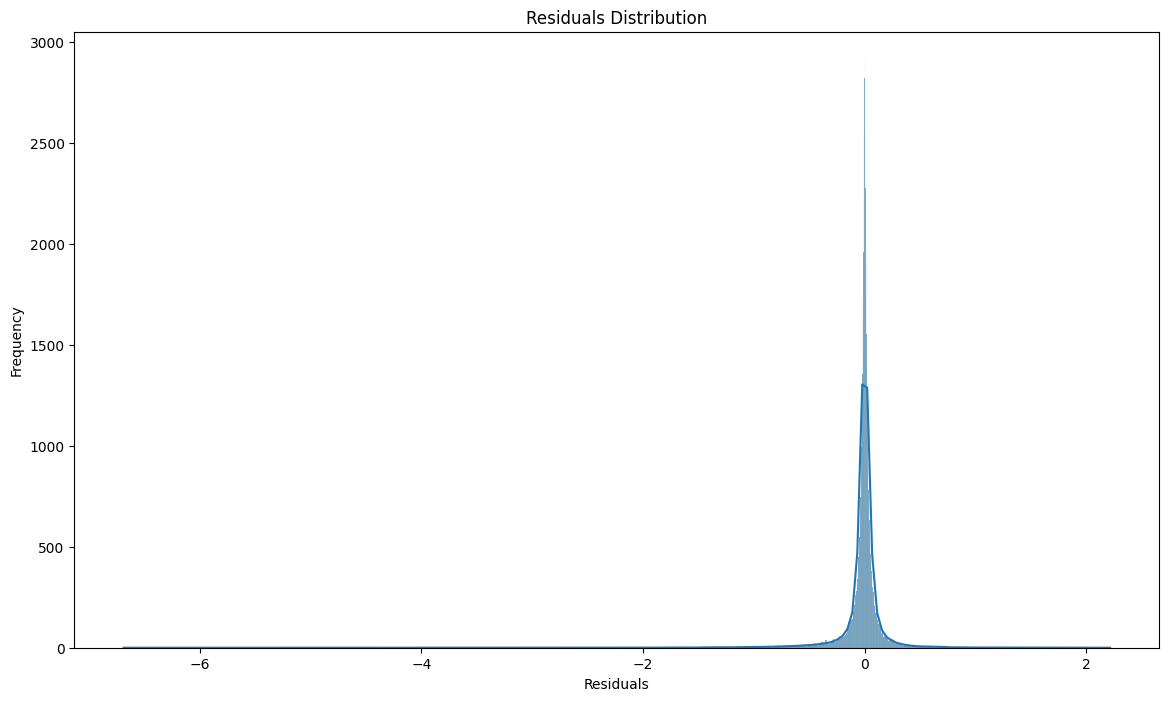

In [135]:
residuals = calculate_error(y_pred['pred_0.5'], y_test.reset_index()['energy(kWh/hh)'])

plot_error_distribution(residuals)

In [121]:
# prepare the prediction dataframe with household and testing data
quantile_lightgbm_pred_by_household = pd.DataFrame(np.hstack([y_pred.values.reshape(-1, 3), y_test_with_ids[['household_ids', 'y_test']].to_numpy().reshape(-1, 2)]), columns=['pred_0.2', 'pred_0.5', 'pred_0.8', 'household_id', 'y_test'])
quantile_lightgbm_pred_by_household['household_id'] = quantile_lightgbm_pred_by_household['household_id'].astype('int8')

# prepare the household grp
quantile_lightgbm_hhgroup = quantile_lightgbm_pred_by_household.groupby('household_id')

# calculate the metrics for each individual group
quantile_lightgbm_metrics = quantile_lightgbm_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['pred_0.5'])).reset_index()
quantile_lightgbm_metrics['rmse'] = quantile_lightgbm_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['pred_0.5'], squared=False)).values
quantile_lightgbm_metrics['mae'] = quantile_lightgbm_hhgroup.apply(lambda x: mean_absolute_error(x['y_test'], x['pred_0.5'])).values
quantile_lightgbm_metrics['mape'] = quantile_lightgbm_hhgroup.apply(lambda x: mean_absolute_percentage_error(x['y_test'], x['pred_0.5'])).values
quantile_lightgbm_metrics['r2'] = quantile_lightgbm_hhgroup.apply(lambda x: r2_score(x['y_test'], x['pred_0.5'])).values
quantile_lightgbm_metrics['adjusted_r2'] = quantile_lightgbm_hhgroup.apply(lambda x: adjusted_r2(x['y_test'], x['pred_0.5'])).values
quantile_lightgbm_metrics = quantile_lightgbm_metrics.rename(columns={ 0: 'mse'})

# pinball losses
quantile_lightgbm_metrics['pinball_0.2'] = quantile_lightgbm_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.2'], x['y_test'], alpha=0.2)).values
quantile_lightgbm_metrics['pinball_0.5'] = quantile_lightgbm_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.5'], x['y_test'], alpha=0.5)).values
quantile_lightgbm_metrics['pinball_0.8'] = quantile_lightgbm_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.8'], x['y_test'], alpha=0.8)).values


<Figure size 1400x800 with 0 Axes>

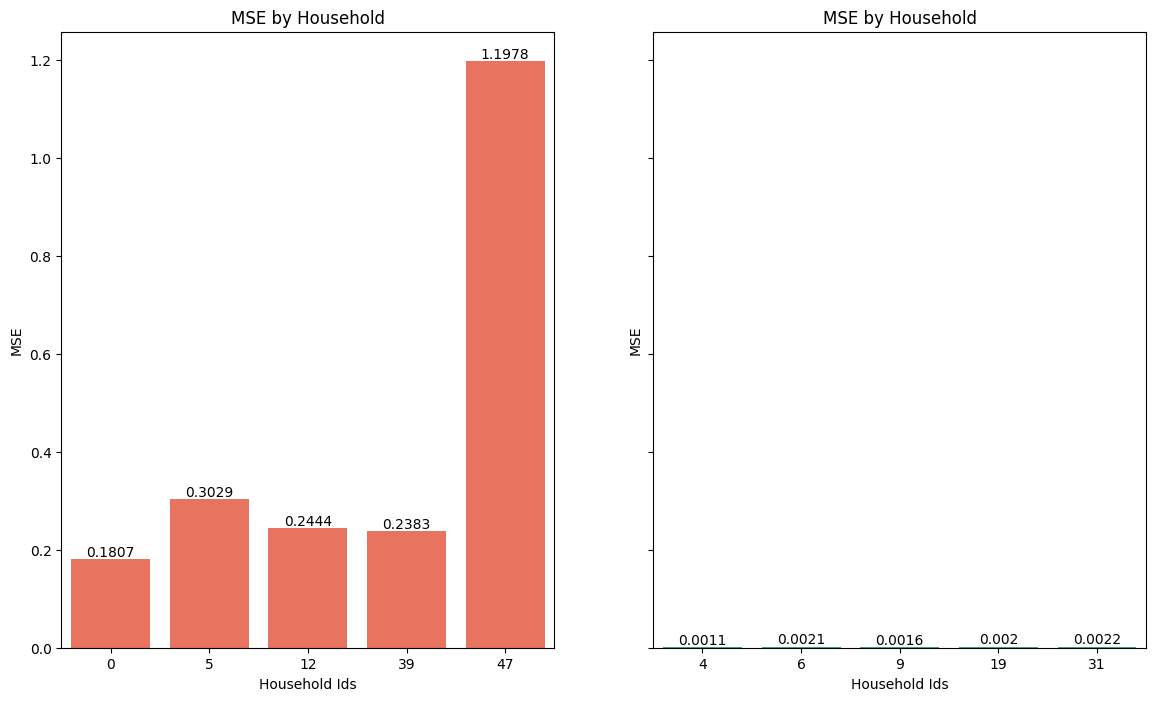

In [123]:
top5_metric = quantile_lightgbm_metrics.sort_values(by='mse', ascending=False).head(5)
bottom5_metric = quantile_lightgbm_metrics.sort_values(by='mse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mse')

<Figure size 1400x800 with 0 Axes>

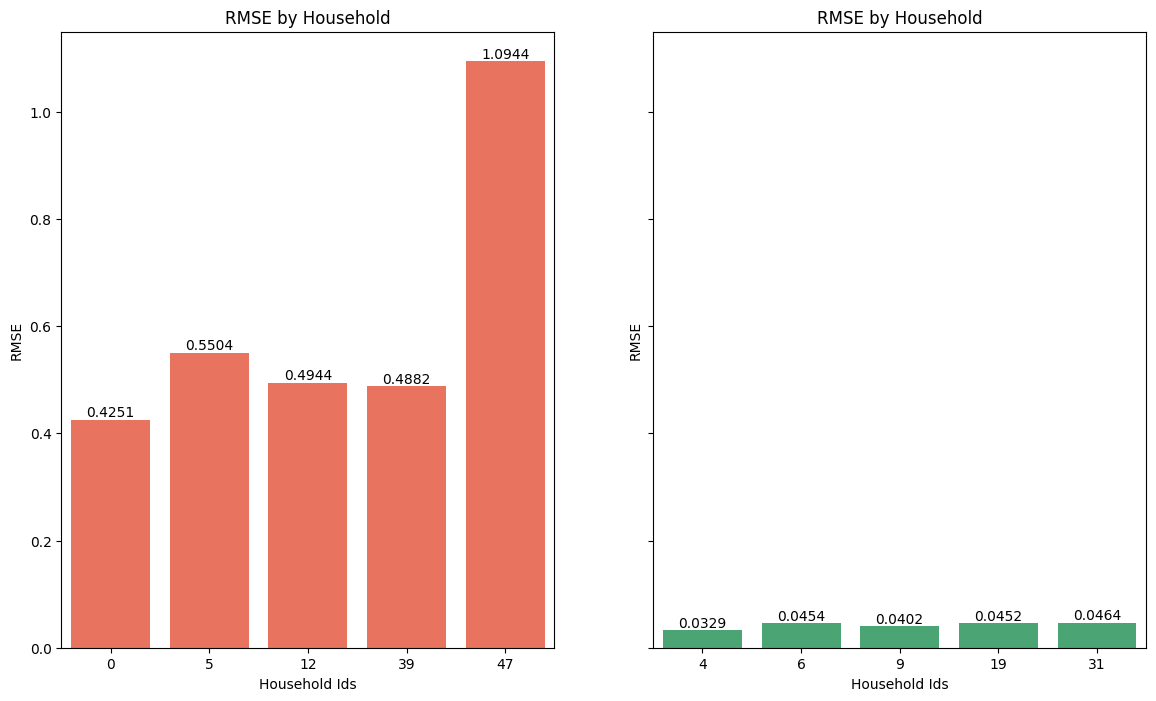

In [124]:
top5_metric = quantile_lightgbm_metrics.sort_values(by='rmse', ascending=False).head(5)
bottom5_metric = quantile_lightgbm_metrics.sort_values(by='rmse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'rmse')

<Figure size 1400x800 with 0 Axes>

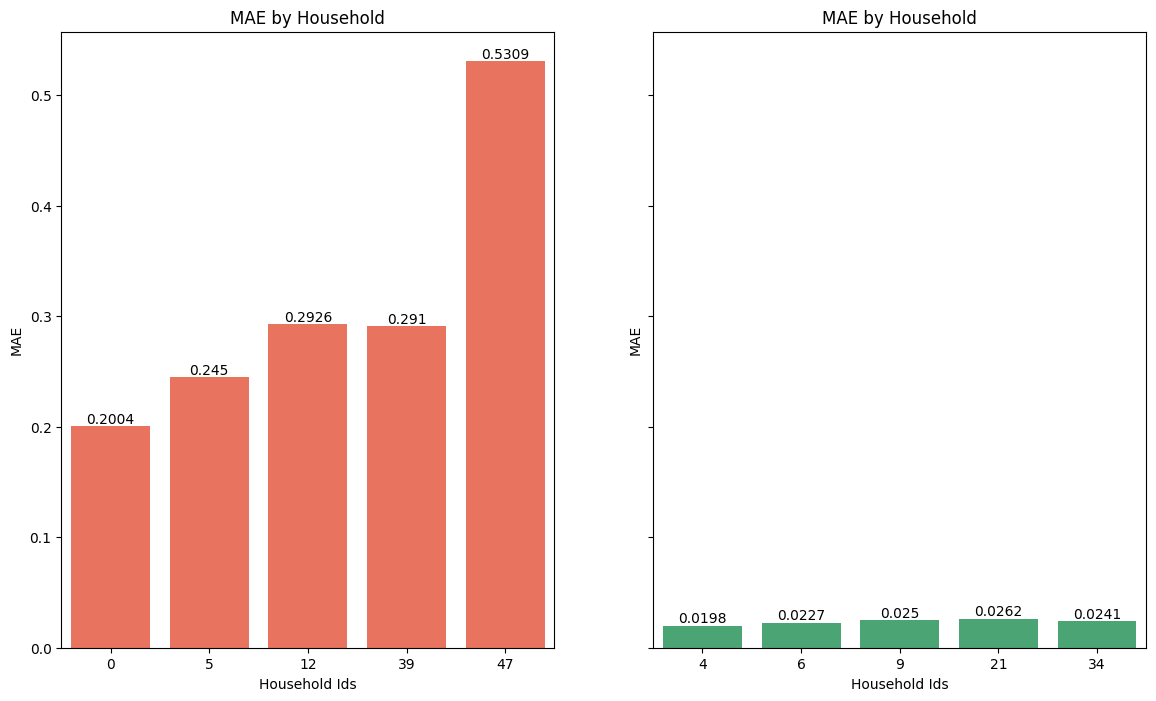

In [125]:
top5_metric = quantile_lightgbm_metrics.sort_values(by='mae', ascending=False).head(5)
bottom5_metric = quantile_lightgbm_metrics.sort_values(by='mae', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mae')

<Figure size 1400x800 with 0 Axes>

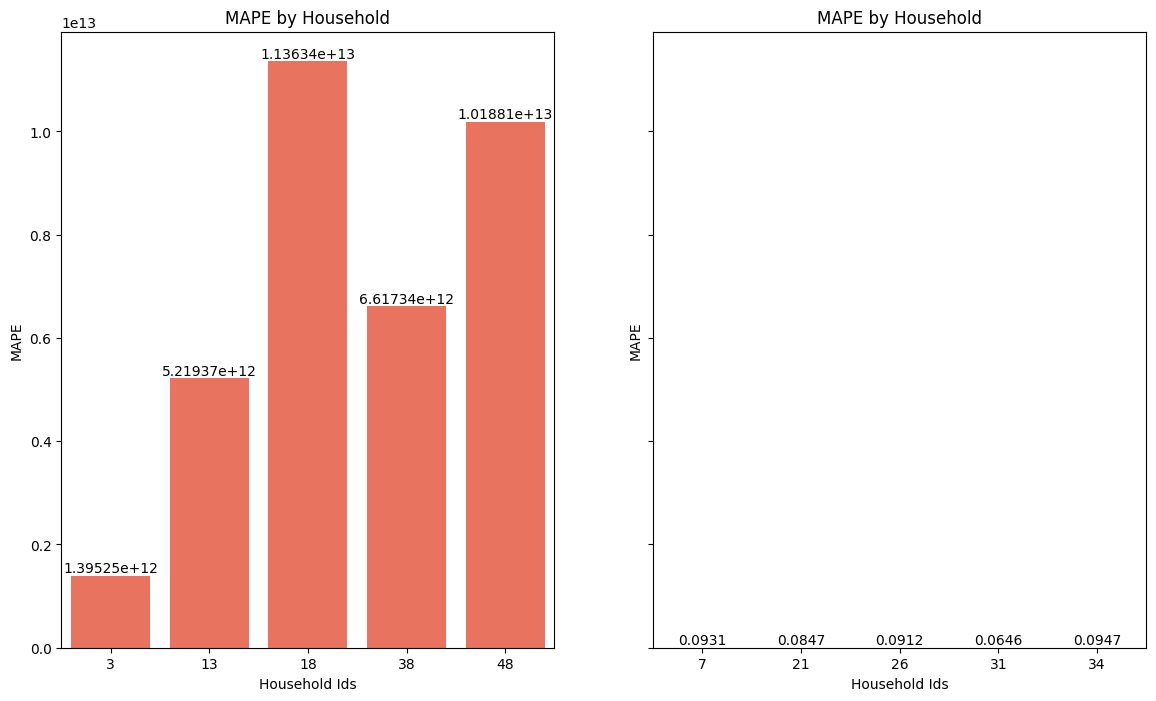

In [126]:
top5_metric = quantile_lightgbm_metrics.sort_values(by='mape', ascending=False).head(5)
bottom5_metric = quantile_lightgbm_metrics.sort_values(by='mape', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mape')

<Figure size 1400x800 with 0 Axes>

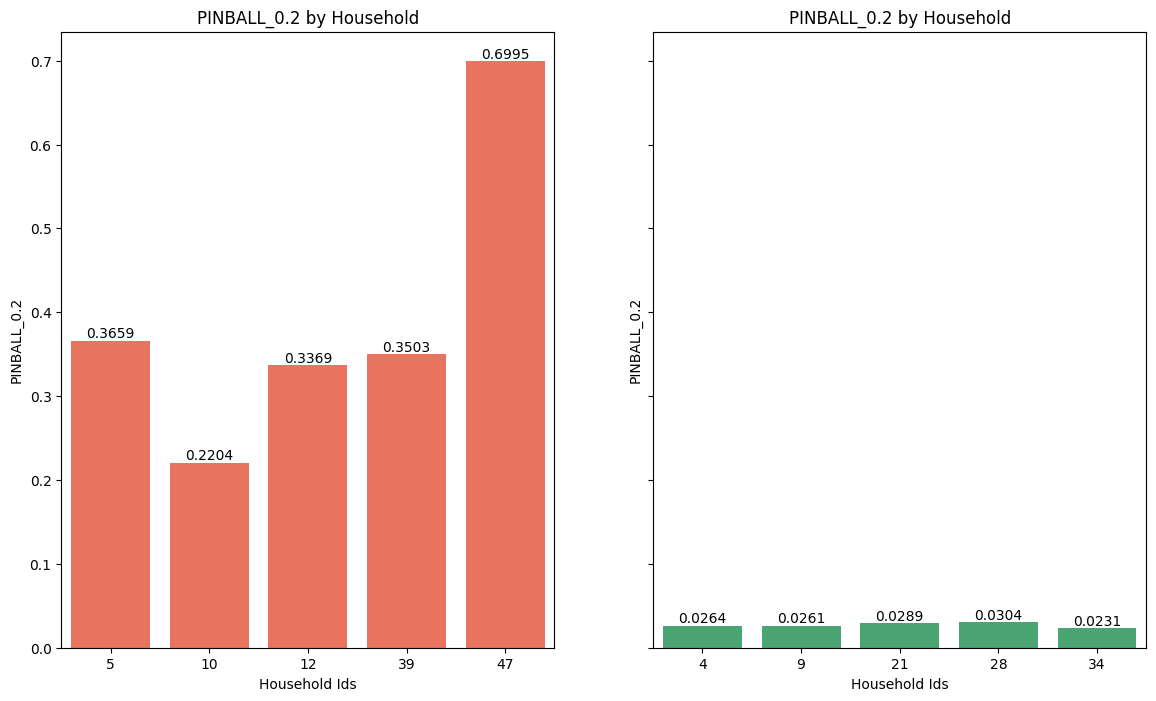

In [127]:
top5_metric = quantile_lightgbm_metrics.sort_values(by='pinball_0.2', ascending=False).head(5)
bottom5_metric = quantile_lightgbm_metrics.sort_values(by='pinball_0.2', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.2')

<Figure size 1400x800 with 0 Axes>

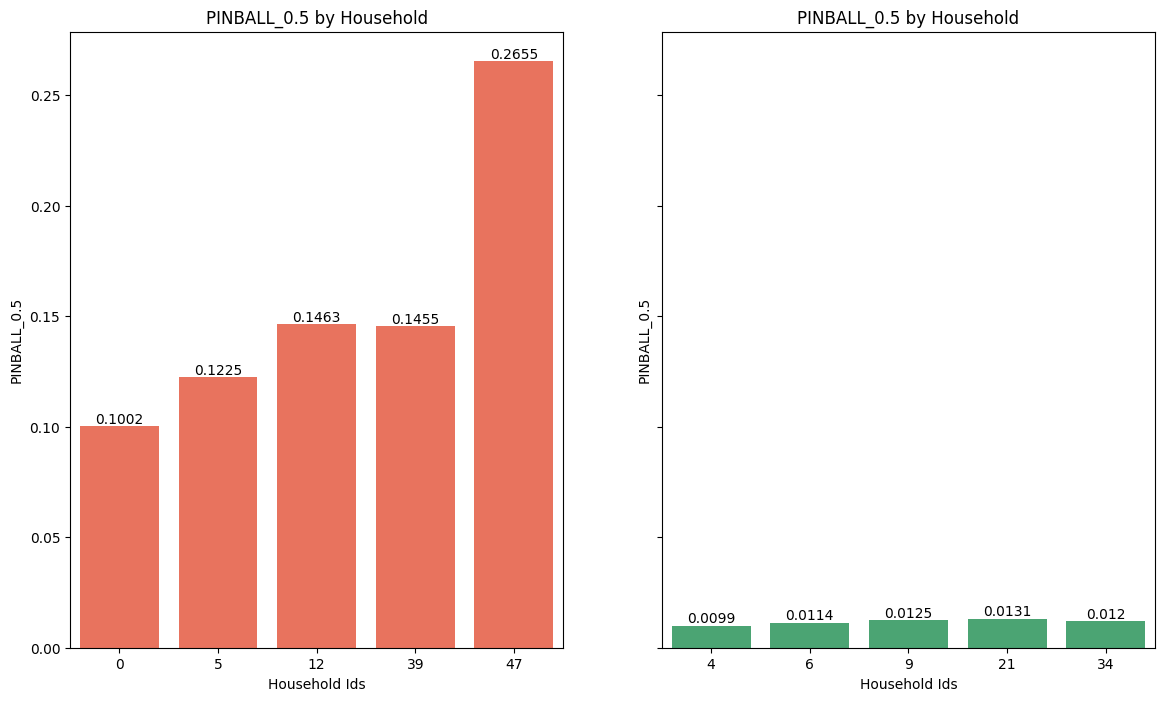

In [128]:
top5_metric = quantile_lightgbm_metrics.sort_values(by='pinball_0.5', ascending=False).head(5)
bottom5_metric = quantile_lightgbm_metrics.sort_values(by='pinball_0.5', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.5')

<Figure size 1400x800 with 0 Axes>

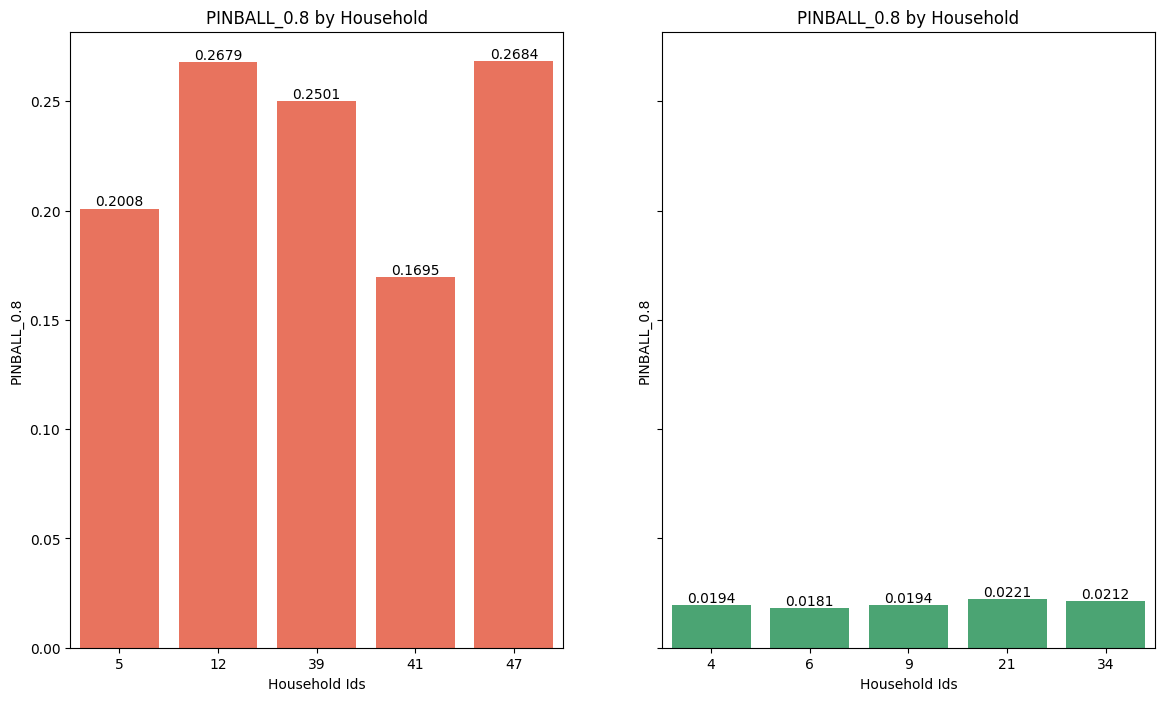

In [129]:
top5_metric = quantile_lightgbm_metrics.sort_values(by='pinball_0.8', ascending=False).head(5)
bottom5_metric = quantile_lightgbm_metrics.sort_values(by='pinball_0.8', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.8')

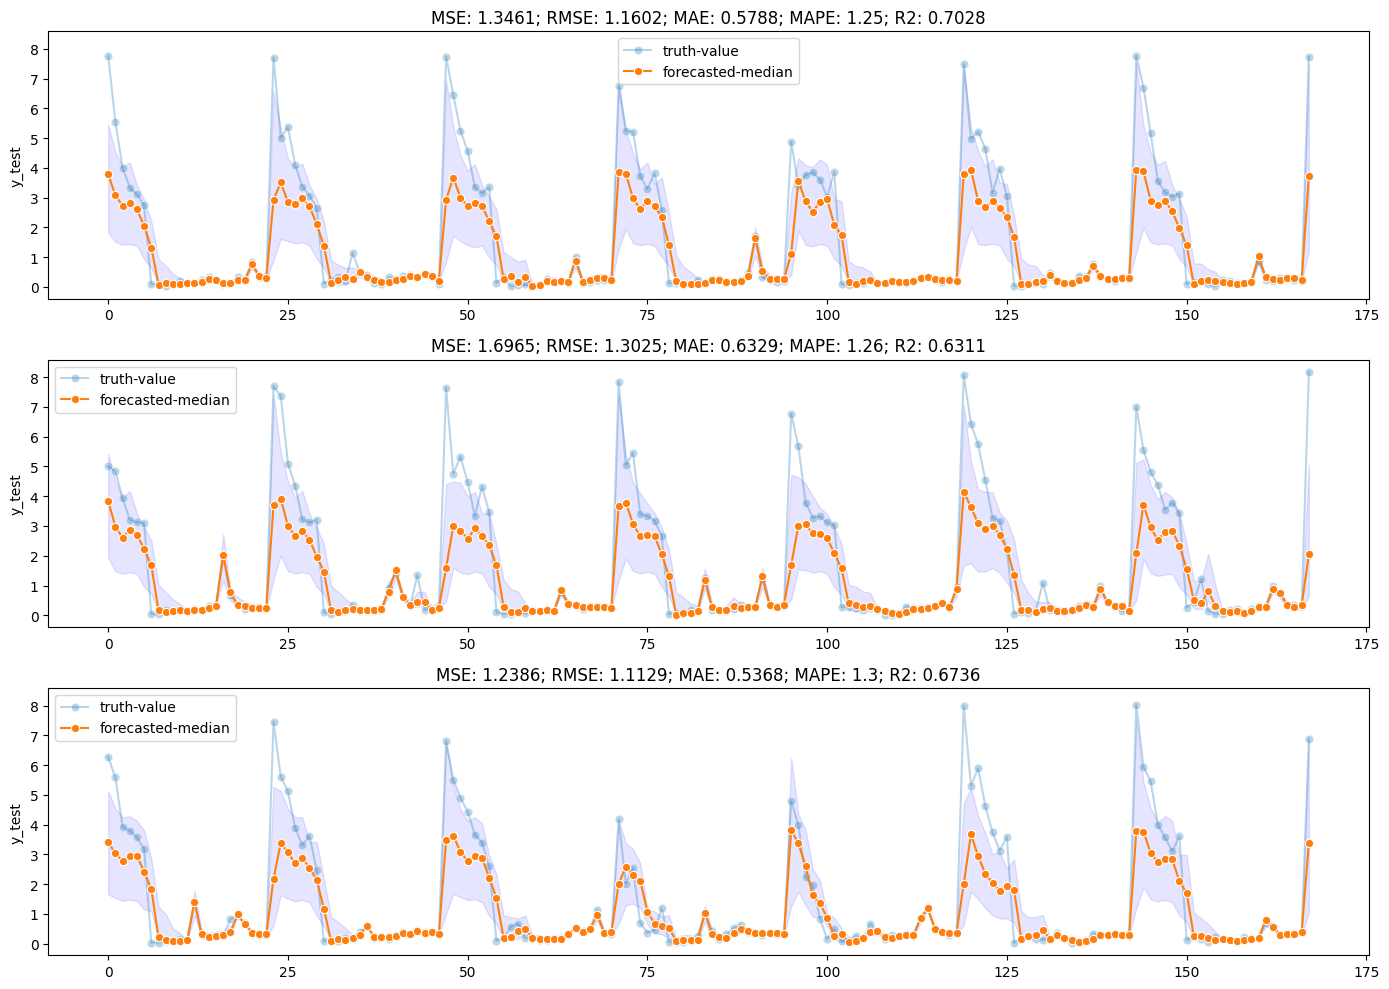

In [130]:
filtered_data = quantile_lightgbm_pred_by_household.loc[quantile_lightgbm_pred_by_household['household_id'] == 47]
plot_forecast(filtered_data[['pred_0.2', 'pred_0.5', 'pred_0.8']], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

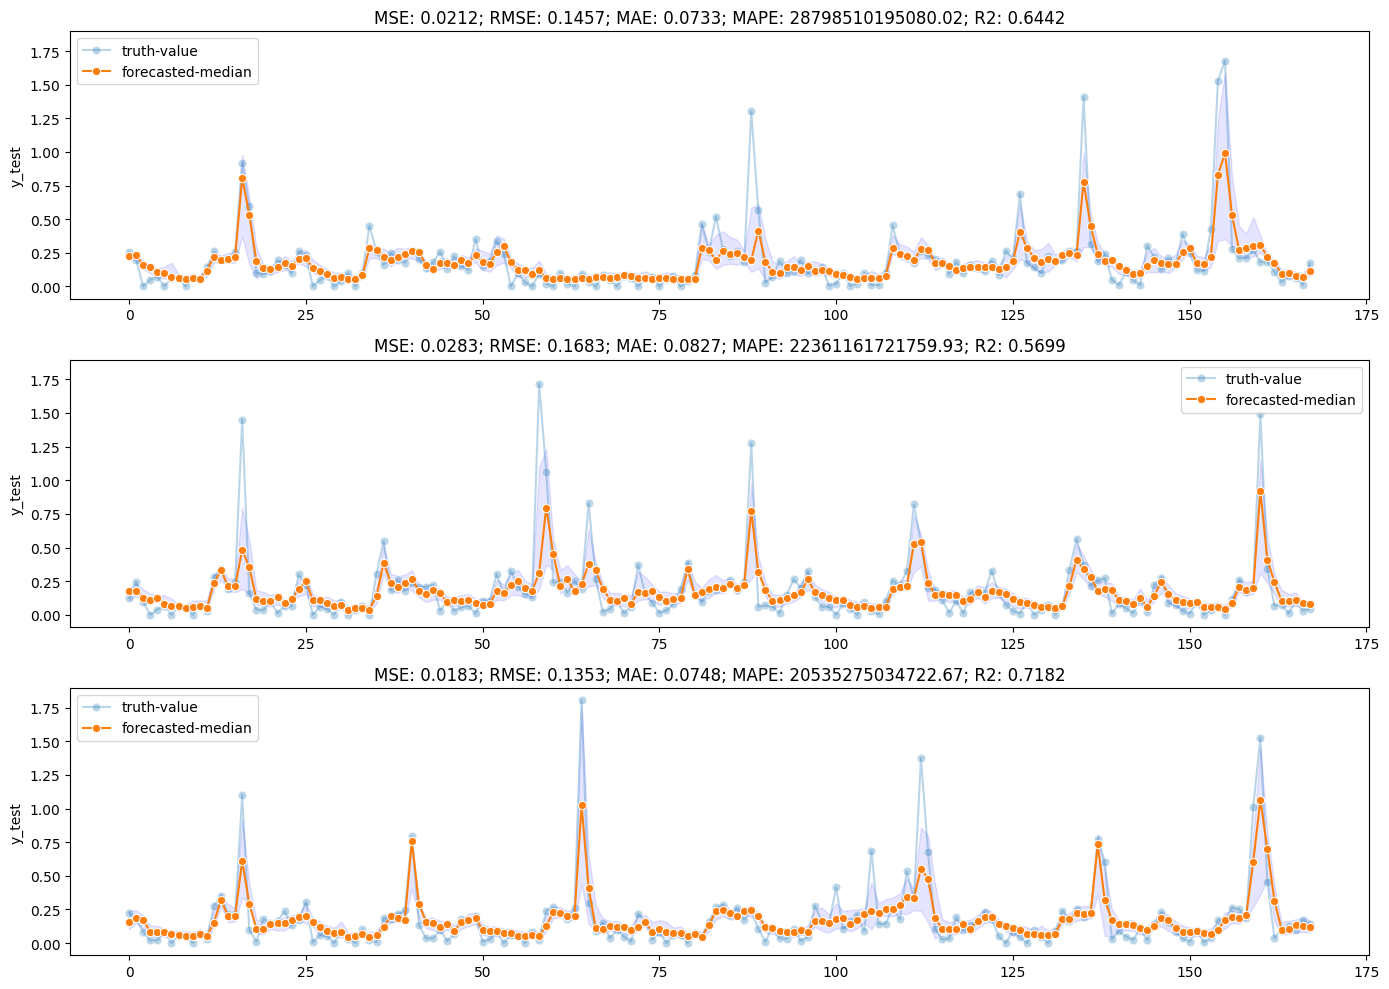

In [131]:
filtered_data = quantile_xgb_pred_by_household.loc[quantile_xgb_pred_by_household['household_id'] == 18]
plot_forecast(filtered_data[['pred_0.2', 'pred_0.5', 'pred_0.8']], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

### Quantile-LSTM

In [137]:
import tensorflow as tf

def pinball_loss(y, y_hat, alpha):
  """
    Loss function for the deep learning models
  """

  error = (y - y_hat)
  loss = tf.keras.backend.mean(
    tf.keras.backend.maximum(alpha * error, (alpha - 1) * error), 
    axis=-1
  )

  return loss

def plot_training_metrics(history):
  """
    Function to plot the training metrics of the deep learning models
  """
  training_metrics = history.history
  loss = training_metrics['loss']
  val_loss = training_metrics['val_loss']
  loss_20 = training_metrics['output_20_loss']
  val_loss_20 = training_metrics['val_output_20_loss']
  loss_50 = training_metrics['output_50_loss']
  val_loss_50 = training_metrics['val_output_50_loss']
  loss_80 = training_metrics['output_80_loss']
  val_loss_80 = training_metrics['val_output_80_loss']


  timesteps = np.arange(len(loss))
  fig, axes = plt.subplots(2, 2, sharey=True, figsize=(14, 10))

  sns.lineplot(x=timesteps, y=loss, label='loss', marker='o', ax=axes[0][0])
  sns.lineplot(x=timesteps, y=val_loss, label='val_loss', marker='o', ax=axes[0][0])
  axes[0][0].set_title("Loss vs Validation Loss")
  axes[0][0].set_xlabel("Epochs")  
  axes[0][0].set_ylabel("Overall Loss")

  sns.lineplot(x=timesteps, y=loss_20, label='loss_20', marker='o', ax=axes[0][1])
  sns.lineplot(x=timesteps, y=val_loss_20, label='val_loss_20', marker='o', ax=axes[0][1])
  axes[0][1].set_title("Loss vs Validation Loss; alpha=0.2")
  axes[0][1].set_xlabel("Epochs")  
  axes[0][1].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_50, label='loss_50', marker='o', ax=axes[1][0])
  sns.lineplot(x=timesteps, y=val_loss_50, label='val_loss_50', marker='o', ax=axes[1][0])
  axes[1][0].set_title("Loss vs Validation Loss; alpha=0.5")
  axes[1][0].set_xlabel("Epochs")  
  axes[1][0].set_ylabel("Pinball Loss")

  sns.lineplot(x=timesteps, y=loss_80, label='loss_80', marker='o', ax=axes[1][1])
  sns.lineplot(x=timesteps, y=val_loss_80, label='val_loss_80', marker='o', ax=axes[1][1])
  axes[1][1].set_title("Loss vs Validation Loss; alpha=0.8")
  axes[1][1].set_xlabel("Epochs")  
  axes[1][1].set_ylabel("Pinball Loss")

  plt.tight_layout()
  plt.show()
  

In [141]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Dense, LSTM,
    TimeDistributed, Dropout, Input
)

# for reproducibility
tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# input 
input_layer = Input(shape=(1, X_train.shape[2]))

# stacked lstm
layer = LSTM(300, return_sequences=True)(input_layer)
layer = Dropout(0.2)(layer)

# full connected layer
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)

# output
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={
        "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
        "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
        "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
    }
)

history = model.fit(
    X_train,
    y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=168,
    callbacks=[earlystop]
)

Epoch 1/50
4087/4087 [==============================] - 33s 8ms/step - loss: 2.9423 - output_20_loss: 0.0596 - output_50_loss: 0.1045 - output_80_loss: 0.1018 - val_loss: 0.2812 - val_output_20_loss: 0.0634 - val_output_50_loss: 0.1026 - val_output_80_loss: 0.0921
Epoch 2/50
4087/4087 [==============================] - 30s 7ms/step - loss: 0.2387 - output_20_loss: 0.0529 - output_50_loss: 0.0864 - output_80_loss: 0.0781 - val_loss: 0.2495 - val_output_20_loss: 0.0589 - val_output_50_loss: 0.0912 - val_output_80_loss: 0.0802
Epoch 3/50
4087/4087 [==============================] - 30s 7ms/step - loss: 0.2209 - output_20_loss: 0.0505 - output_50_loss: 0.0801 - output_80_loss: 0.0713 - val_loss: 0.2327 - val_output_20_loss: 0.0561 - val_output_50_loss: 0.0849 - val_output_80_loss: 0.0734
Epoch 4/50
4087/4087 [==============================] - 30s 7ms/step - loss: 0.2069 - output_20_loss: 0.0483 - output_50_loss: 0.0748 - output_80_loss: 0.0654 - val_loss: 0.2140 - val_output_20_loss: 0.052

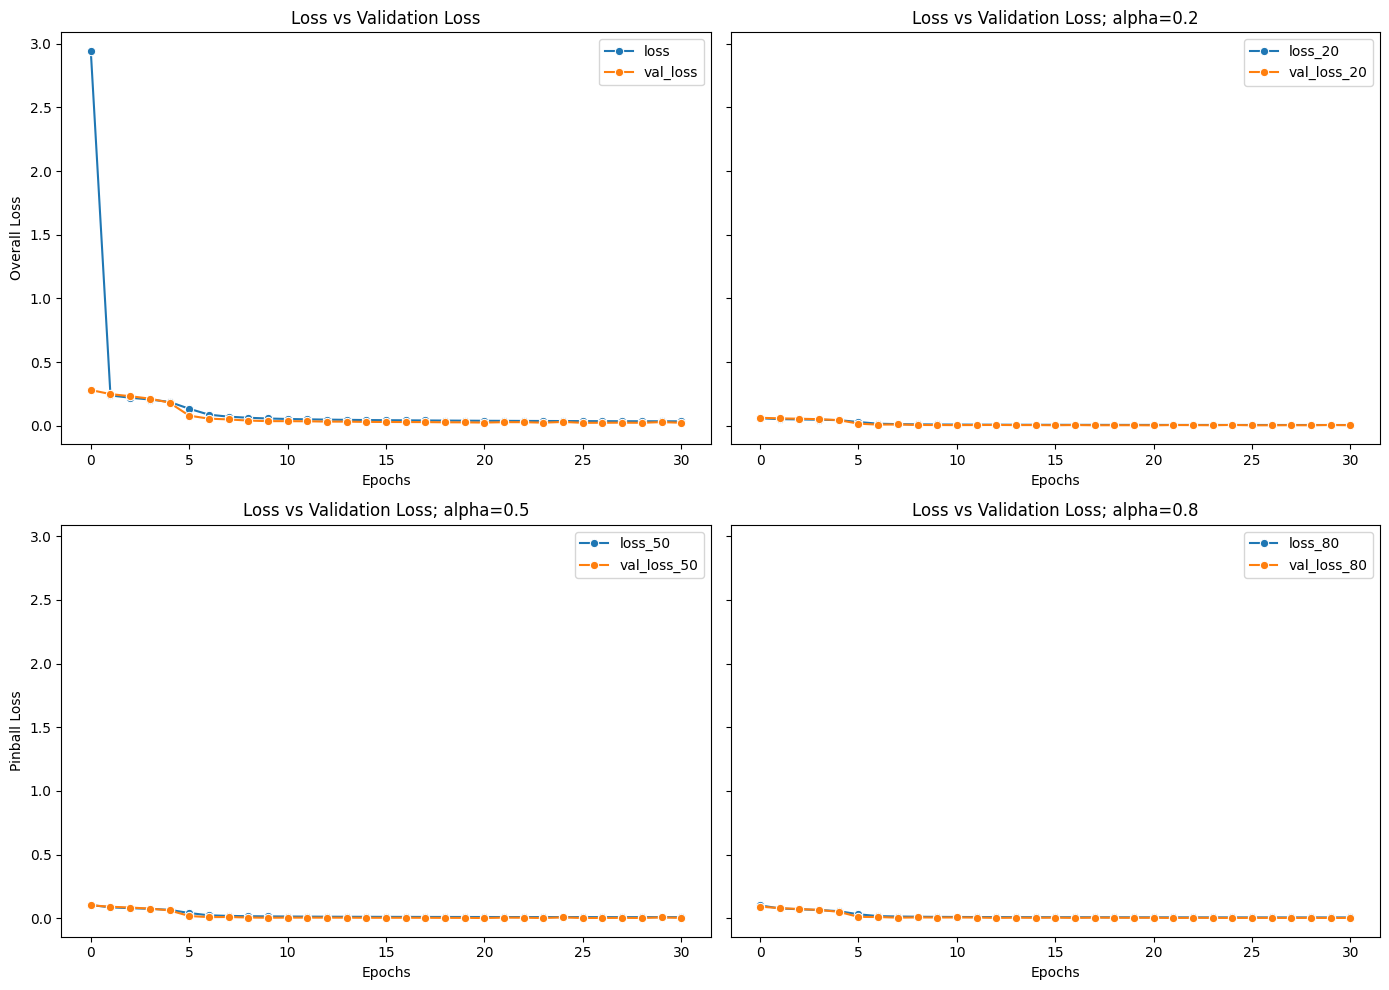

In [142]:
plot_training_metrics(history)

In [147]:
y_pred = model.predict(X_test)

y_pred = {
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
}

y_pred = pd.DataFrame(y_pred)

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 4s 2ms/step
RMSE: 0.011846935581188942
MSE: 0.00014034988266484059
MAE: 0.005904355382867501
MAPE: 0.0345086575477369
R2 Score: 0.9996546914327078
Adjusted R2 Score: 0.9996546869078095
Pinball loss with alpha 0.2: 0.017221569943603163
Pinball loss with alpha 0.5: 0.0029521776914337504
Pinball loss with alpha 0.8: 0.01496432335104749


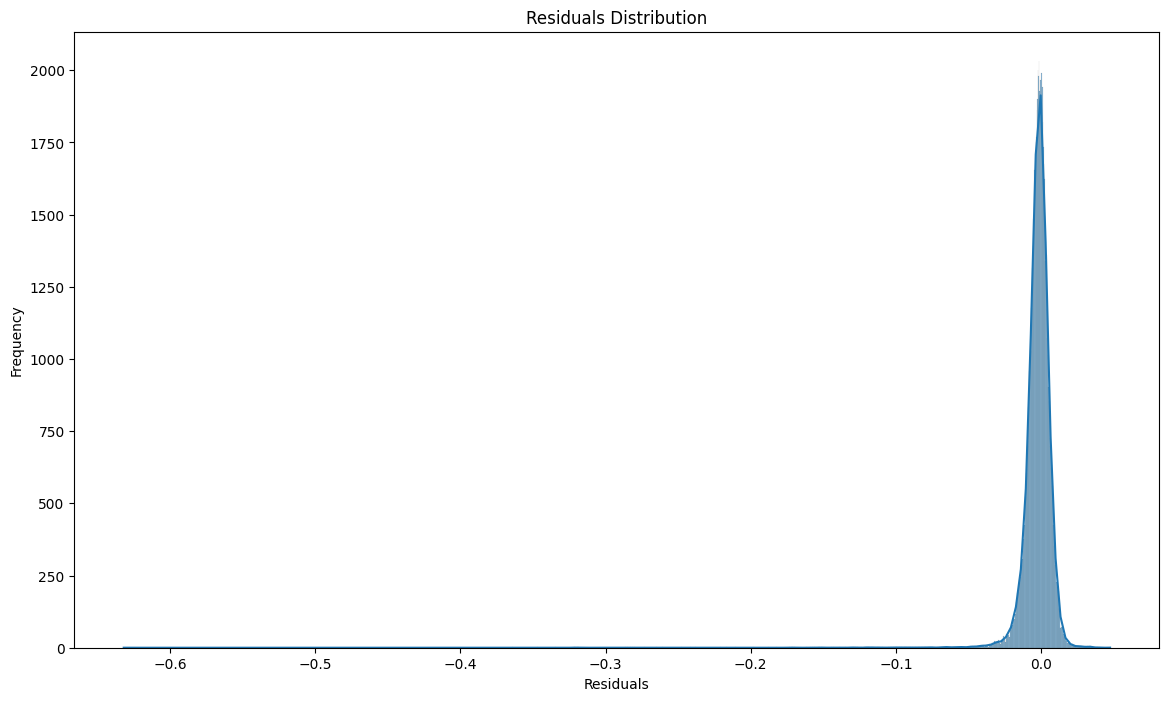

In [149]:
residuals = calculate_error(y_pred['pred_0.5'], y_test.reset_index()['energy(kWh/hh)'])

plot_error_distribution(residuals)

In [150]:
# prepare the prediction dataframe with household and testing data
quantile_lstm_pred_by_household = pd.DataFrame(np.hstack([y_pred.values.reshape(-1, 3), y_test_with_ids[['household_ids', 'y_test']].to_numpy().reshape(-1, 2)]), columns=['pred_0.2', 'pred_0.5', 'pred_0.8', 'household_id', 'y_test'])
quantile_lstm_pred_by_household['household_id'] = quantile_lstm_pred_by_household['household_id'].astype('int8')

# prepare the household grp
quantile_lstm_hhgroup = quantile_lstm_pred_by_household.groupby('household_id')

# calculate the metrics for each individual group
quantile_lstm_metrics = quantile_lstm_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['pred_0.5'])).reset_index()
quantile_lstm_metrics['rmse'] = quantile_lstm_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['pred_0.5'], squared=False)).values
quantile_lstm_metrics['mae'] = quantile_lstm_hhgroup.apply(lambda x: mean_absolute_error(x['y_test'], x['pred_0.5'])).values
quantile_lstm_metrics['mape'] = quantile_lstm_hhgroup.apply(lambda x: mean_absolute_percentage_error(x['y_test'], x['pred_0.5'])).values
quantile_lstm_metrics['r2'] = quantile_lstm_hhgroup.apply(lambda x: r2_score(x['y_test'], x['pred_0.5'])).values
quantile_lstm_metrics['adjusted_r2'] = quantile_lstm_hhgroup.apply(lambda x: adjusted_r2(x['y_test'], x['pred_0.5'])).values
quantile_lstm_metrics = quantile_lstm_metrics.rename(columns={ 0: 'mse'})

# pinball losses
quantile_lstm_metrics['pinball_0.2'] = quantile_lstm_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.2'], x['y_test'], alpha=0.2)).values
quantile_lstm_metrics['pinball_0.5'] = quantile_lstm_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.5'], x['y_test'], alpha=0.5)).values
quantile_lstm_metrics['pinball_0.8'] = quantile_lstm_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.8'], x['y_test'], alpha=0.8)).values


<Figure size 1400x800 with 0 Axes>

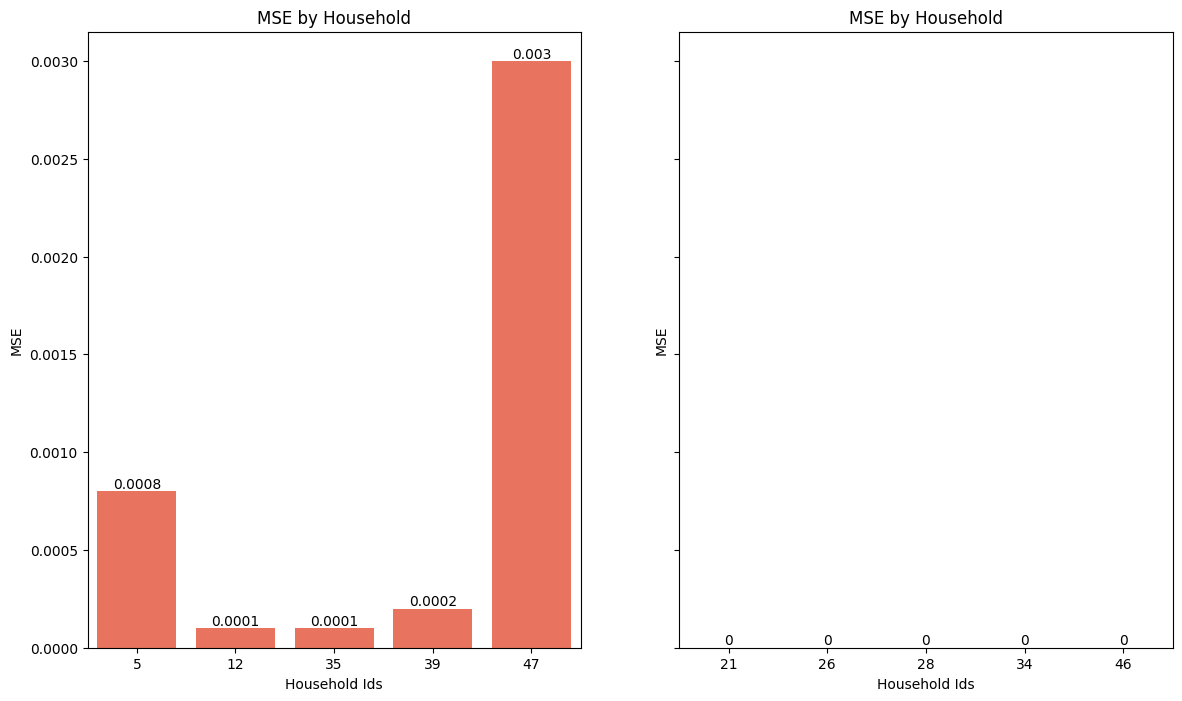

In [152]:
top5_metric = quantile_lstm_metrics.sort_values(by='mse', ascending=False).head(5)
bottom5_metric = quantile_lstm_metrics.sort_values(by='mse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mse')

<Figure size 1400x800 with 0 Axes>

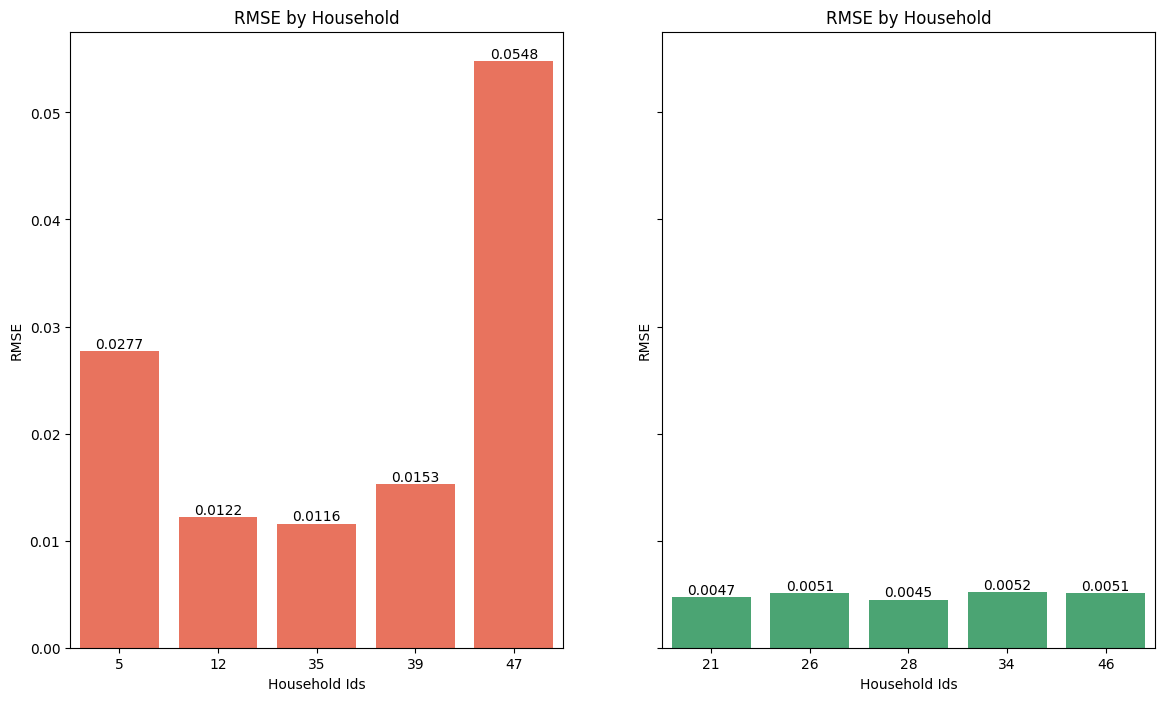

In [153]:
top5_metric = quantile_lstm_metrics.sort_values(by='rmse', ascending=False).head(5)
bottom5_metric = quantile_lstm_metrics.sort_values(by='rmse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'rmse')

<Figure size 1400x800 with 0 Axes>

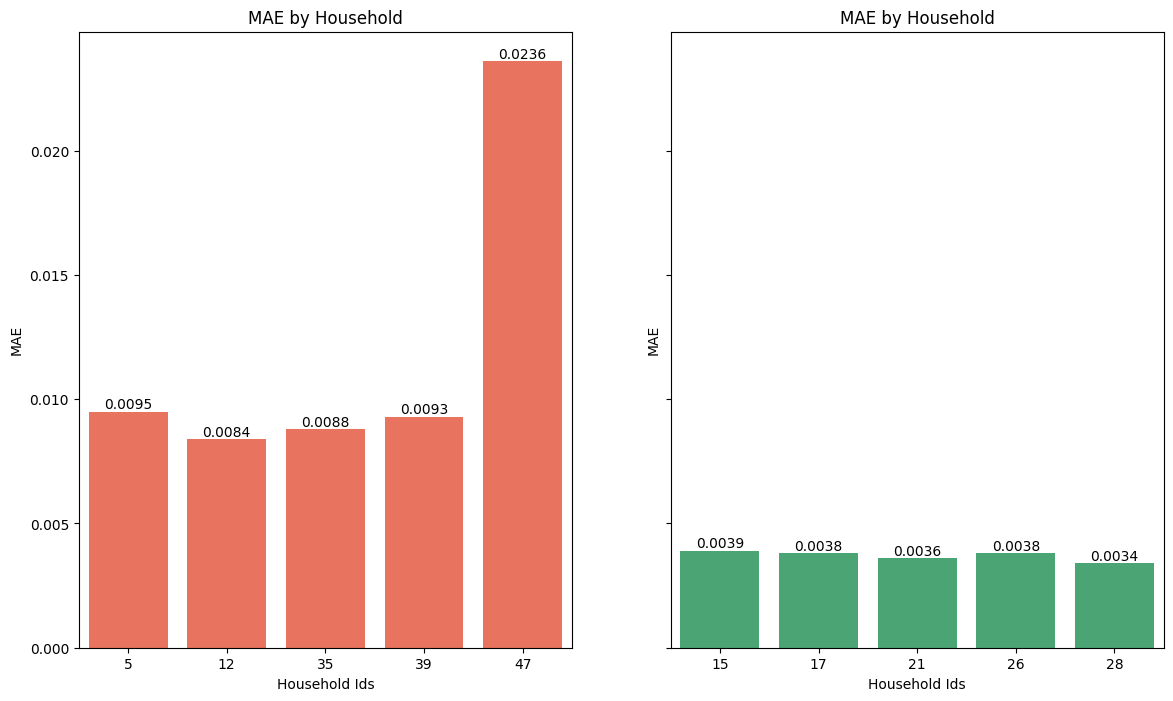

In [154]:
top5_metric = quantile_lstm_metrics.sort_values(by='mae', ascending=False).head(5)
bottom5_metric = quantile_lstm_metrics.sort_values(by='mae', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mae')

<Figure size 1400x800 with 0 Axes>

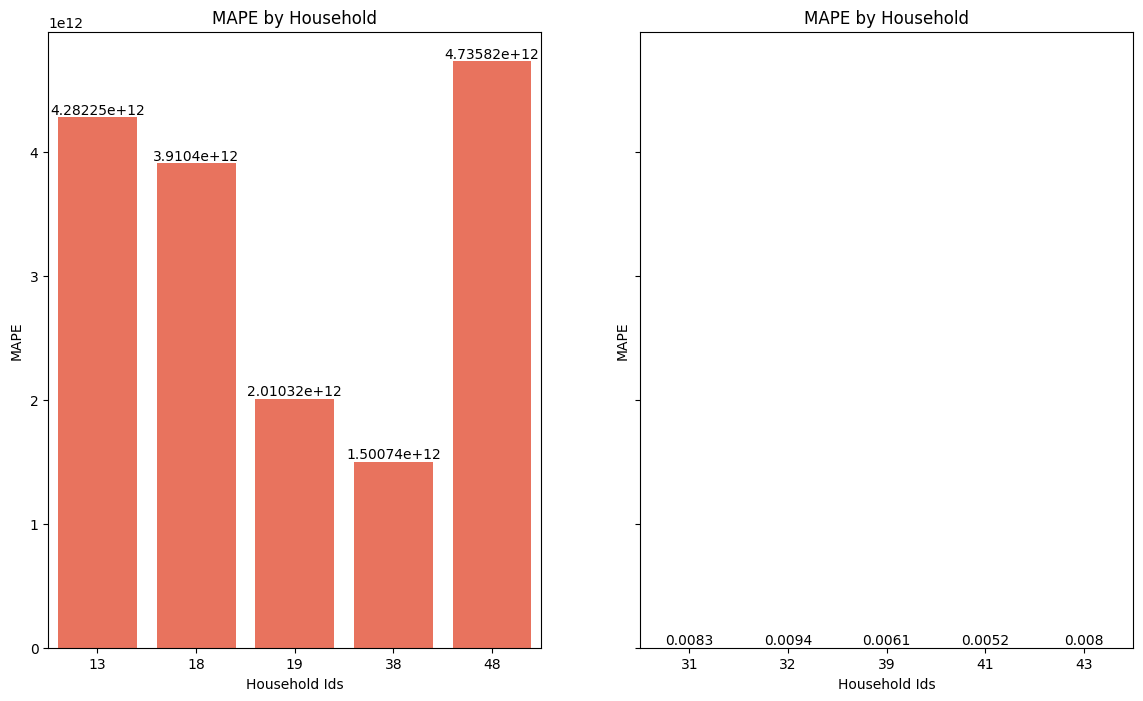

In [155]:
top5_metric = quantile_lstm_metrics.sort_values(by='mape', ascending=False).head(5)
bottom5_metric = quantile_lstm_metrics.sort_values(by='mape', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mape')

<Figure size 1400x800 with 0 Axes>

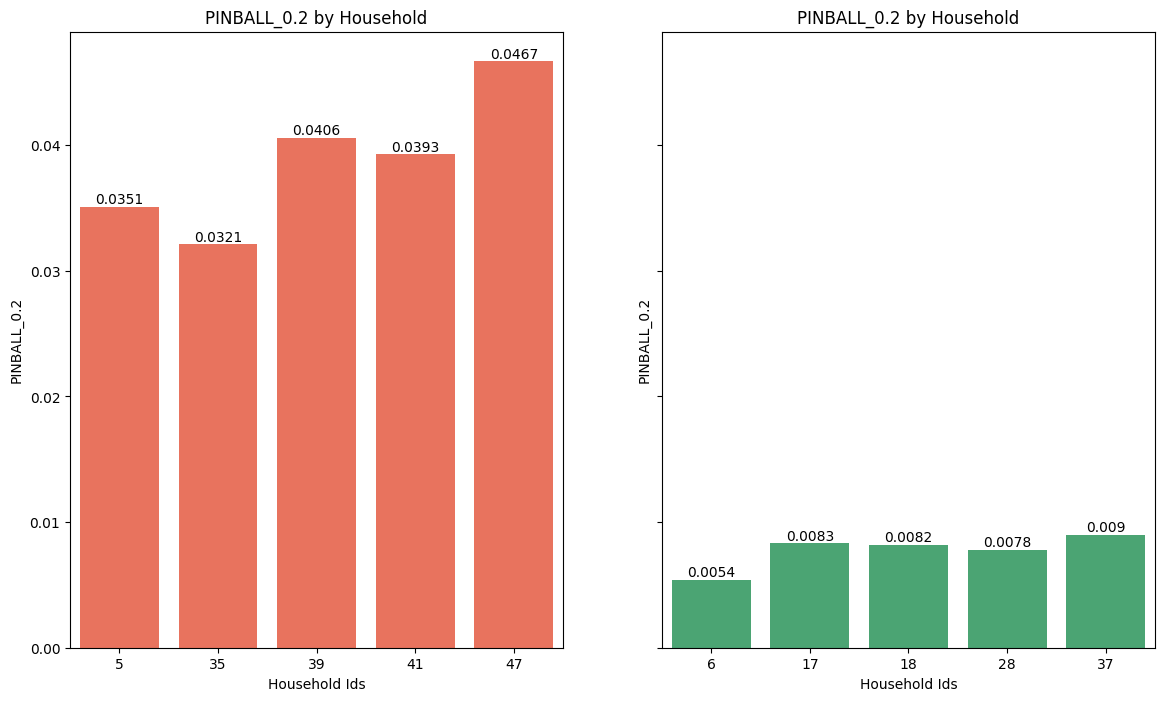

In [156]:
top5_metric = quantile_lstm_metrics.sort_values(by='pinball_0.2', ascending=False).head(5)
bottom5_metric = quantile_lstm_metrics.sort_values(by='pinball_0.2', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.2')

<Figure size 1400x800 with 0 Axes>

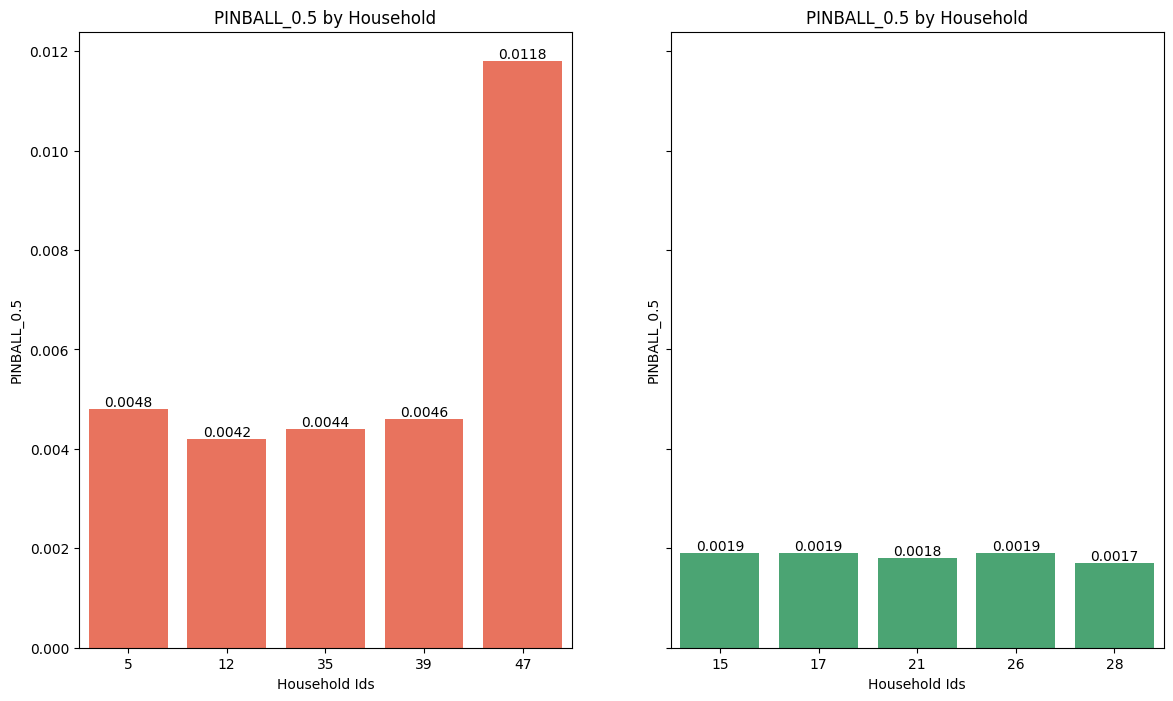

In [157]:
top5_metric = quantile_lstm_metrics.sort_values(by='pinball_0.5', ascending=False).head(5)
bottom5_metric = quantile_lstm_metrics.sort_values(by='pinball_0.5', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.5')

<Figure size 1400x800 with 0 Axes>

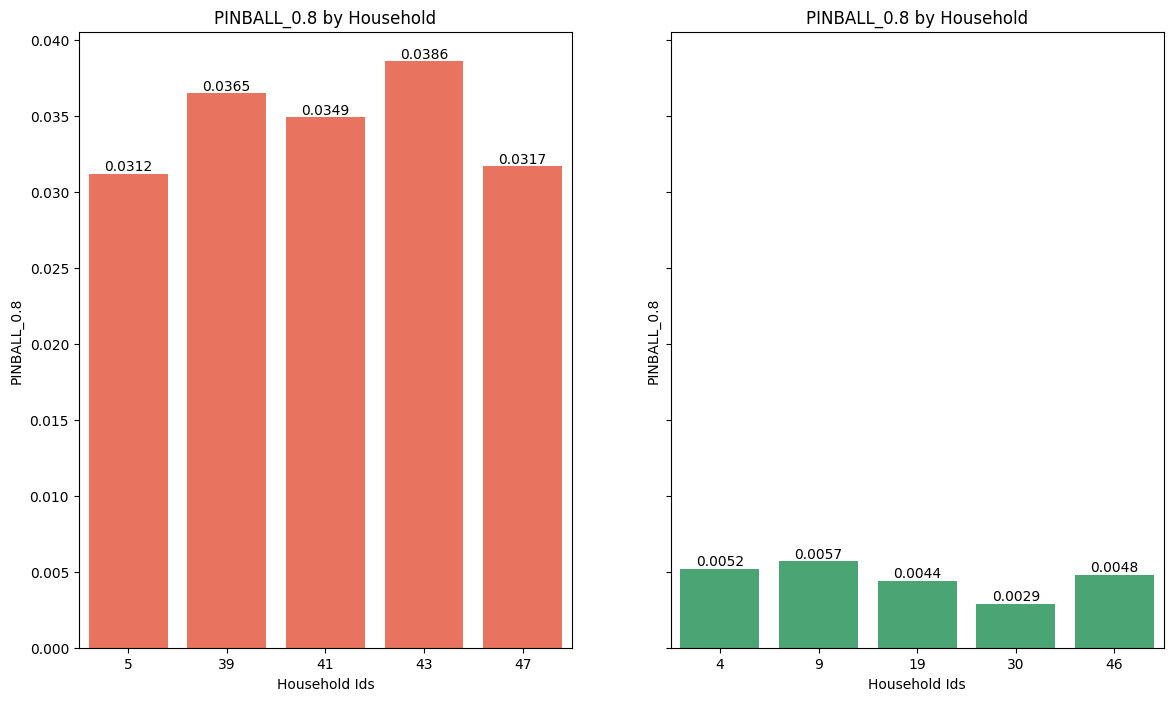

In [158]:
top5_metric = quantile_lstm_metrics.sort_values(by='pinball_0.8', ascending=False).head(5)
bottom5_metric = quantile_lstm_metrics.sort_values(by='pinball_0.8', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.8')

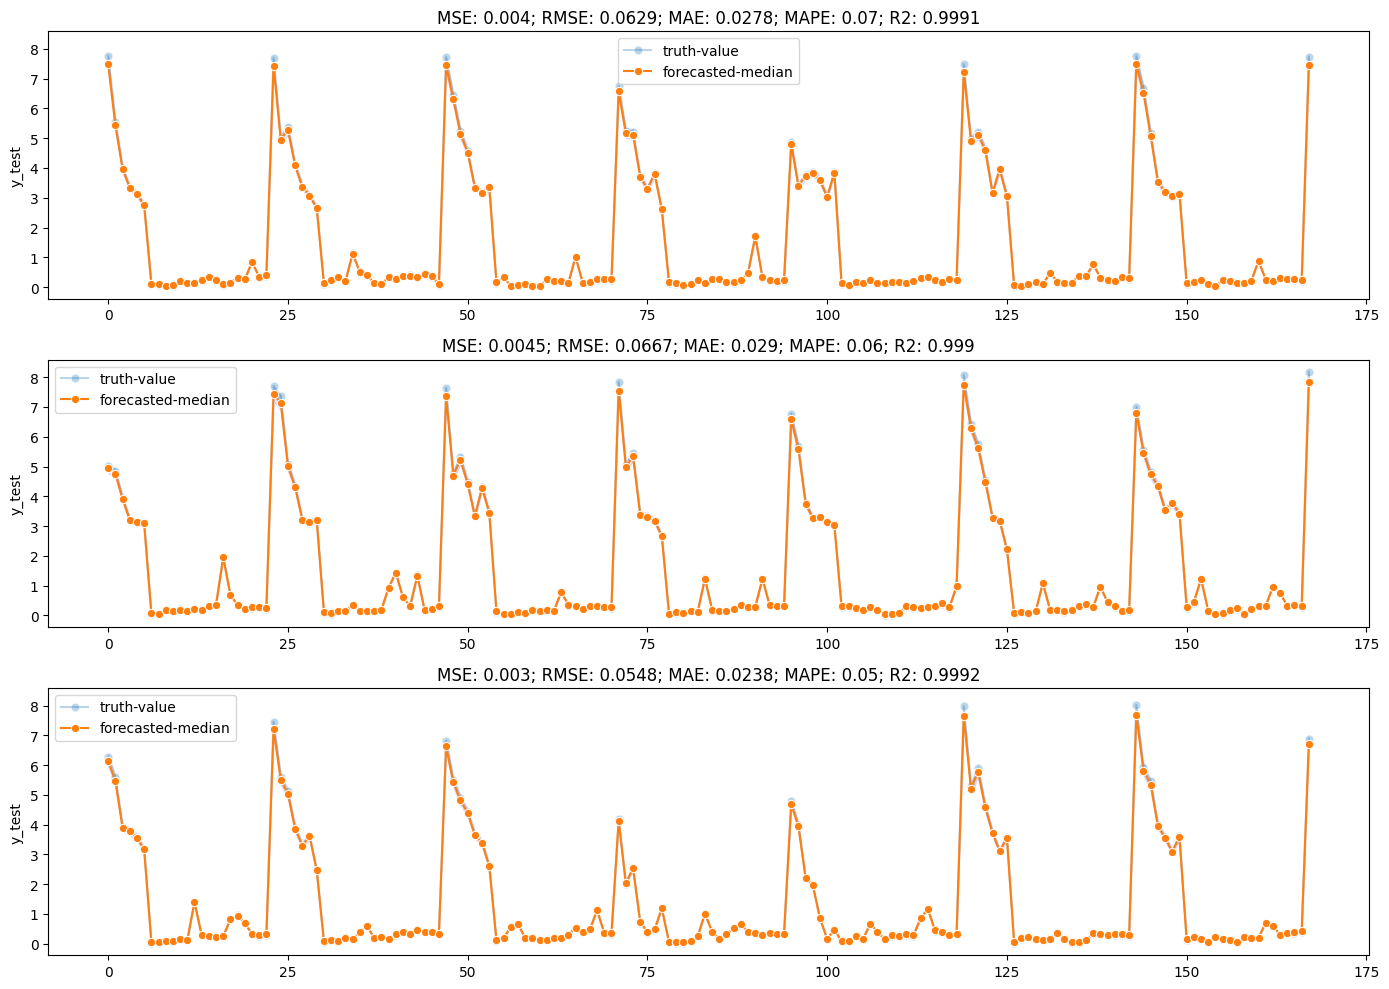

In [166]:
filtered_data = quantile_lstm_pred_by_household.loc[quantile_lstm_pred_by_household['household_id'] == 47]
plot_forecast(filtered_data[['pred_0.2', 'pred_0.5', 'pred_0.8']], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

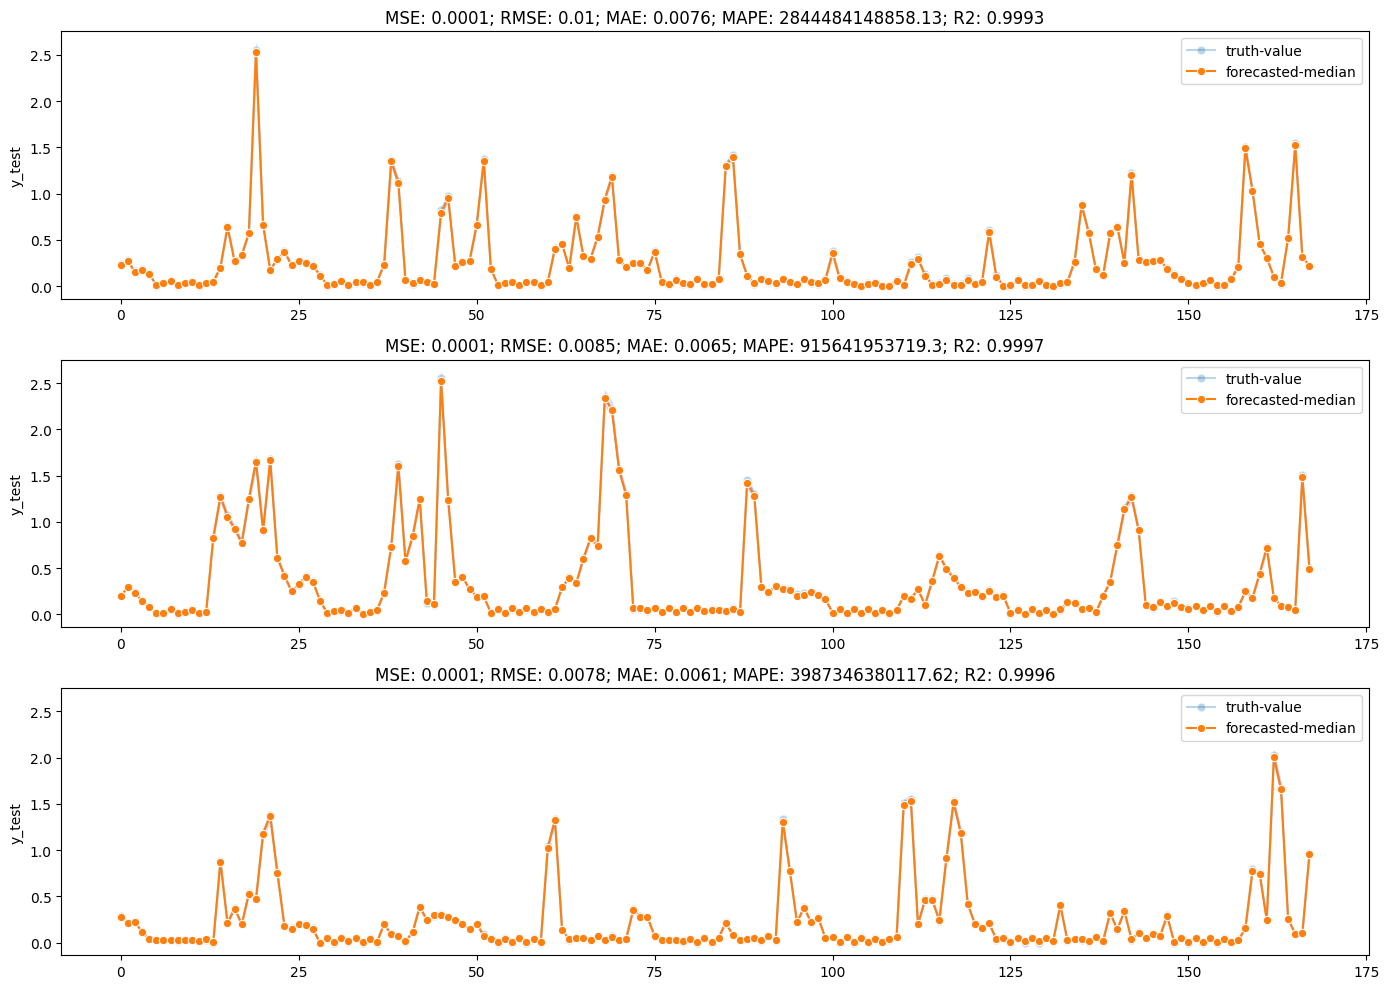

In [167]:
filtered_data = quantile_lstm_pred_by_household.loc[quantile_lstm_pred_by_household['household_id'] == 48]
plot_forecast(filtered_data[['pred_0.2', 'pred_0.5', 'pred_0.8']], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

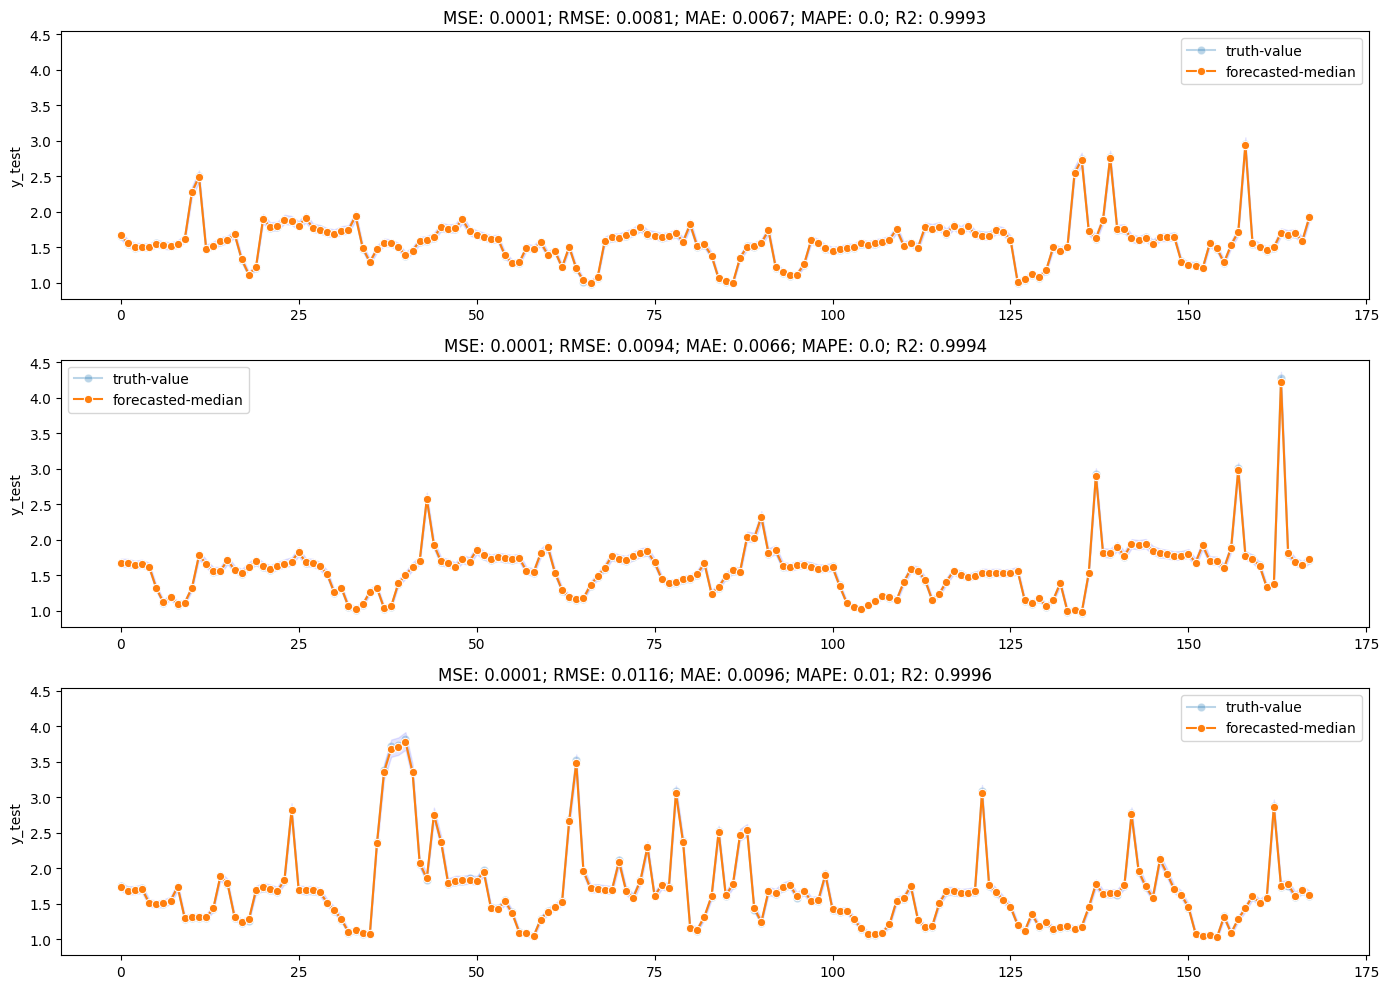

In [168]:
filtered_data = quantile_lstm_pred_by_household.loc[quantile_lstm_pred_by_household['household_id'] == 43]
plot_forecast(filtered_data[['pred_0.2', 'pred_0.5', 'pred_0.8']], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

### Quantile-GRU

In [162]:
from tensorflow.keras.layers import (
  Dense, GRU, TimeDistributed, 
  Dropout, Input
)
from tensorflow.keras.models import Model
import tensorflow as tf

tf.random.set_seed(42)
tf.keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

### Create Model
input_layer = Input(shape=(1, X_train.shape[2]))
layer = GRU(100, return_sequences=True)(input_layer)
layer = Dropout(0.4)(layer)
layer = TimeDistributed(Dense(168, activation='relu', kernel_regularizer='l1'))(layer)
layer = TimeDistributed(Dense(64, activation='relu'))(layer)
output_layer_20 = TimeDistributed(Dense(1), name="output_20")(layer)
output_layer_50 = TimeDistributed(Dense(1), name="output_50")(layer)
output_layer_80 = TimeDistributed(Dense(1), name="output_80")(layer)
model = Model(inputs=[input_layer], outputs=[output_layer_20, output_layer_50, output_layer_80])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
  loss={
    "output_20": lambda y, y_hat: pinball_loss(y, y_hat, 0.2),
    "output_50": lambda y, y_hat: pinball_loss(y, y_hat, 0.5),
    "output_80": lambda y, y_hat: pinball_loss(y, y_hat, 0.8)
  }
)

history = model.fit(
  X_train,
  [y_train, y_train, y_train],
  epochs=50,
  validation_data=(X_test, [y_test, y_test, y_test]),
  batch_size=168,
  callbacks=[earlystop]
)

Epoch 1/50
4087/4087 [==============================] - 36s 9ms/step - loss: 0.4001 - output_20_loss: 0.0517 - output_50_loss: 0.0843 - output_80_loss: 0.0749 - val_loss: 0.1715 - val_output_20_loss: 0.0404 - val_output_50_loss: 0.0549 - val_output_80_loss: 0.0438
Epoch 2/50
4087/4087 [==============================] - 35s 8ms/step - loss: 0.1170 - output_20_loss: 0.0238 - output_50_loss: 0.0352 - output_80_loss: 0.0267 - val_loss: 0.0820 - val_output_20_loss: 0.0180 - val_output_50_loss: 0.0206 - val_output_80_loss: 0.0144
Epoch 3/50
4087/4087 [==============================] - 34s 8ms/step - loss: 0.0920 - output_20_loss: 0.0181 - output_50_loss: 0.0266 - output_80_loss: 0.0198 - val_loss: 0.0939 - val_output_20_loss: 0.0247 - val_output_50_loss: 0.0306 - val_output_80_loss: 0.0121
Epoch 4/50
4087/4087 [==============================] - 33s 8ms/step - loss: 0.0849 - output_20_loss: 0.0167 - output_50_loss: 0.0244 - output_80_loss: 0.0180 - val_loss: 0.0566 - val_output_20_loss: 0.011

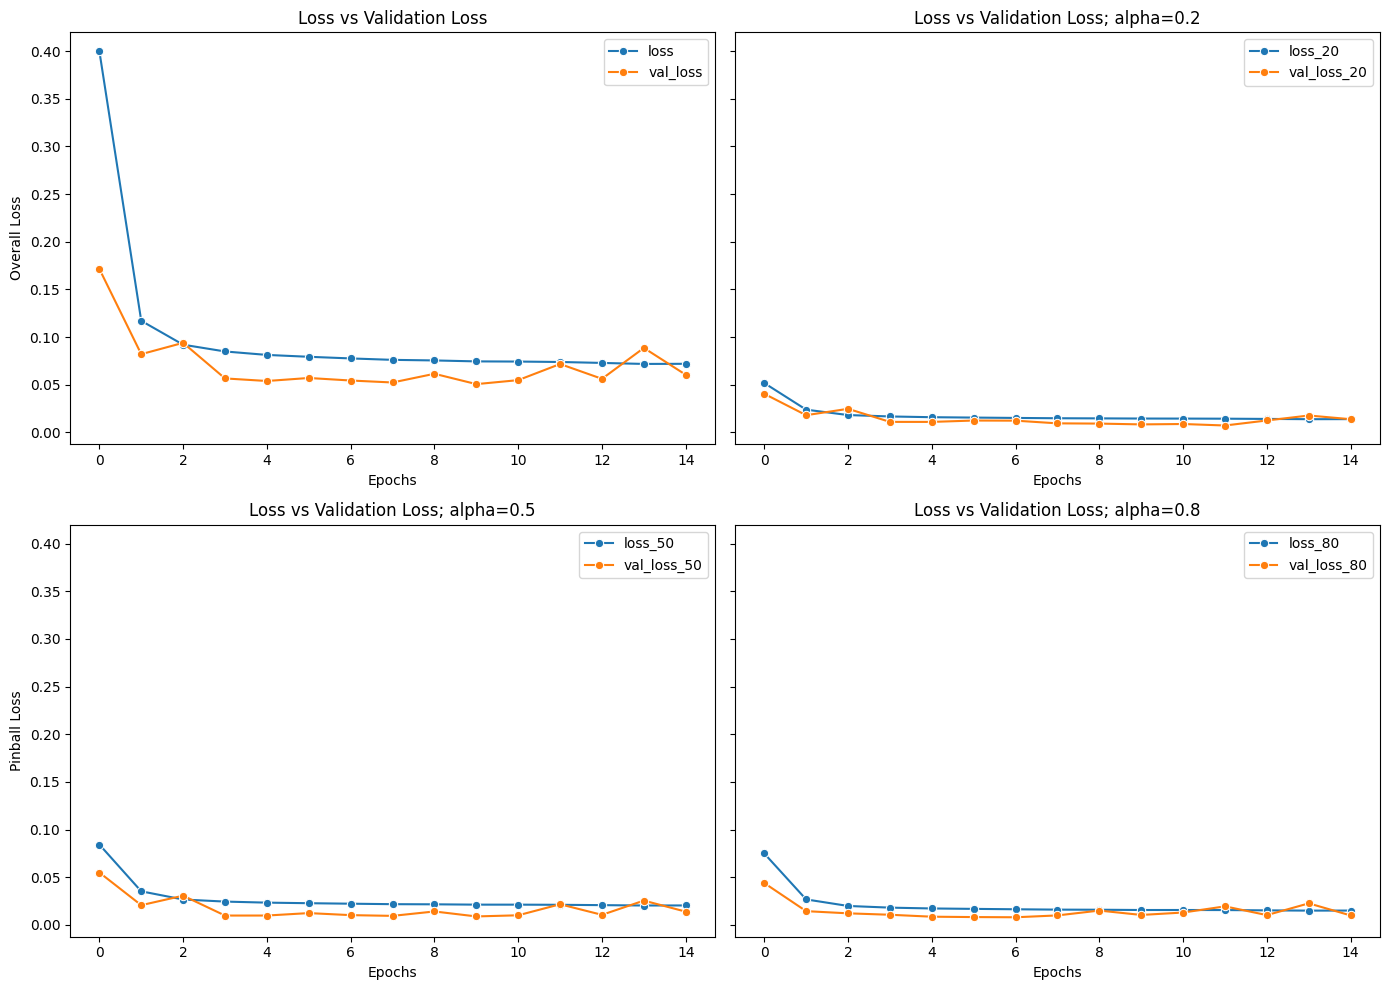

In [169]:
plot_training_metrics(history)

In [170]:
y_pred = model.predict(X_test)

y_pred = {
  'pred_0.2': y_pred[0].ravel(),
  'pred_0.5': y_pred[1].ravel(),
  'pred_0.8': y_pred[2].ravel()
}

y_pred = pd.DataFrame(y_pred)

evaluate_model(y_pred, y_test)

2385/2385 [==============================] - 4s 2ms/step
RMSE: 0.02784695279091264
MSE: 0.0007754527797393172
MAE: 0.01758696043662278
MAPE: 0.08403869103495616
R2 Score: 0.9980351033395182
Adjusted R2 Score: 0.9980350775916553
Pinball loss with alpha 0.2: 0.029861684573835798
Pinball loss with alpha 0.5: 0.00879348021831139
Pinball loss with alpha 0.8: 0.04113613681602916


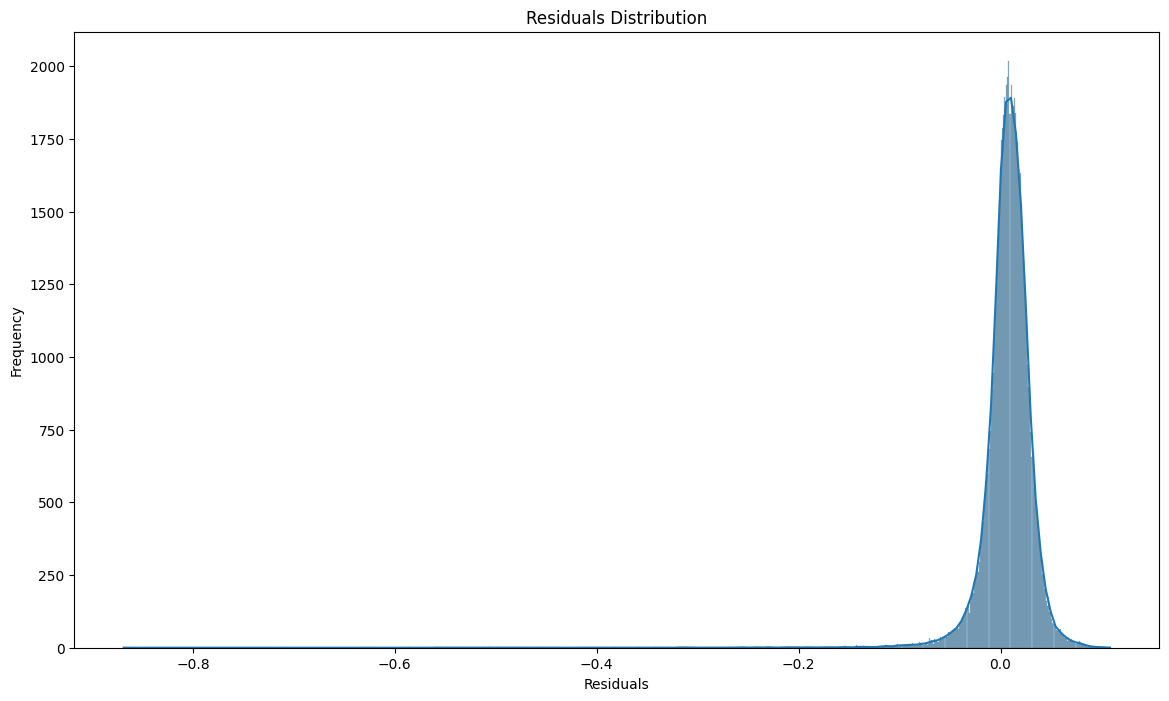

In [171]:
residuals = calculate_error(y_pred['pred_0.5'], y_test.reset_index()['energy(kWh/hh)'])

plot_error_distribution(residuals)

In [172]:
# prepare the prediction dataframe with household and testing data
quantile_gru_pred_by_household = pd.DataFrame(np.hstack([y_pred.values.reshape(-1, 3), y_test_with_ids[['household_ids', 'y_test']].to_numpy().reshape(-1, 2)]), columns=['pred_0.2', 'pred_0.5', 'pred_0.8', 'household_id', 'y_test'])
quantile_gru_pred_by_household['household_id'] = quantile_gru_pred_by_household['household_id'].astype('int8')

# prepare the household grp
quantile_gru_hhgroup = quantile_gru_pred_by_household.groupby('household_id')

# calculate the metrics for each individual group
quantile_gru_metrics = quantile_gru_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['pred_0.5'])).reset_index()
quantile_gru_metrics['rmse'] = quantile_gru_hhgroup.apply(lambda x: mean_squared_error(x['y_test'], x['pred_0.5'], squared=False)).values
quantile_gru_metrics['mae'] = quantile_gru_hhgroup.apply(lambda x: mean_absolute_error(x['y_test'], x['pred_0.5'])).values
quantile_gru_metrics['mape'] = quantile_gru_hhgroup.apply(lambda x: mean_absolute_percentage_error(x['y_test'], x['pred_0.5'])).values
quantile_gru_metrics['r2'] = quantile_gru_hhgroup.apply(lambda x: r2_score(x['y_test'], x['pred_0.5'])).values
quantile_gru_metrics['adjusted_r2'] = quantile_gru_hhgroup.apply(lambda x: adjusted_r2(x['y_test'], x['pred_0.5'])).values
quantile_gru_metrics = quantile_gru_metrics.rename(columns={ 0: 'mse'})

# pinball losses
quantile_gru_metrics['pinball_0.2'] = quantile_gru_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.2'], x['y_test'], alpha=0.2)).values
quantile_gru_metrics['pinball_0.5'] = quantile_gru_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.5'], x['y_test'], alpha=0.5)).values
quantile_gru_metrics['pinball_0.8'] = quantile_gru_hhgroup.apply(lambda x: mean_pinball_loss(x['pred_0.8'], x['y_test'], alpha=0.8)).values


<Figure size 1400x800 with 0 Axes>

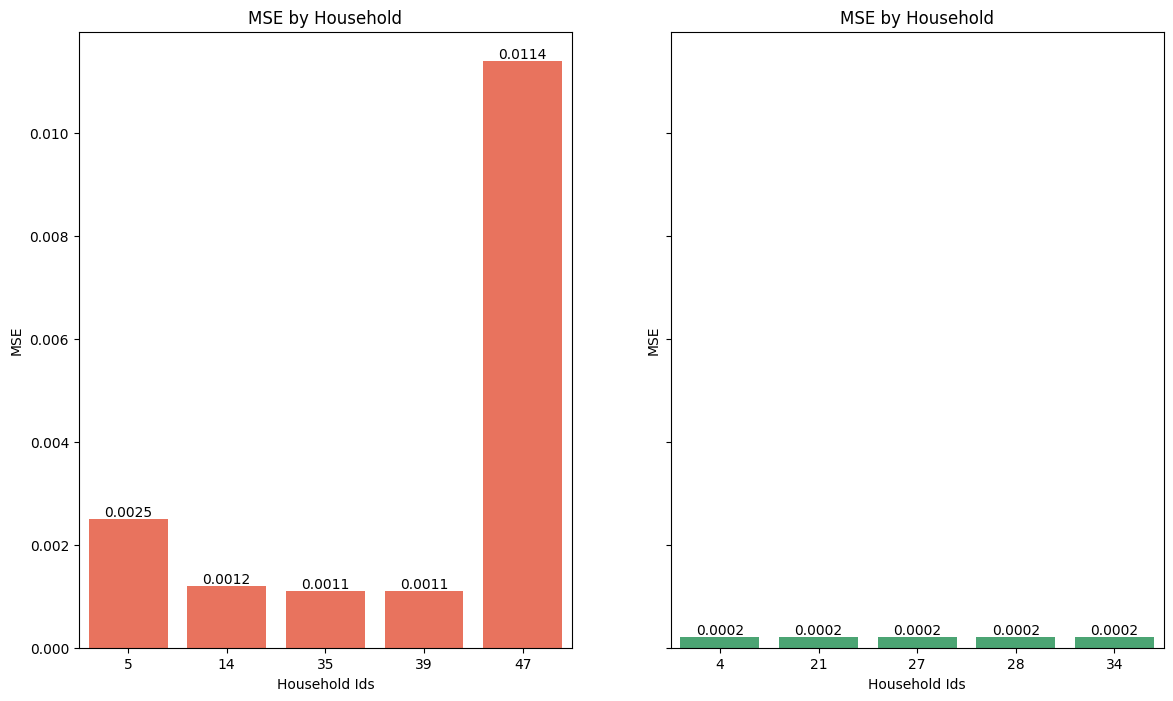

In [173]:
top5_metric = quantile_gru_metrics.sort_values(by='mse', ascending=False).head(5)
bottom5_metric = quantile_gru_metrics.sort_values(by='mse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mse')

<Figure size 1400x800 with 0 Axes>

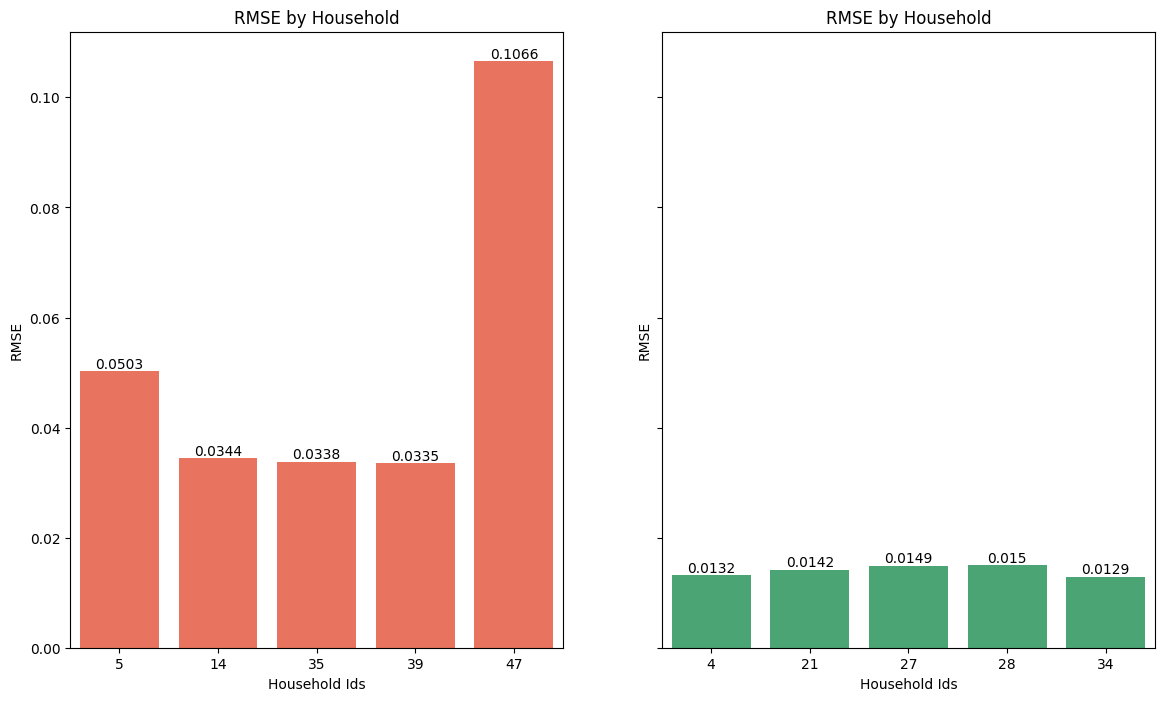

In [174]:
top5_metric = quantile_gru_metrics.sort_values(by='rmse', ascending=False).head(5)
bottom5_metric = quantile_gru_metrics.sort_values(by='rmse', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'rmse')

<Figure size 1400x800 with 0 Axes>

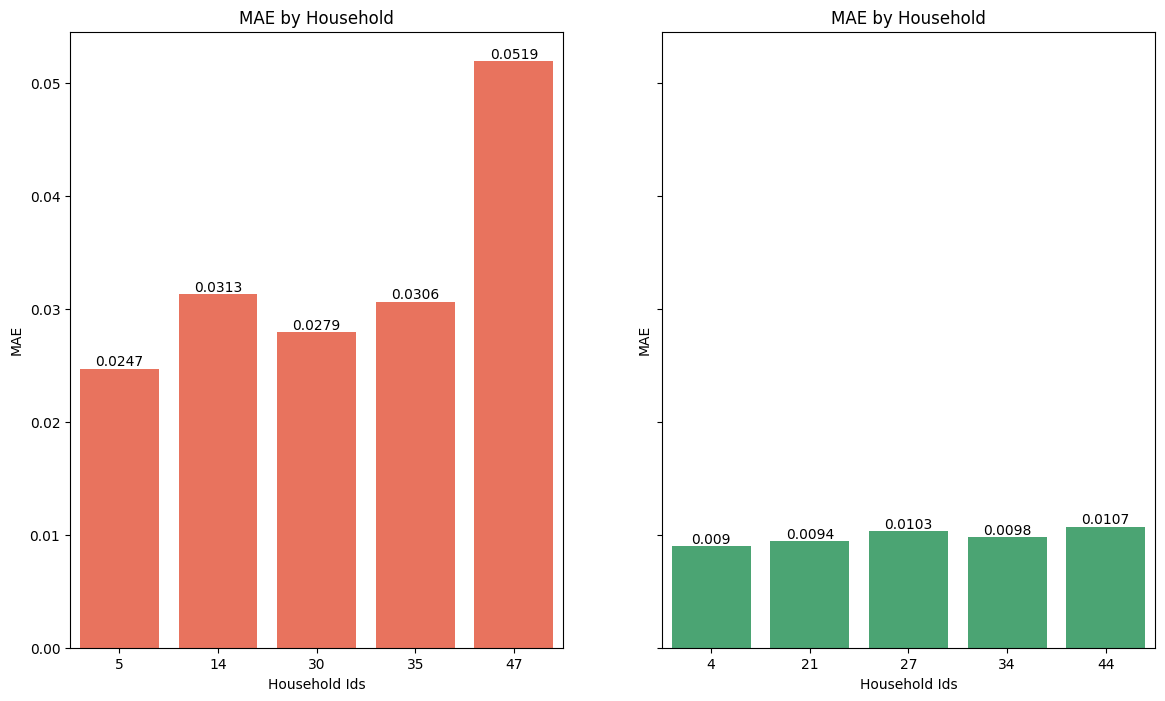

In [175]:
top5_metric = quantile_gru_metrics.sort_values(by='mae', ascending=False).head(5)
bottom5_metric = quantile_gru_metrics.sort_values(by='mae', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mae')

<Figure size 1400x800 with 0 Axes>

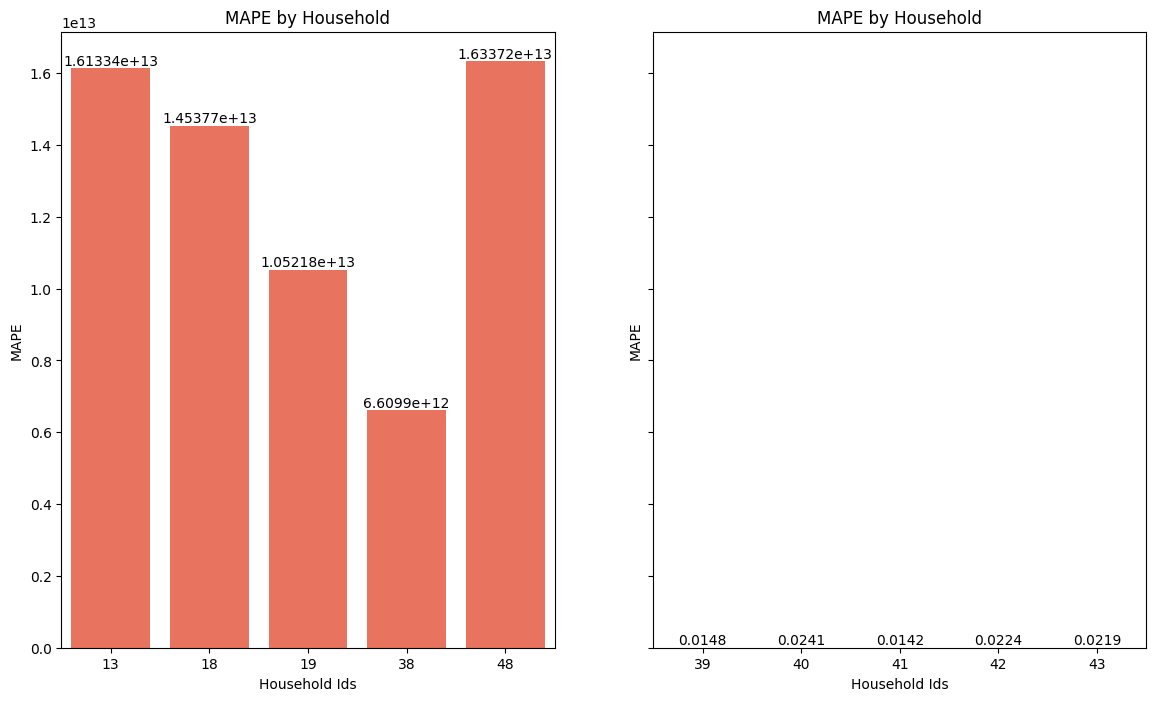

In [176]:
top5_metric = quantile_gru_metrics.sort_values(by='mape', ascending=False).head(5)
bottom5_metric = quantile_gru_metrics.sort_values(by='mape', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'mape')

<Figure size 1400x800 with 0 Axes>

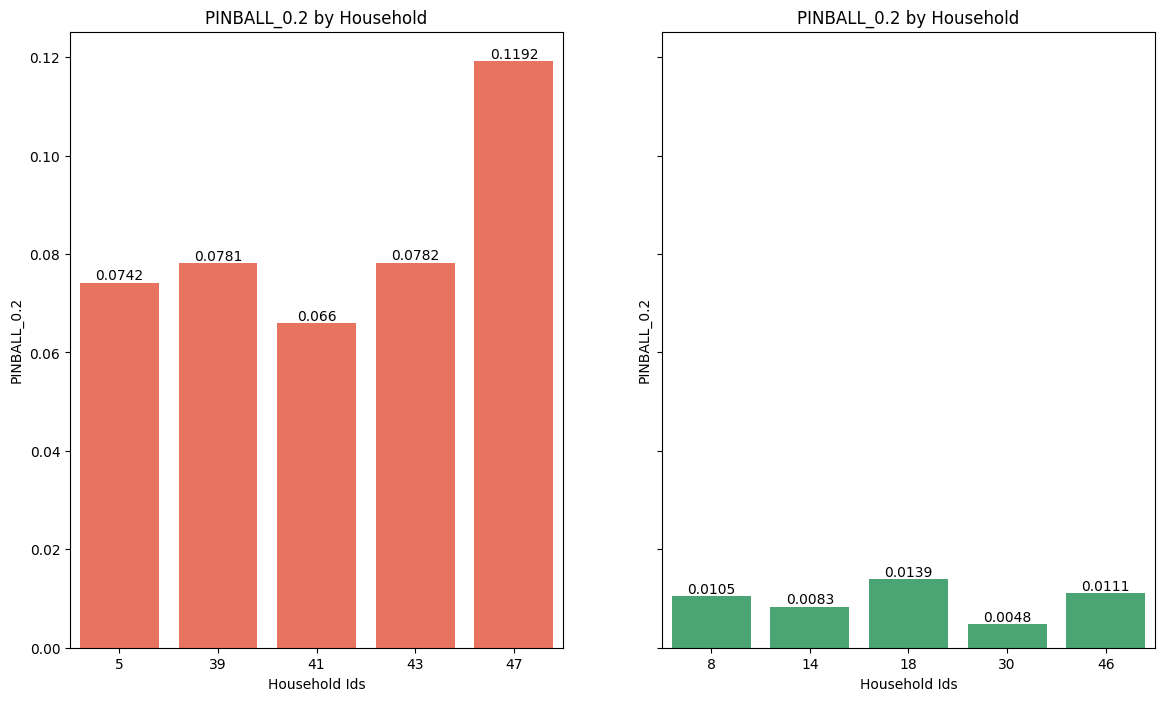

In [177]:
top5_metric = quantile_gru_metrics.sort_values(by='pinball_0.2', ascending=False).head(5)
bottom5_metric = quantile_gru_metrics.sort_values(by='pinball_0.2', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.2')

<Figure size 1400x800 with 0 Axes>

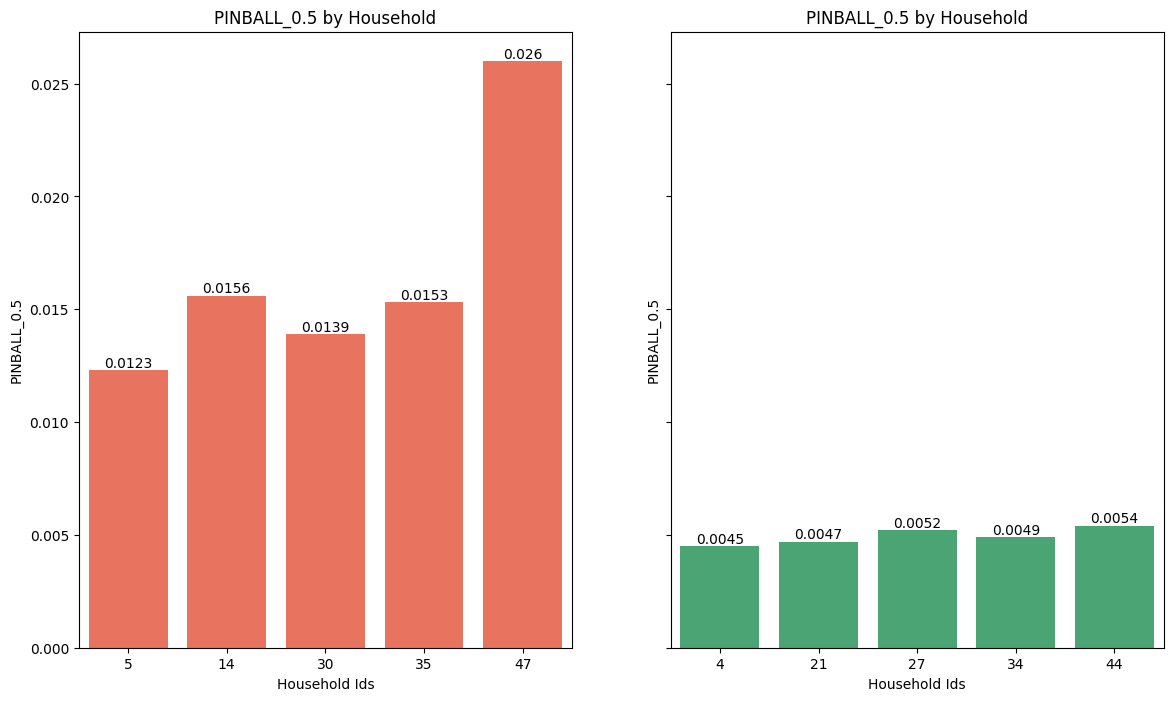

In [178]:
top5_metric = quantile_gru_metrics.sort_values(by='pinball_0.5', ascending=False).head(5)
bottom5_metric = quantile_gru_metrics.sort_values(by='pinball_0.5', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.5')

<Figure size 1400x800 with 0 Axes>

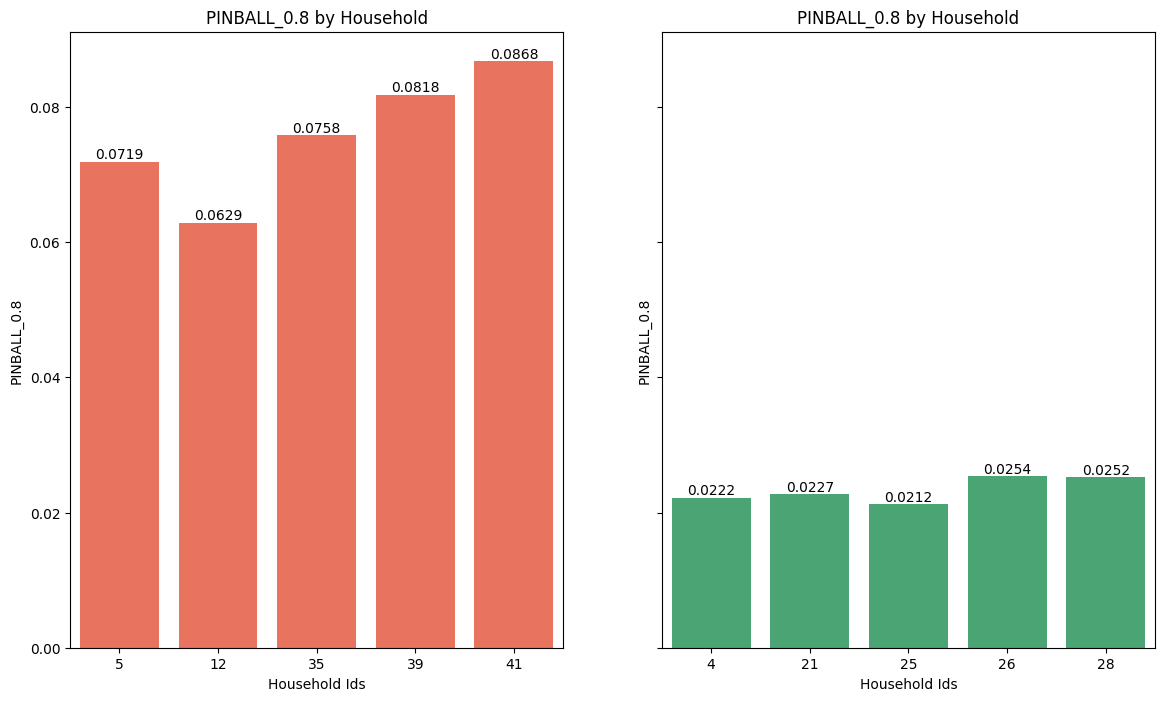

In [179]:
top5_metric = quantile_gru_metrics.sort_values(by='pinball_0.8', ascending=False).head(5)
bottom5_metric = quantile_gru_metrics.sort_values(by='pinball_0.8', ascending=True).head(5)
plot_metrics_bar(top5_metric, bottom5_metric, 'pinball_0.8')

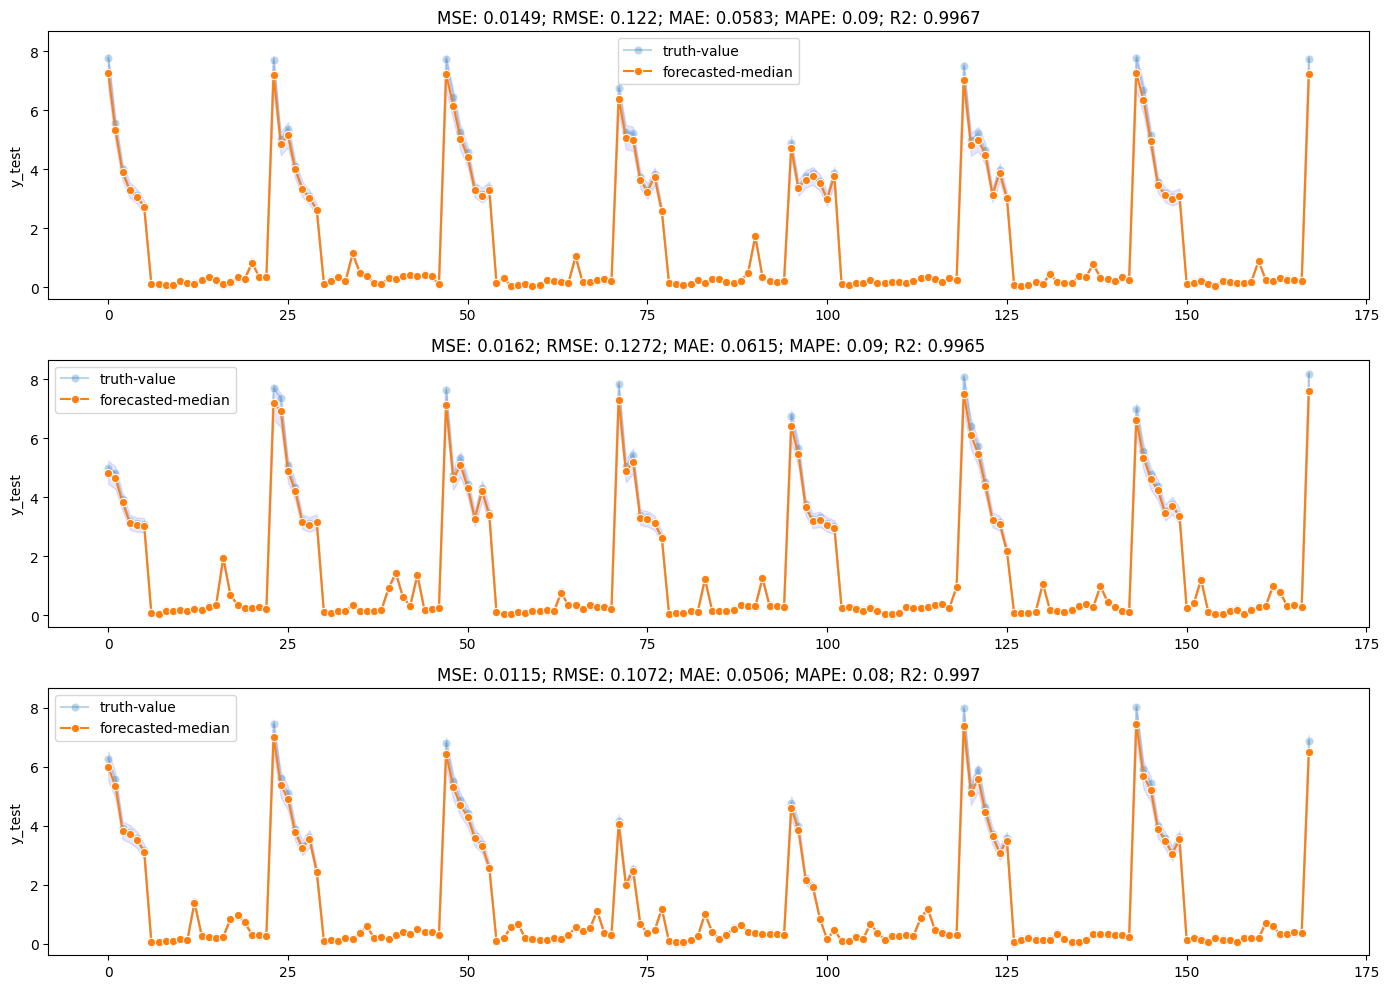

In [180]:
filtered_data = quantile_gru_pred_by_household.loc[quantile_gru_pred_by_household['household_id'] == 47]
plot_forecast(filtered_data[['pred_0.2', 'pred_0.5', 'pred_0.8']], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))

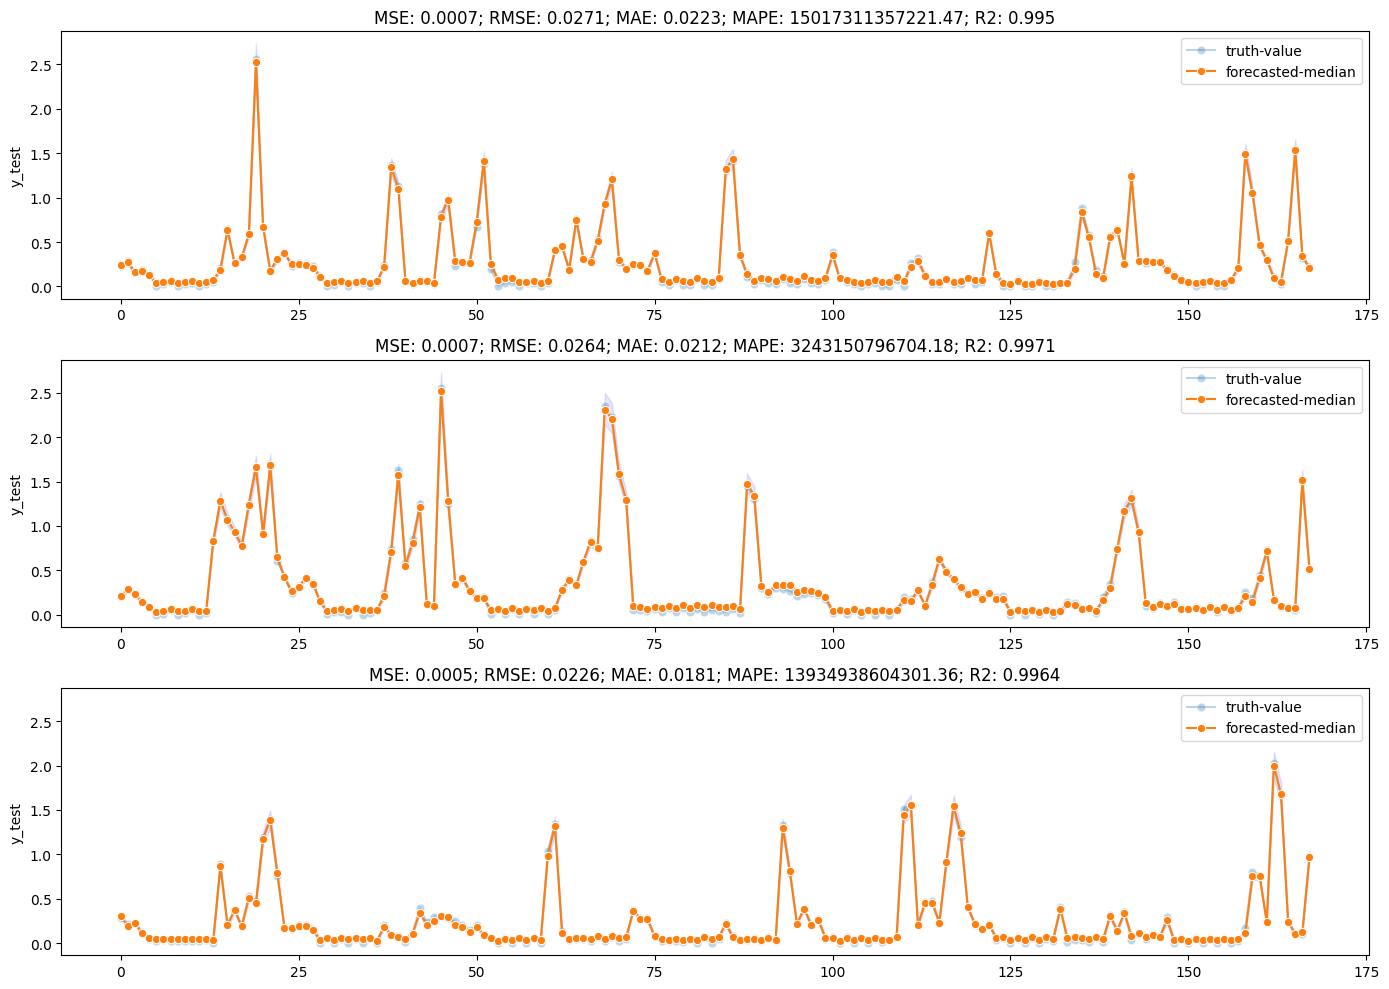

In [181]:
filtered_data = quantile_gru_pred_by_household.loc[quantile_gru_pred_by_household['household_id'] == 48]
plot_forecast(filtered_data[['pred_0.2', 'pred_0.5', 'pred_0.8']], filtered_data['y_test'], number_of_slices=3, steps=168, skip=(168 * 0))